## Set up and Load Packages

In [ ]:
# check which gpu we're using
!nvidia-smi

Thu Mar  3 21:39:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install simpletransformers
!pip install tensorboardx
# !pip install -U spacy
# !python -m spacy download en

     |████████████████████████████████| 248 kB 15.2 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 1.2 MB 64.4 MB/s 
     |████████████████████████████████| 311 kB 68.5 MB/s 
     |████████████████████████████████| 9.9 MB 52.8 MB/s 
     |████████████████████████████████| 1.7 MB 80.8 MB/s 
     |████████████████████████████████| 6.5 MB 61.8 MB/s 
     |████████████████████████████████| 3.8 MB 76.1 MB/s 
     |████████████████████████████████| 895 kB 64.0 MB/s 
     |████████████████████████████████| 596 kB 69.0 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 181 kB 65.9 MB/s 
     |████████████████████████████████| 144 kB 66.9 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 134 kB 81.2 MB/s 
     |████████████████████████████████| 212 kB 86.3 MB/s 
     |████████████████████████████████| 1.1 MB 47.4 MB/s 
     |██████████████

     |████████████████████████████████| 125 kB 14.1 MB/s 


In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval
from sklearn.metrics import classification_report

In [ ]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)
if not cuda_available:
  print('WARNING: You may want to change the runtime to GPU for faster training!')
  device_name = 'cpu'
else:
  device_name = 'cuda:0'

Cuda available?  True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Colab Notebooks/'
%mkdir './nlp_cw'
%cd './nlp_cw' 

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks
mkdir: cannot create directory ‘./nlp_cw’: File exists
/content/drive/MyDrive/Colab Notebooks/nlp_cw




## Helper Methods for Data Augmentations

In [ ]:
# https://github.com/jasonwei20/eda_nlp/blob/master/code/eda.py
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import wordnet 
import random
#stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
			'ours', 'ourselves', 'you', 'your', 'yours', 
			'yourself', 'yourselves', 'he', 'him', 'his', 
			'himself', 'she', 'her', 'hers', 'herself', 
			'it', 'its', 'itself', 'they', 'them', 'their', 
			'theirs', 'themselves', 'what', 'which', 'who', 
			'whom', 'this', 'that', 'these', 'those', 'am', 
			'is', 'are', 'was', 'were', 'be', 'been', 'being', 
			'have', 'has', 'had', 'having', 'do', 'does', 'did',
			'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
			'because', 'as', 'until', 'while', 'of', 'at', 
			'by', 'for', 'with', 'about', 'against', 'between',
			'into', 'through', 'during', 'before', 'after', 
			'above', 'below', 'to', 'from', 'up', 'down', 'in',
			'out', 'on', 'off', 'over', 'under', 'again', 
			'further', 'then', 'once', 'here', 'there', 'when', 
			'where', 'why', 'how', 'all', 'any', 'both', 'each', 
			'few', 'more', 'most', 'other', 'some', 'such', 'no', 
			'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
			'very', 's', 't', 'can', 'will', 'just', 'don', 
			'should', 'now', '']

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

# main function to be used for data augmentation
def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			#print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	#this is stupid but we need it, trust me
	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')

	return new_words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Load data

In [ ]:
# NOTE: upload the file DontPatronizeMe.py to colab in directory
# '/content/drive/MyDrive/Colab Notebooks/nlp_cw'
# otherwise, it gives error

from dont_patronize_me import DontPatronizeMe
def load_official_eval_data(dpm):
    '''code from baseline colab'''

    dpm.load_task1()
    dpm.load_task2(return_one_hot=True)

    trids = pd.read_csv('./data/train_semeval_parids-labels.csv')
    teids = pd.read_csv('./data/dev_semeval_parids-labels.csv')
    trids.par_id = trids.par_id.astype(str)
    teids.par_id = teids.par_id.astype(str)

    # get train data with binary label
    train_rows = []
    for idx in range(len(trids)):  
        parid = trids.par_id[idx]
        # select row from original dataset to retrieve `text` and binary label
        text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
        label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
        train_rows.append({
            'par_id':parid,
            'text':text,
            'labels':label
        })
    
    # get official evaluation data with binary label and level_labels
    bin_rows, multi_label_rows = [], [] # will contain par_id, label and text
    for idx in range(len(teids)):  
        parid = teids.par_id[idx]
        # select row from original dataset
        text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
        bin_label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
        orig_label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].orig_label.values[0]
        bin_rows.append({
            'par_id':parid,
            'text':text,
            'labels':bin_label,
            'orig_label':int(orig_label)
        })

        multi_label = teids.label[idx]
        multi_label_rows.append({
            'par_id':parid,
            'text':text,
            'labels':multi_label
        })

    bin_eval_data = pd.DataFrame(bin_rows, columns=['text', 'labels', 'orig_label'])
    multi_label_eval_data = pd.DataFrame(multi_label_rows, columns=['text', 'labels'])
    train_data = pd.DataFrame(train_rows, columns=['text', 'labels'])

    return bin_eval_data, multi_label_eval_data, train_data

# load data for experiments later on
dpm = DontPatronizeMe('./data/', './data/')
eval_data, multi_label_eval_data, train_data = load_official_eval_data(dpm)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [ ]:
train_data.head(10)

,text,labels
0,"The scheme saw an estimated 150,000 children f...",1
1,Durban 's homeless communities reconciliation ...,1
2,The next immediate problem that cropped up was...,1
3,Far more important than the implications for t...,1
4,To strengthen child-sensitive social protectio...,1
5,"Today , homeless women are still searching for...",1
6,"As a member of Care of Hope , Barnett provides...",1
7,"""Lougene has this message to others who may st...",1
8,A harrowing journey Night falls early in this ...,1
9,Those from poor families were more likely to l...,1


In [ ]:
eval_data.head(10)

,text,labels,orig_label
0,We also know that they can benefit by receivin...,1,3
1,Pope Francis washed and kissed the feet of Mus...,1,4
2,Many refugees do n't want to be resettled anyw...,1,2
3,"""Budding chefs , like """" Fred """" , """" Winston ...",1,4
4,"""In a 90-degree view of his constituency , one...",1,3
5,He depicts demonstrations by refugees at the b...,1,2
6,The Word of God is truth that 's living and ab...,1,3
7,"Chantelle Owens , Mrs Planet 2016 , hosted the...",1,4
8,t is remiss not to mention here that not all s...,1,2
9,""""""" People do n't understand the hurt , people...",1,4


In [ ]:
multi_label_eval_data.head(10)

,text,labels
0,We also know that they can benefit by receivin...,"[1, 0, 0, 1, 0, 0, 0]"
1,Pope Francis washed and kissed the feet of Mus...,"[0, 1, 0, 0, 0, 0, 0]"
2,Many refugees do n't want to be resettled anyw...,"[0, 0, 1, 0, 0, 0, 0]"
3,"""Budding chefs , like """" Fred """" , """" Winston ...","[1, 0, 0, 1, 1, 1, 0]"
4,"""In a 90-degree view of his constituency , one...","[1, 0, 0, 0, 0, 0, 0]"
5,He depicts demonstrations by refugees at the b...,"[0, 0, 0, 0, 0, 1, 0]"
6,The Word of God is truth that 's living and ab...,"[1, 0, 0, 0, 0, 1, 0]"
7,"Chantelle Owens , Mrs Planet 2016 , hosted the...","[1, 1, 0, 0, 0, 1, 0]"
8,t is remiss not to mention here that not all s...,"[0, 0, 1, 0, 0, 0, 0]"
9,""""""" People do n't understand the hurt , people...","[1, 0, 1, 1, 0, 1, 0]"


###Load Data

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import string
import sklearn
random.seed(0)
from sklearn.model_selection import train_test_split


def augment_sentence(text, n=4):
    words = text.split(' ')
    
    if n >= len(words):
        n = 1

    # if word contains punctuation, not use it for augmentation
    distilled_words = []
    for word in words:
        if any(p in word for p in string.punctuation):
            pass
        distilled_words.append(word)

    # get synonym
    augmented_words = synonym_replacement(distilled_words, n)
    # put the sentence back together
    return ' '.join(augmented_words)

def read_data(eval_data, multi_label_eval_data, train_data):
    """
    Load task 1 training set and convert the tags into binary labels. 
    Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
    Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.
    """

    # preprocess training data
    X_train = train_data['text'].values.tolist()
    y_train = train_data['labels'].values.tolist()

    # internal validation dataset 
    X_train, X_intVal, y_train, y_intVal = train_test_split(X_train, y_train, test_size=0.1, random_state=0, stratify=y_train)
    X_train, y_train = np.array(X_train), np.array(y_train)

    # get the corresonding texts and its label for each class in the training set
    label_1_texts, label_0_texts = X_train[y_train == 1], X_train[y_train == 0]
    label_1s, label_0s = y_train[y_train == 1], y_train[y_train == 0]
    assert(len(label_1s) + len(label_0s) == len(X_train))

    # replace each sentence with synomny word
    agmt_ratio = 0.30
    agmt_text_1 = []
    for text in label_1_texts:
        agmt_text_1.append(augment_sentence(text))
    random.shuffle(agmt_text_1)
    agmt_text_1 = agmt_text_1[:int(len(agmt_text_1)*agmt_ratio)]
    agmt_label_1 = len(agmt_text_1) * [1]

    agmt_text_0 = []
    for text in label_0_texts:
        agmt_text_0.append(augment_sentence(text))
    random.shuffle(agmt_text_0)
    agmt_text_0 = agmt_text_0[:int(len(agmt_text_0)*agmt_ratio)]
    agmt_label_0 = len(agmt_text_0) * [0]

    # augment the training set before up/down samples
    full_label1_text, full_label1s = np.array(list(label_1_texts) + agmt_text_1), np.array(list(label_1s) + agmt_label_1)
    full_label0_text, full_label0s = np.array(list(label_0_texts) + agmt_text_0), np.array(list(label_0s) + agmt_label_0)

    # best score with *2 on both
    downsampled_indices = np.random.choice(len(full_label0s), size=len(label_0s)*2, replace=(len(full_label0s) < (len(label_0s)*2)))
    downsampled_label_0_text = full_label0_text[downsampled_indices]
    downsampled_label_0s = full_label0s[downsampled_indices]

    # upsample
    upsampled_indices = np.random.choice(len(full_label1_text), size=len(label_0s), replace=(len(full_label1_text) < len(label_0s)))
    upsampled_label_1_text = full_label1_text[upsampled_indices]
    upsampled_label_1s = full_label1s[upsampled_indices]

    preprocessed_texts = list(upsampled_label_1_text) + list(downsampled_label_0_text)
    proprocessed_labels = list(upsampled_label_1s) + list(downsampled_label_0s)

    print('After: Number of 0 labels in training = {}'.format(proprocessed_labels.count(0)))
    print('After: Number of 1 labels in training = {}'.format(proprocessed_labels.count(1)))

    # sanity check:
    assert(all(label == 1 for label in upsampled_label_1s) and all(label == 0 for label in downsampled_label_0s))
    assert(len(preprocessed_texts) == len(proprocessed_labels))

    train_data_rows = [{'text': text, 'labels':label} for text, label in zip(preprocessed_texts, proprocessed_labels)]
    train_data = pd.DataFrame(train_data_rows, columns=['text', 'labels'])

    val_data_rows = [{'text': text, 'labels':label} for text, label in zip(X_intVal, y_intVal)]
    val_data = pd.DataFrame(val_data_rows, columns=['text', 'labels'])

    return train_data, eval_data, val_data

# process data and inspection
train_data, eval_data, val_data = read_data(eval_data, multi_label_eval_data, train_data)

print(len(train_data))
print(len(val_data))

After: Number of 0 labels in training = 13644
After: Number of 1 labels in training = 6822
20466
838


####Training data

In [ ]:
print(len(train_data))
train_data.head(10)

20466


,text,labels
0,Pope Francis will visit a tiny Italian island ...,1
1,""""""" She was in a vulnerable , helpless , hopel...",1
2,"""Courses include Greek , side , mathematics , ...",1
3,Remarkable too are the ways in which a childho...,1
4,""""""" Evros is not just the border , """" he say ....",1
5,When Nana Akufo Addo presented his true state ...,1
6,one time again the roofless Rohingya are on th...,1
7,World Refugee Day is marked on June 20 every y...,1
8,""""""" If I die ... I know there is a day that I ...",1
9,""""""" The commitment of Christians in this field...",1


####Validation data

In [ ]:
print(len(val_data))
val_data.head(10)

838


,text,labels
0,""""""" It is vile for far-right extremists and ne...",0
1,"""He noted that he was the """" son of immigrants...",0
2,"""Photo of Keanu Reeves more like a homeless ma...",0
3,The obscenity of this photograph lies in the w...,0
4,""""""" Because it was easier and cheaper than Eur...",0
5,The basic rationale for this legislation -- th...,0
6,It was established in 1987 to care for vulnera...,0
7,"""When we asked Eni how Bethune imparted this b...",0
8,"""She mentioned congratulating president-elect ...",0
9,"""It is just a difference in need . Equality is...",0


####Official Dev data

In [ ]:
print(len(eval_data))
eval_data.head(10)

2094


,text,labels,orig_label
0,We also know that they can benefit by receivin...,1,3
1,Pope Francis washed and kissed the feet of Mus...,1,4
2,Many refugees do n't want to be resettled anyw...,1,2
3,"""Budding chefs , like """" Fred """" , """" Winston ...",1,4
4,"""In a 90-degree view of his constituency , one...",1,3
5,He depicts demonstrations by refugees at the b...,1,2
6,The Word of God is truth that 's living and ab...,1,3
7,"Chantelle Owens , Mrs Planet 2016 , hosted the...",1,4
8,t is remiss not to mention here that not all s...,1,2
9,""""""" People do n't understand the hurt , people...",1,4


### Load Test Data

In [ ]:
def load_test(path='./data/task4_test.tsv'):
    rows=[]
    # sp = spacy.load('en_core_web_sm')
    with open(path) as f:
        for line in f.readlines():
            t=line.strip().split('\t')[4]
            rows.append(t)
    df=pd.DataFrame(rows, columns=['text'])
    return df, rows

tedf1, raw_test_texts = load_test()

# for inspection 
tedf1.head(10)

,text
0,"In the meantime , conservatives are working to..."
1,In most poor households with no education chil...
2,The real question is not whether immigration i...
3,"In total , the country 's immigrant population..."
4,"Members of the church , which is part of Ken C..."
5,"""To ensure that """" Priority Agriculture Progra..."
6,The deportees stepped off their flight from El...
7,PIMS staffer who raped disabled girl at ICU wa...
8,"I conclude , Yes , the general FEELING generat..."
9,After enduring discrimination in the all-male ...


### Load Categorical Data

In [ ]:
categorical_data = dpm.train_task2_df
categorical_data.head(10)

,par_id,art_id,text,keyword,country,label
0,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,"[1, 0, 0, 1, 0, 0, 0]"
1,1279,@@7896098,Pope Francis washed and kissed the feet of Mus...,refugee,ng,"[0, 1, 0, 0, 0, 0, 0]"
2,8330,@@17252299,Many refugees do n't want to be resettled anyw...,refugee,ng,"[0, 0, 1, 0, 0, 0, 0]"
3,4063,@@3002894,"""Budding chefs , like """" Fred """" , """" Winston ...",in-need,ie,"[1, 0, 0, 1, 1, 1, 0]"
4,4089,@@25597822,"""In a 90-degree view of his constituency , one...",homeless,pk,"[1, 0, 0, 0, 0, 0, 0]"
5,432,@@15802146,He depicts demonstrations by refugees at the b...,refugee,nz,"[0, 0, 0, 0, 0, 1, 0]"
6,4177,@@930041,The Word of God is truth that 's living and ab...,hopeless,us,"[1, 0, 0, 0, 0, 1, 0]"
7,3963,@@18867357,"Chantelle Owens , Mrs Planet 2016 , hosted the...",in-need,za,"[1, 1, 0, 0, 0, 1, 0]"
8,2001,@@14012804,t is remiss not to mention here that not all s...,poor-families,tz,"[0, 0, 1, 0, 0, 0, 0]"
9,369,@@15636898,""""""" People do n't understand the hurt , people...",women,ie,"[1, 0, 1, 1, 0, 1, 0]"


## Data analysis

### Check data distribution

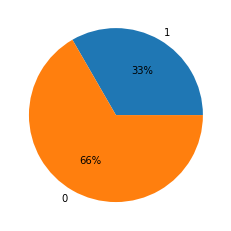

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = np.array(train_data['labels'].values.tolist())
label1, label0 = len(labels[labels == 1]), len(labels[labels == 0])

# show p
words = [('1', label1), ('0', label0)]
sizes, labels = [i[1] for i in words],[i[0] for i in words]
plt.pie(sizes, labels=labels,autopct='%1.1i%%')
plt.show()

### Check label and input size correlation

In [ ]:
texts = train_data['text'].values.tolist()
labels = train_data['labels'].values.tolist()

label_1_corpus_avg_size = []
label_0_corpus_avg_size = []
for text, label in zip(texts, labels):
    if label == 0:
        label_0_corpus_avg_size.append(len(text))
    else:
        label_1_corpus_avg_size.append(len(text))

from statistics import mean
data = {
    'Average Input Length for Label 1': [mean(label_1_corpus_avg_size)],
    'Average Input Length for Label 0': [mean(label_0_corpus_avg_size)],
}
pd.DataFrame(data)

,Average Input Length for Label 1,Average Input Length for Label 0
0,295.29185,266.882219


## Train and Prediction Helper Methods

In [ ]:
DEFAULT_SEQ_LENGTH = 128
def train_model(model_type, model_name, 
                epochs, best_model_dir, 
                lr=4e-5, batch_size=32, hpt=False,
                max_seq_length=DEFAULT_SEQ_LENGTH):
    
    if hpt:
        model_args = ClassificationArgs(num_train_epochs=epochs, 
                                            no_cache=False, 
                                            no_save=True,#
                                            max_seq_length = max_seq_length,
                                            overwrite_output_dir=True,
                                            evaluate_during_training = True,
                                            evaluate_during_training_steps = 50,
                                            evaluate_during_training_verbose = True,
                                            use_early_stopping = False,
                                            early_stopping_metric = "f1",
                                            early_stopping_metric_minimize = False,
                                            save_eval_checkpoints = False,
                                            early_stopping_patience = 20,
                                            save_best_model=True,
                                            best_model_dir=best_model_dir,
                                            learning_rate=lr,
                                            eval_batch_size = batch_size,
                                            train_batch_size = batch_size)
    else:
        model_args = ClassificationArgs(num_train_epochs=epochs, 
                                            no_cache=False, 
                                            max_seq_length = max_seq_length,
                                            overwrite_output_dir=True,
                                            evaluate_during_training = True,
                                            evaluate_during_training_steps = 50,
                                            evaluate_during_training_verbose = True,
                                            use_early_stopping = True,
                                            early_stopping_metric = "f1",
                                            early_stopping_metric_minimize = False,
                                            save_eval_checkpoints = False,
                                            early_stopping_patience = 20,
                                            save_best_model=True,
                                            best_model_dir=best_model_dir,
                                            learning_rate=lr,
                                            eval_batch_size = batch_size,
                                            train_batch_size = batch_size)

    task1_model = ClassificationModel(model_type, 
                                      model_name, 
                                      args = model_args, 
                                      num_labels=2, 
                                      use_cuda=cuda_available)

    task1_model.train_model(train_data[['text', 'labels']], 
                            eval_df=val_data, 
                            f1=sklearn.metrics.f1_score)
    
    if hpt:
        return task1_model

    # retrieve the early stopped best model
    best_model = ClassificationModel(
        model_type, best_model_dir
    )

    return best_model

def ensemble_predictions(models, test_samples):
    
    # run prediction for each model
    raw_outputs = []

    output_sums = None
    for model in models:
        _, outputs = model.predict(test_samples)
        outputs = torch.from_numpy(outputs)

        if output_sums is None:
            output_sums = outputs
        else:
            output_sums += outputs

    final_predictions = torch.max(output_sums, 1)[1].cpu().tolist()
    assert(len(final_predictions) == len(test_samples))
    return final_predictions

# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')


##Hyerparameter Tunning


In [ ]:
# learning rate, batch size
learning_rates = [5e-5, 4e-5, 1e-5]
epochs = 2
batch_sizes = [32, 64]

# evaluate on the internal validation data
text = val_data['text'].values.tolist()
bin_labels = val_data['labels'].values.tolist()

hp_results = []
for lr in learning_rates:
    for batch_size in batch_sizes:
        model_type = 'bert'
        best_model_dir = 'outputs/hpt/early_stopped_bert_large'
        m3 = train_model(model_type, 'bert-large-cased', epochs, best_model_dir, hpt=True)

        model_type = 'roberta'
        best_model_dir = 'outputs/hpt/early_stopped_toxic'
        m1 = train_model(model_type, 'SkolkovoInstitute/roberta_toxicity_classifier', 
                         epochs, best_model_dir, hpt=True)

        model_type = 'roberta'
        best_model_dir = 'outputs/hpt/early_stopped_offensive'
        m2 = train_model(model_type, 'cardiffnlp/twitter-roberta-base-offensive', 
                         epochs, best_model_dir, hpt=True)

        # ensemble predictions
        predictions = ensemble_predictions([m1, m2, m3], text)

        # get the  metrics score for this particular length
        official_eval_report = classification_report(bin_labels, predictions)
        hp_results.append((lr, batch_size, official_eval_report))
        

# choose the best set of hyperparameters
# opt_hps = sorted(hp_results, key=lambda x:x[-1])[-1]
# opt_lr, opt_batch_size = opt_hps[0], opt_hps[1]
# print('optimal learning rate {}'.format(opt_lr))
# print('optimal batch size {}'.format(opt_batch_size))

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.055126234163299, 'tp': 6, 'tn': 730, 'fp': 29, 'fn': 73, 'auroc': 0.7210853721585697, 'auprc': 0.18162726603660562, 'f1': 0.10526315789473684, 'eval_loss': 0.3412791595414833}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39407213911803995, 'tp': 48, 'tn': 673, 'fp': 86, 'fn': 31, 'auroc': 0.8512032821333867, 'auprc': 0.46356515528550024, 'f1': 0.45070422535211263, 'eval_loss': 0.3005846518057364}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3669981371836785, 'tp': 28, 'tn': 730, 'fp': 29, 'fn': 51, 'auroc': 0.8373943062990944, 'auprc': 0.46517704887297295, 'f1': 0.4117647058823529, 'eval_loss': 0.25563642106674334}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3699221311949549, 'tp': 54, 'tn': 634, 'fp': 125, 'fn': 25, 'auroc': 0.8569236670502494, 'auprc': 0.49736306570010247, 'f1': 0.4186046511627907, 'eval_loss': 0.35864257205415656}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38895067564044633, 'tp': 34, 'tn': 719, 'fp': 40, 'fn': 45, 'auroc': 0.861901902903554, 'auprc': 0.47091340973046936, 'f1': 0.4444444444444444, 'eval_loss': 0.25016369946576933}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41572478791103507, 'tp': 39, 'tn': 712, 'fp': 47, 'fn': 40, 'auroc': 0.8777038408298727, 'auprc': 0.4877061135607846, 'f1': 0.4727272727272727, 'eval_loss': 0.26083560895036767}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4651229864278228, 'tp': 39, 'tn': 725, 'fp': 34, 'fn': 40, 'auroc': 0.852712596521072, 'auprc': 0.5060020328301963, 'f1': 0.513157894736842, 'eval_loss': 0.285588671763738}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41405762521342815, 'tp': 43, 'tn': 699, 'fp': 60, 'fn': 36, 'auroc': 0.8271876719867914, 'auprc': 0.500035758762165, 'f1': 0.47252747252747246, 'eval_loss': 0.3458002474572923}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34155468493752966, 'tp': 29, 'tn': 721, 'fp': 38, 'fn': 50, 'auroc': 0.8278214172545487, 'auprc': 0.4441995684480372, 'f1': 0.3972602739726027, 'eval_loss': 0.352143508416635}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3810365554232468, 'tp': 28, 'tn': 733, 'fp': 26, 'fn': 51, 'auroc': 0.8308900785510582, 'auprc': 0.44728358671190344, 'f1': 0.42105263157894735, 'eval_loss': 0.3041181447053397}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36917320128368875, 'tp': 27, 'tn': 733, 'fp': 26, 'fn': 52, 'auroc': 0.8573489434799286, 'auprc': 0.4826377825336163, 'f1': 0.40909090909090906, 'eval_loss': 0.33340496597466646}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4033435338134877, 'tp': 35, 'tn': 720, 'fp': 39, 'fn': 44, 'auroc': 0.8755107486532914, 'auprc': 0.5237503508548961, 'f1': 0.45751633986928103, 'eval_loss': 0.38015178342660266}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3644041648906559, 'tp': 27, 'tn': 732, 'fp': 27, 'fn': 52, 'auroc': 0.8366021247143978, 'auprc': 0.471949888816526, 'f1': 0.40601503759398494, 'eval_loss': 0.39905272865736924}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3921884423747427, 'tp': 35, 'tn': 717, 'fp': 42, 'fn': 44, 'auroc': 0.868789713313654, 'auprc': 0.49810341452566564, 'f1': 0.4487179487179487, 'eval_loss': 0.4708085882442969}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38123873443699857, 'tp': 17, 'tn': 754, 'fp': 5, 'fn': 62, 'auroc': 0.826954186888144, 'auprc': 0.46440288643620925, 'f1': 0.3366336633663366, 'eval_loss': 0.5003626216892842}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.32224343603424954, 'tp': 20, 'tn': 741, 'fp': 18, 'fn': 59, 'auroc': 0.8220426610630243, 'auprc': 0.46419534342785784, 'f1': 0.3418803418803419, 'eval_loss': 0.45194341111238356}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38953464825842116, 'tp': 27, 'tn': 737, 'fp': 22, 'fn': 52, 'auroc': 0.8269792031487133, 'auprc': 0.4896020912881844, 'f1': 0.42187499999999994, 'eval_loss': 0.5261847040167561}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34108663815383977, 'tp': 18, 'tn': 748, 'fp': 11, 'fn': 61, 'auroc': 0.8139457313920715, 'auprc': 0.4616608893532793, 'f1': 0.3333333333333333, 'eval_loss': 0.5251048422522016}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3855940378782571, 'tp': 30, 'tn': 729, 'fp': 30, 'fn': 49, 'auroc': 0.8270042194092826, 'auprc': 0.4889110037558323, 'f1': 0.43165467625899284, 'eval_loss': 0.47541909885627254}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40009650403642766, 'tp': 26, 'tn': 741, 'fp': 18, 'fn': 53, 'auroc': 0.81268657961008, 'auprc': 0.4781610500432021, 'f1': 0.4227642276422764, 'eval_loss': 0.5282359913819366}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3506842159823586, 'tp': 23, 'tn': 739, 'fp': 20, 'fn': 56, 'auroc': 0.8122446256733542, 'auprc': 0.48131207151266303, 'f1': 0.3770491803278689, 'eval_loss': 0.5454403666986359}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3948795974768465, 'tp': 23, 'tn': 746, 'fp': 13, 'fn': 56, 'auroc': 0.8073330998482346, 'auprc': 0.47014504841876137, 'f1': 0.4, 'eval_loss': 0.5328744694038674}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39616641654063406, 'tp': 28, 'tn': 736, 'fp': 23, 'fn': 51, 'auroc': 0.8121862543986924, 'auprc': 0.4754094049414323, 'f1': 0.4307692307692308, 'eval_loss': 0.5233291473101687}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3691935926273934, 'tp': 24, 'tn': 740, 'fp': 19, 'fn': 55, 'auroc': 0.807825086306099, 'auprc': 0.4733674371038117, 'f1': 0.39344262295081966, 'eval_loss': 0.5379300142327944}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3877029692724281, 'tp': 25, 'tn': 741, 'fp': 18, 'fn': 54, 'auroc': 0.7836510398425642, 'auprc': 0.45426785169841627, 'f1': 0.4098360655737705, 'eval_loss': 0.5186793118439339}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3890260124394452, 'tp': 22, 'tn': 747, 'fp': 12, 'fn': 57, 'auroc': 0.7683244108670635, 'auprc': 0.4299533042317268, 'f1': 0.3893805309734513, 'eval_loss': 0.5183644245068232}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4021559875395065, 'tp': 23, 'tn': 747, 'fp': 12, 'fn': 56, 'auroc': 0.7770050532846349, 'auprc': 0.43789604276922245, 'f1': 0.40350877192982454, 'eval_loss': 0.5188838947150443}
INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.


Downloading:   0%|          | 0.00/794 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3968780972437768, 'tp': 56, 'tn': 640, 'fp': 119, 'fn': 23, 'auroc': 0.8467670652590851, 'auprc': 0.3653615495205453, 'f1': 0.4409448818897637, 'eval_loss': 0.37820771281365995}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33981897830513047, 'tp': 23, 'tn': 737, 'fp': 22, 'fn': 56, 'auroc': 0.8535381331198613, 'auprc': 0.4637717278407497, 'f1': 0.3709677419354839, 'eval_loss': 0.23311524920993382}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4459236862666305, 'tp': 56, 'tn': 665, 'fp': 94, 'fn': 23, 'auroc': 0.8831490468804724, 'auprc': 0.4971333820290315, 'f1': 0.48908296943231444, 'eval_loss': 0.3014500317750154}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.46048398340355334, 'tp': 59, 'tn': 660, 'fp': 99, 'fn': 20, 'auroc': 0.889895098480679, 'auprc': 0.5033612593482307, 'f1': 0.49789029535864976, 'eval_loss': 0.40139082184544317}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.46758497315046693, 'tp': 50, 'tn': 695, 'fp': 64, 'fn': 29, 'auroc': 0.8977752205600307, 'auprc': 0.5040661412271137, 'f1': 0.5181347150259067, 'eval_loss': 0.28139342919543936}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.473361625788751, 'tp': 56, 'tn': 677, 'fp': 82, 'fn': 23, 'auroc': 0.8913877353613182, 'auprc': 0.494750212930696, 'f1': 0.5161290322580645, 'eval_loss': 0.37845658759276074}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.473361625788751, 'tp': 56, 'tn': 677, 'fp': 82, 'fn': 23, 'auroc': 0.893272293657544, 'auprc': 0.46575242640785713, 'f1': 0.5161290322580645, 'eval_loss': 0.3715378882156478}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37745054135992495, 'tp': 20, 'tn': 749, 'fp': 10, 'fn': 59, 'auroc': 0.8144794116175513, 'auprc': 0.45602530669090874, 'f1': 0.36697247706422015, 'eval_loss': 0.4626312561471153}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39354025134009346, 'tp': 44, 'tn': 688, 'fp': 71, 'fn': 35, 'auroc': 0.8788712663231101, 'auprc': 0.41687614096921344, 'f1': 0.4536082474226804, 'eval_loss': 0.5250699649806376}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.45272507861022776, 'tp': 39, 'tn': 722, 'fp': 37, 'fn': 40, 'auroc': 0.8948983505945531, 'auprc': 0.49240162188059033, 'f1': 0.5032258064516129, 'eval_loss': 0.400046615274968}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.48608527486396064, 'tp': 37, 'tn': 734, 'fp': 25, 'fn': 42, 'auroc': 0.8716832607861777, 'auprc': 0.4891566005423996, 'f1': 0.5248226950354611, 'eval_loss': 0.39551906908551854}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.347866223079429, 'tp': 19, 'tn': 747, 'fp': 12, 'fn': 60, 'auroc': 0.8591918080085389, 'auprc': 0.4907446354290582, 'f1': 0.34545454545454546, 'eval_loss': 0.49849458797662344}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39400344776872376, 'tp': 24, 'tn': 744, 'fp': 15, 'fn': 55, 'auroc': 0.8903704074314972, 'auprc': 0.5297102235209169, 'f1': 0.4067796610169492, 'eval_loss': 0.4117505578895496}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.48525593260710875, 'tp': 45, 'tn': 715, 'fp': 44, 'fn': 34, 'auroc': 0.8959323560314204, 'auprc': 0.5440049819299124, 'f1': 0.5357142857142858, 'eval_loss': 0.3963525999613382}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40057959049822034, 'tp': 27, 'tn': 739, 'fp': 20, 'fn': 52, 'auroc': 0.8807308083587666, 'auprc': 0.5236681574856303, 'f1': 0.42857142857142855, 'eval_loss': 0.5015620058518295}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44406182310630304, 'tp': 34, 'tn': 732, 'fp': 27, 'fn': 45, 'auroc': 0.878537716182185, 'auprc': 0.4995224019392448, 'f1': 0.48571428571428565, 'eval_loss': 0.43765502680670815}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4318775083054385, 'tp': 32, 'tn': 734, 'fp': 25, 'fn': 47, 'auroc': 0.8511782658728173, 'auprc': 0.5215938395775876, 'f1': 0.47058823529411764, 'eval_loss': 0.5617633035613431}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4126231539251193, 'tp': 32, 'tn': 730, 'fp': 29, 'fn': 47, 'auroc': 0.8769533530127916, 'auprc': 0.4792610776256825, 'f1': 0.45714285714285713, 'eval_loss': 0.5647412035385194}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4318775083054385, 'tp': 32, 'tn': 734, 'fp': 25, 'fn': 47, 'auroc': 0.8688981171094544, 'auprc': 0.5117158971761138, 'f1': 0.47058823529411764, 'eval_loss': 0.5899941831551216}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40791997608073877, 'tp': 29, 'tn': 736, 'fp': 23, 'fn': 50, 'auroc': 0.8672887376794918, 'auprc': 0.4840324530004029, 'f1': 0.4427480916030535, 'eval_loss': 0.630724424013385}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4256928412610916, 'tp': 36, 'tn': 723, 'fp': 36, 'fn': 43, 'auroc': 0.8913543803472257, 'auprc': 0.5109278073161889, 'f1': 0.4768211920529801, 'eval_loss': 0.5976299176245111}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43630503384244546, 'tp': 35, 'tn': 728, 'fp': 31, 'fn': 44, 'auroc': 0.8827988192325011, 'auprc': 0.5129605283141544, 'f1': 0.4827586206896552, 'eval_loss': 0.6080428302104539}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43033029172057247, 'tp': 30, 'tn': 738, 'fp': 21, 'fn': 49, 'auroc': 0.8884441553676556, 'auprc': 0.5118658680803219, 'f1': 0.46153846153846156, 'eval_loss': 0.5663209691367768}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4014798527090974, 'tp': 28, 'tn': 737, 'fp': 22, 'fn': 51, 'auroc': 0.884408198662464, 'auprc': 0.4986520717852162, 'f1': 0.434108527131783, 'eval_loss': 0.5746841096767673}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40057959049822034, 'tp': 27, 'tn': 739, 'fp': 20, 'fn': 52, 'auroc': 0.8849252013808975, 'auprc': 0.49773078272344934, 'f1': 0.42857142857142855, 'eval_loss': 0.5620590469075574}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44741222931054164, 'tp': 31, 'tn': 739, 'fp': 20, 'fn': 48, 'auroc': 0.8889361418255199, 'auprc': 0.5010347397481634, 'f1': 0.4769230769230769, 'eval_loss': 0.5767376887853499}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44741222931054164, 'tp': 31, 'tn': 739, 'fp': 20, 'fn': 48, 'auroc': 0.8890528843748436, 'auprc': 0.5017778254605815, 'f1': 0.4769230769230769, 'eval_loss': 0.5782550850676166}
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


Downloading:   0%|          | 0.00/593 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3311547542400351, 'tp': 64, 'tn': 548, 'fp': 211, 'fn': 15, 'auroc': 0.8302146395156852, 'auprc': 0.33857734688517727, 'f1': 0.36158192090395475, 'eval_loss': 0.5125107588591399}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36650383861253505, 'tp': 59, 'tn': 606, 'fp': 153, 'fn': 20, 'auroc': 0.8496272577175163, 'auprc': 0.40594525230135214, 'f1': 0.40549828178694164, 'eval_loss': 0.4144399132993486}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42954473434616697, 'tp': 57, 'tn': 653, 'fp': 106, 'fn': 22, 'auroc': 0.8859341905571956, 'auprc': 0.5346735061895782, 'f1': 0.47107438016528924, 'eval_loss': 0.3170923055322082}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3861798203760656, 'tp': 38, 'tn': 706, 'fp': 53, 'fn': 41, 'auroc': 0.8836577108453828, 'auprc': 0.4700296676962763, 'f1': 0.4470588235294118, 'eval_loss': 0.2679916515394493}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37406467847197783, 'tp': 27, 'tn': 734, 'fp': 25, 'fn': 52, 'auroc': 0.8803972582178415, 'auprc': 0.4629308594491045, 'f1': 0.4122137404580153, 'eval_loss': 0.26557710821981784}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44833200112471444, 'tp': 52, 'tn': 681, 'fp': 78, 'fn': 27, 'auroc': 0.8924467570587548, 'auprc': 0.48588003696063115, 'f1': 0.49760765550239244, 'eval_loss': 0.38053028009555956}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4201065877664164, 'tp': 48, 'tn': 684, 'fp': 75, 'fn': 31, 'auroc': 0.8808058571404747, 'auprc': 0.43479083790793316, 'f1': 0.4752475247524753, 'eval_loss': 0.4375840800779837}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37212968770173993, 'tp': 26, 'tn': 736, 'fp': 23, 'fn': 53, 'auroc': 0.8575407348109605, 'auprc': 0.44792450647601634, 'f1': 0.40625, 'eval_loss': 0.30080790500398036}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.46110172964110013, 'tp': 41, 'tn': 719, 'fp': 40, 'fn': 38, 'auroc': 0.8882356865295775, 'auprc': 0.4921970855796669, 'f1': 0.5125, 'eval_loss': 0.461500797972635}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42479938948670265, 'tp': 55, 'tn': 659, 'fp': 100, 'fn': 24, 'auroc': 0.8935558112773303, 'auprc': 0.4955889889678807, 'f1': 0.4700854700854701, 'eval_loss': 0.5247357548386963}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3787745128318722, 'tp': 32, 'tn': 722, 'fp': 37, 'fn': 47, 'auroc': 0.8618185153683227, 'auprc': 0.4579801845032795, 'f1': 0.4324324324324324, 'eval_loss': 0.4182768897325904}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41684081939427375, 'tp': 34, 'tn': 726, 'fp': 33, 'fn': 45, 'auroc': 0.8384283117359618, 'auprc': 0.4580135184015651, 'f1': 0.4657534246575343, 'eval_loss': 0.4671359109105887}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3969038193345274, 'tp': 31, 'tn': 729, 'fp': 30, 'fn': 48, 'auroc': 0.8442070679274862, 'auprc': 0.42862736157889886, 'f1': 0.44285714285714284, 'eval_loss': 0.42110635469564134}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.35521171981483207, 'tp': 27, 'tn': 730, 'fp': 29, 'fn': 52, 'auroc': 0.8257117126131986, 'auprc': 0.4178120597531193, 'f1': 0.39999999999999997, 'eval_loss': 0.4535467457284944}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3373197665883774, 'tp': 24, 'tn': 734, 'fp': 25, 'fn': 55, 'auroc': 0.8291889728323409, 'auprc': 0.4243862488324365, 'f1': 0.375, 'eval_loss': 0.6025361861619685}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39926752724047476, 'tp': 32, 'tn': 727, 'fp': 32, 'fn': 47, 'auroc': 0.8399459648771701, 'auprc': 0.4430086140697905, 'f1': 0.44755244755244755, 'eval_loss': 0.5574979880518556}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34155468493752966, 'tp': 29, 'tn': 721, 'fp': 38, 'fn': 50, 'auroc': 0.8263954904020947, 'auprc': 0.44165883972186676, 'f1': 0.3972602739726027, 'eval_loss': 0.5652486577078148}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3637515787226172, 'tp': 32, 'tn': 718, 'fp': 41, 'fn': 47, 'auroc': 0.8405963876519738, 'auprc': 0.4604993671069107, 'f1': 0.4210526315789474, 'eval_loss': 0.5971628834527952}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3782332083947894, 'tp': 33, 'tn': 719, 'fp': 40, 'fn': 46, 'auroc': 0.8606177348609929, 'auprc': 0.48682711680499313, 'f1': 0.43421052631578944, 'eval_loss': 0.5748515940374799}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3639178293891805, 'tp': 31, 'tn': 721, 'fp': 38, 'fn': 48, 'auroc': 0.8515535097813579, 'auprc': 0.4732403796247915, 'f1': 0.4189189189189189, 'eval_loss': 0.6211044207965541}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3598305772769326, 'tp': 25, 'tn': 736, 'fp': 23, 'fn': 54, 'auroc': 0.8469755340971632, 'auprc': 0.4576343375030101, 'f1': 0.3937007874015748, 'eval_loss': 0.5923016918014683}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3604998384617917, 'tp': 30, 'tn': 723, 'fp': 36, 'fn': 49, 'auroc': 0.8398042060672771, 'auprc': 0.44837715318483534, 'f1': 0.4137931034482758, 'eval_loss': 0.6235793847827827}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3604998384617917, 'tp': 30, 'tn': 723, 'fp': 36, 'fn': 49, 'auroc': 0.8426227047580928, 'auprc': 0.46041448694181736, 'f1': 0.4137931034482758, 'eval_loss': 0.6159042023872543}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33885816409541497, 'tp': 26, 'tn': 729, 'fp': 30, 'fn': 53, 'auroc': 0.843981921582362, 'auprc': 0.45952656085482824, 'f1': 0.3851851851851852, 'eval_loss': 0.6154385319462529}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3563759721137084, 'tp': 23, 'tn': 740, 'fp': 19, 'fn': 56, 'auroc': 0.8261036340287854, 'auprc': 0.4456953742751878, 'f1': 0.38016528925619836, 'eval_loss': 0.6120082949874578}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36225421017728815, 'tp': 23, 'tn': 741, 'fp': 18, 'fn': 56, 'auroc': 0.8281883224095663, 'auprc': 0.44367315205866453, 'f1': 0.38333333333333336, 'eval_loss': 0.6155139308099967}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.345168445323694, 'tp': 23, 'tn': 738, 'fp': 21, 'fn': 56, 'auroc': 0.8303063658044396, 'auprc': 0.4462162727333334, 'f1': 0.37398373983739835, 'eval_loss': 0.6131394120093319}
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.25470607347835295, 'tp': 35, 'tn': 663, 'fp': 96, 'fn': 44, 'auroc': 0.7565417521388904, 'auprc': 0.3203909036375431, 'f1': 0.3333333333333333, 'eval_loss': 0.36326846369990595}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.32080848491896474, 'tp': 58, 'tn': 578, 'fp': 181, 'fn': 21, 'auroc': 0.8465169026533913, 'auprc': 0.44948948233876584, 'f1': 0.3647798742138365, 'eval_loss': 0.46959705705995913}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4370516847570176, 'tp': 51, 'tn': 680, 'fp': 79, 'fn': 28, 'auroc': 0.8599339570720969, 'auprc': 0.43744973553599237, 'f1': 0.4880382775119617, 'eval_loss': 0.30929507480727303}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3453387993856609, 'tp': 29, 'tn': 722, 'fp': 37, 'fn': 50, 'auroc': 0.8371941762145395, 'auprc': 0.3841848427178694, 'f1': 0.4, 'eval_loss': 0.2630490227429955}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4077931895626334, 'tp': 53, 'tn': 659, 'fp': 100, 'fn': 26, 'auroc': 0.8698403962575675, 'auprc': 0.480246477313638, 'f1': 0.45689655172413784, 'eval_loss': 0.3602407662956803}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.31645664740933427, 'tp': 20, 'tn': 740, 'fp': 19, 'fn': 59, 'auroc': 0.7773219259185136, 'auprc': 0.41414589250281236, 'f1': 0.3389830508474576, 'eval_loss': 0.31034872411853737}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.35697493347785164, 'tp': 36, 'tn': 703, 'fp': 56, 'fn': 43, 'auroc': 0.867238705158353, 'auprc': 0.4455102360316127, 'f1': 0.4210526315789474, 'eval_loss': 0.2903141423507973}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38389132375575424, 'tp': 31, 'tn': 726, 'fp': 33, 'fn': 48, 'auroc': 0.8694651523490269, 'auprc': 0.5051430618374202, 'f1': 0.43356643356643354, 'eval_loss': 0.3028910916160654}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4403290624391446, 'tp': 53, 'tn': 674, 'fp': 85, 'fn': 26, 'auroc': 0.8813895698870933, 'auprc': 0.5013575831553977, 'f1': 0.48847926267281105, 'eval_loss': 0.4395166723816483}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40791997608073877, 'tp': 29, 'tn': 736, 'fp': 23, 'fn': 50, 'auroc': 0.8637197511715948, 'auprc': 0.48686559643132193, 'f1': 0.4427480916030535, 'eval_loss': 0.3555239240328471}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39380929683560456, 'tp': 25, 'tn': 742, 'fp': 17, 'fn': 54, 'auroc': 0.8572738946982206, 'auprc': 0.4933563727698959, 'f1': 0.4132231404958678, 'eval_loss': 0.3251530520479988}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40598295569018394, 'tp': 33, 'tn': 726, 'fp': 33, 'fn': 46, 'auroc': 0.848926802421574, 'auprc': 0.4600639785052561, 'f1': 0.45517241379310347, 'eval_loss': 0.40026740748780193}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41324835413060323, 'tp': 29, 'tn': 737, 'fp': 22, 'fn': 50, 'auroc': 0.830131251980454, 'auprc': 0.4507214243217189, 'f1': 0.4461538461538462, 'eval_loss': 0.39636747962450264}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4093894953276303, 'tp': 37, 'tn': 716, 'fp': 43, 'fn': 42, 'auroc': 0.8335334634178884, 'auprc': 0.4568264087942974, 'f1': 0.4654088050314466, 'eval_loss': 0.42922094924789334}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3994378227445585, 'tp': 30, 'tn': 732, 'fp': 27, 'fn': 49, 'auroc': 0.8342005636997383, 'auprc': 0.4633130300081604, 'f1': 0.44117647058823534, 'eval_loss': 0.44473954676477995}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3949789656389875, 'tp': 27, 'tn': 738, 'fp': 21, 'fn': 52, 'auroc': 0.840546355130835, 'auprc': 0.4748127980040738, 'f1': 0.42519685039370075, 'eval_loss': 0.450773109806943}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3828306507828125, 'tp': 26, 'tn': 738, 'fp': 21, 'fn': 53, 'auroc': 0.8333750271009489, 'auprc': 0.472769219220493, 'f1': 0.4126984126984127, 'eval_loss': 0.4761260199679614}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3790844789506649, 'tp': 27, 'tn': 735, 'fp': 24, 'fn': 52, 'auroc': 0.8260035689865078, 'auprc': 0.4604771567133501, 'f1': 0.4153846153846154, 'eval_loss': 0.47021016925228415}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40791997608073877, 'tp': 29, 'tn': 736, 'fp': 23, 'fn': 50, 'auroc': 0.8449825720051367, 'auprc': 0.49191965073106186, 'f1': 0.4427480916030535, 'eval_loss': 0.47095456947055125}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43799229544984547, 'tp': 33, 'tn': 733, 'fp': 26, 'fn': 46, 'auroc': 0.8487767048581578, 'auprc': 0.49543293901454893, 'f1': 0.4782608695652174, 'eval_loss': 0.5131696642686924}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38112699455947874, 'tp': 23, 'tn': 744, 'fp': 15, 'fn': 56, 'auroc': 0.8298727506212372, 'auprc': 0.468412451636706, 'f1': 0.39316239316239315, 'eval_loss': 0.5205321806370867}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4108060751740808, 'tp': 31, 'tn': 732, 'fp': 27, 'fn': 48, 'auroc': 0.8433314988075583, 'auprc': 0.48483147726119746, 'f1': 0.45255474452554745, 'eval_loss': 0.524600429115472}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.412553159820015, 'tp': 28, 'tn': 739, 'fp': 20, 'fn': 51, 'auroc': 0.8342172412067843, 'auprc': 0.47627772992006817, 'f1': 0.4409448818897638, 'eval_loss': 0.5240779393050751}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4062123459174628, 'tp': 26, 'tn': 742, 'fp': 17, 'fn': 53, 'auroc': 0.8349176965027267, 'auprc': 0.47735944682418185, 'f1': 0.4262295081967213, 'eval_loss': 0.5226163515062244}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43124262155750076, 'tp': 27, 'tn': 744, 'fp': 15, 'fn': 52, 'auroc': 0.8349844065309118, 'auprc': 0.4733433629623109, 'f1': 0.4462809917355372, 'eval_loss': 0.5290543838076431}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36190034024898876, 'tp': 20, 'tn': 747, 'fp': 12, 'fn': 59, 'auroc': 0.827629625923517, 'auprc': 0.463336597422842, 'f1': 0.3603603603603604, 'eval_loss': 0.5482354297958039}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36190034024898876, 'tp': 20, 'tn': 747, 'fp': 12, 'fn': 59, 'auroc': 0.829455812945081, 'auprc': 0.46621437124125786, 'f1': 0.3603603603603604, 'eval_loss': 0.5439944662330499}
INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing R

  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.32728880693985174, 'tp': 39, 'tn': 680, 'fp': 79, 'fn': 40, 'auroc': 0.8349677290238655, 'auprc': 0.3494340679875464, 'f1': 0.39593908629441626, 'eval_loss': 0.31974046097861397}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4281712609705432, 'tp': 37, 'tn': 721, 'fp': 38, 'fn': 42, 'auroc': 0.8719167458848252, 'auprc': 0.4894411117858057, 'f1': 0.4805194805194805, 'eval_loss': 0.23155025061633852}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4172732343235492, 'tp': 32, 'tn': 731, 'fp': 28, 'fn': 47, 'auroc': 0.8827654642184086, 'auprc': 0.5240791209377199, 'f1': 0.46043165467625896, 'eval_loss': 0.2228069288863076}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3870021134847122, 'tp': 39, 'tn': 703, 'fp': 56, 'fn': 40, 'auroc': 0.8796134153866679, 'auprc': 0.4847533757826068, 'f1': 0.4482758620689655, 'eval_loss': 0.3136183923041379}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4426389853978589, 'tp': 41, 'tn': 714, 'fp': 45, 'fn': 38, 'auroc': 0.8757025399843231, 'auprc': 0.4450049000554835, 'f1': 0.49696969696969695, 'eval_loss': 0.26820540648919566}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4050839327610831, 'tp': 50, 'tn': 670, 'fp': 89, 'fn': 29, 'auroc': 0.870424109004186, 'auprc': 0.43573887135867106, 'f1': 0.4587155963302752, 'eval_loss': 0.35625647836261326}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36930169547350655, 'tp': 44, 'tn': 678, 'fp': 81, 'fn': 35, 'auroc': 0.8619352579176465, 'auprc': 0.4530882337338719, 'f1': 0.4313725490196078, 'eval_loss': 0.44097716168121054}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4130184620003002, 'tp': 37, 'tn': 717, 'fp': 42, 'fn': 42, 'auroc': 0.8778122446256733, 'auprc': 0.42752191966596537, 'f1': 0.46835443037974683, 'eval_loss': 0.3452794015131615}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4574905498005909, 'tp': 37, 'tn': 728, 'fp': 31, 'fn': 42, 'auroc': 0.8645869815379996, 'auprc': 0.479370155965889, 'f1': 0.5034013605442177, 'eval_loss': 0.35628477704745753}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4521958383267496, 'tp': 48, 'tn': 696, 'fp': 63, 'fn': 31, 'auroc': 0.8613932389386435, 'auprc': 0.4544319775549114, 'f1': 0.5052631578947369, 'eval_loss': 0.4073047695888413}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42202928307273196, 'tp': 32, 'tn': 732, 'fp': 27, 'fn': 47, 'auroc': 0.8788045562949249, 'auprc': 0.45586609368511, 'f1': 0.46376811594202894, 'eval_loss': 0.42020662239304296}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4402651697323659, 'tp': 37, 'tn': 724, 'fp': 35, 'fn': 42, 'auroc': 0.8878104100998983, 'auprc': 0.46673779756452255, 'f1': 0.49006622516556286, 'eval_loss': 0.47123083205790156}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4126231539251193, 'tp': 32, 'tn': 730, 'fp': 29, 'fn': 47, 'auroc': 0.8949817381297844, 'auprc': 0.5187525249906146, 'f1': 0.45714285714285713, 'eval_loss': 0.4620405728066409}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4481441309449881, 'tp': 44, 'tn': 707, 'fp': 52, 'fn': 35, 'auroc': 0.9029619252514135, 'auprc': 0.5387901294906788, 'f1': 0.5028571428571429, 'eval_loss': 0.5239169854256842}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43868335953244647, 'tp': 42, 'tn': 710, 'fp': 49, 'fn': 37, 'auroc': 0.8839745834792616, 'auprc': 0.4866102653483967, 'f1': 0.49411764705882355, 'eval_loss': 0.5925017719467481}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42904250349759054, 'tp': 43, 'tn': 704, 'fp': 55, 'fn': 36, 'auroc': 0.9041460282516969, 'auprc': 0.4775287612254133, 'f1': 0.4858757062146893, 'eval_loss': 0.5348988447200369}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3924722271188823, 'tp': 38, 'tn': 708, 'fp': 51, 'fn': 41, 'auroc': 0.9053801637731191, 'auprc': 0.5192025080273156, 'f1': 0.45238095238095233, 'eval_loss': 0.5817625030047364}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.400117512719049, 'tp': 25, 'tn': 743, 'fp': 16, 'fn': 54, 'auroc': 0.8954070145594636, 'auprc': 0.5139390742216279, 'f1': 0.4166666666666667, 'eval_loss': 0.5832039700978419}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40791997608073877, 'tp': 29, 'tn': 736, 'fp': 23, 'fn': 50, 'auroc': 0.89489001184103, 'auprc': 0.5022903973438835, 'f1': 0.4427480916030535, 'eval_loss': 0.6169816169109523}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4424772103622467, 'tp': 38, 'tn': 722, 'fp': 37, 'fn': 41, 'auroc': 0.8908540551358384, 'auprc': 0.5360152342223569, 'f1': 0.49350649350649356, 'eval_loss': 0.5851775631308556}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4108060751740808, 'tp': 31, 'tn': 732, 'fp': 27, 'fn': 48, 'auroc': 0.8981421257150481, 'auprc': 0.5125727350731802, 'f1': 0.45255474452554745, 'eval_loss': 0.602733300998807}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3741402459413915, 'tp': 29, 'tn': 729, 'fp': 30, 'fn': 50, 'auroc': 0.9050716298927637, 'auprc': 0.505023141157233, 'f1': 0.42028985507246386, 'eval_loss': 0.6282283585562793}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38118448474393546, 'tp': 30, 'tn': 728, 'fp': 31, 'fn': 49, 'auroc': 0.906655993062157, 'auprc': 0.5089792006824078, 'f1': 0.4285714285714286, 'eval_loss': 0.6331158350281099}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4063448513949701, 'tp': 27, 'tn': 740, 'fp': 19, 'fn': 52, 'auroc': 0.9011524157368958, 'auprc': 0.5175217690343565, 'f1': 0.43200000000000005, 'eval_loss': 0.6163684120978427}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41026856469751966, 'tp': 33, 'tn': 727, 'fp': 32, 'fn': 46, 'auroc': 0.9056970364069978, 'auprc': 0.5074275704163138, 'f1': 0.4583333333333333, 'eval_loss': 0.6538272886364548}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4014336361009031, 'tp': 31, 'tn': 730, 'fp': 29, 'fn': 48, 'auroc': 0.9030953453077835, 'auprc': 0.5034637676452809, 'f1': 0.4460431654676259, 'eval_loss': 0.6329369654903766}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4014336361009031, 'tp': 31, 'tn': 730, 'fp': 29, 'fn': 48, 'auroc': 0.9027784726739047, 'auprc': 0.5045468866291201, 'f1': 0.4460431654676259, 'eval_loss': 0.630845172077965}
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37194729312259983, 'tp': 53, 'tn': 640, 'fp': 119, 'fn': 26, 'auroc': 0.8561231467120294, 'auprc': 0.38336296445610024, 'f1': 0.42231075697211157, 'eval_loss': 0.3613465627034505}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3927566973273001, 'tp': 45, 'tn': 684, 'fp': 75, 'fn': 34, 'auroc': 0.870082220109738, 'auprc': 0.49762136584890254, 'f1': 0.45226130653266333, 'eval_loss': 0.2779814901727217}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.417736391986529, 'tp': 36, 'tn': 721, 'fp': 38, 'fn': 43, 'auroc': 0.877311919414286, 'auprc': 0.49931115406586424, 'f1': 0.47058823529411764, 'eval_loss': 0.23165414068433973}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4421094204476969, 'tp': 54, 'tn': 671, 'fp': 88, 'fn': 25, 'auroc': 0.8847334100498657, 'auprc': 0.5051026806939193, 'f1': 0.48868778280542985, 'eval_loss': 0.355833050277498}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4281837088801112, 'tp': 50, 'tn': 680, 'fp': 79, 'fn': 29, 'auroc': 0.895223561981955, 'auprc': 0.45203106440223395, 'f1': 0.4807692307692308, 'eval_loss': 0.32306177969332095}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4146437307251952, 'tp': 33, 'tn': 728, 'fp': 31, 'fn': 46, 'auroc': 0.8667050249328732, 'auprc': 0.4766494948105234, 'f1': 0.46153846153846156, 'eval_loss': 0.3673120942311706}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3540630667580302, 'tp': 36, 'tn': 702, 'fp': 57, 'fn': 43, 'auroc': 0.8674721902570005, 'auprc': 0.43388841876808776, 'f1': 0.4186046511627907, 'eval_loss': 0.4099282423655192}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4339516932258484, 'tp': 36, 'tn': 725, 'fp': 34, 'fn': 43, 'auroc': 0.8787128300061706, 'auprc': 0.5103820650037187, 'f1': 0.4832214765100671, 'eval_loss': 0.27934209836853874}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4092251017275236, 'tp': 30, 'tn': 734, 'fp': 25, 'fn': 49, 'auroc': 0.8523873851336702, 'auprc': 0.4601656566434697, 'f1': 0.44776119402985076, 'eval_loss': 0.2796649727280493}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4525069188240938, 'tp': 42, 'tn': 714, 'fp': 45, 'fn': 37, 'auroc': 0.8992011474124848, 'auprc': 0.503635871520171, 'f1': 0.5060240963855421, 'eval_loss': 0.44618186975518864}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4158950751141944, 'tp': 41, 'tn': 706, 'fp': 53, 'fn': 38, 'auroc': 0.8981921582361869, 'auprc': 0.5000318699352823, 'f1': 0.47398843930635837, 'eval_loss': 0.45768919118024687}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4500874559268435, 'tp': 35, 'tn': 731, 'fp': 28, 'fn': 44, 'auroc': 0.891571187938827, 'auprc': 0.5069298222410669, 'f1': 0.4929577464788733, 'eval_loss': 0.470013368650581}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3855940378782571, 'tp': 30, 'tn': 729, 'fp': 30, 'fn': 49, 'auroc': 0.8910625239739163, 'auprc': 0.49470777329258375, 'f1': 0.43165467625899284, 'eval_loss': 0.5196457596288787}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4389334390951253, 'tp': 45, 'tn': 701, 'fp': 58, 'fn': 34, 'auroc': 0.9012858357932656, 'auprc': 0.5004298231446843, 'f1': 0.4945054945054945, 'eval_loss': 0.5768763743065022}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.46892146561931924, 'tp': 41, 'tn': 721, 'fp': 38, 'fn': 38, 'auroc': 0.9019445973215923, 'auprc': 0.48964060461295716, 'f1': 0.5189873417721519, 'eval_loss': 0.4347110150243949}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.395841711659876, 'tp': 35, 'tn': 718, 'fp': 41, 'fn': 44, 'auroc': 0.8991177598772535, 'auprc': 0.49076198407408983, 'f1': 0.45161290322580644, 'eval_loss': 0.5342050517598788}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3810365554232468, 'tp': 28, 'tn': 733, 'fp': 26, 'fn': 51, 'auroc': 0.8706575941028334, 'auprc': 0.45127433604573336, 'f1': 0.42105263157894735, 'eval_loss': 0.6149203722123746}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.376051347262405, 'tp': 25, 'tn': 739, 'fp': 20, 'fn': 54, 'auroc': 0.8815396674505096, 'auprc': 0.4638886182012454, 'f1': 0.40322580645161293, 'eval_loss': 0.6069922102270303}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3884153555299225, 'tp': 26, 'tn': 739, 'fp': 20, 'fn': 53, 'auroc': 0.8776871633228265, 'auprc': 0.4455550323608655, 'f1': 0.416, 'eval_loss': 0.6434802078171439}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34811806131450196, 'tp': 21, 'tn': 743, 'fp': 16, 'fn': 58, 'auroc': 0.8714497756875302, 'auprc': 0.4472964237626934, 'f1': 0.3620689655172413, 'eval_loss': 0.6291692069283238}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3741402459413915, 'tp': 29, 'tn': 729, 'fp': 30, 'fn': 50, 'auroc': 0.8740848218008372, 'auprc': 0.4398086570840258, 'f1': 0.42028985507246386, 'eval_loss': 0.5915479666932866}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40606627069561846, 'tp': 31, 'tn': 731, 'fp': 28, 'fn': 48, 'auroc': 0.8783375860976301, 'auprc': 0.4392592751080788, 'f1': 0.44927536231884063, 'eval_loss': 0.588660570850253}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39926752724047476, 'tp': 32, 'tn': 727, 'fp': 32, 'fn': 47, 'auroc': 0.8793298977668818, 'auprc': 0.4437136113384357, 'f1': 0.44755244755244755, 'eval_loss': 0.6305143385206639}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3881364374787353, 'tp': 31, 'tn': 727, 'fp': 32, 'fn': 48, 'auroc': 0.879213155217558, 'auprc': 0.45229777819446915, 'f1': 0.43661971830985913, 'eval_loss': 0.6340280045513753}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3927340877699537, 'tp': 29, 'tn': 733, 'fp': 26, 'fn': 50, 'auroc': 0.8732926402161406, 'auprc': 0.44216705427307146, 'f1': 0.43283582089552236, 'eval_loss': 0.63515471432496}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3842388915237831, 'tp': 27, 'tn': 736, 'fp': 23, 'fn': 52, 'auroc': 0.8700488650956455, 'auprc': 0.43700158497972375, 'f1': 0.41860465116279066, 'eval_loss': 0.6380785946953607}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3909923272763583, 'tp': 28, 'tn': 735, 'fp': 24, 'fn': 51, 'auroc': 0.8720751822017645, 'auprc': 0.440324977927523, 'f1': 0.42748091603053434, 'eval_loss': 0.6380468153934258}
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.19776783113670415, 'tp': 9, 'tn': 749, 'fp': 10, 'fn': 70, 'auroc': 0.7893213922382882, 'auprc': 0.30894603350174, 'f1': 0.1836734693877551, 'eval_loss': 0.33156844697616716}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41863129747463407, 'tp': 47, 'tn': 687, 'fp': 72, 'fn': 32, 'auroc': 0.860684444889178, 'auprc': 0.4944557819526269, 'f1': 0.4747474747474747, 'eval_loss': 0.26618776222070056}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4013454733155111, 'tp': 44, 'tn': 691, 'fp': 68, 'fn': 35, 'auroc': 0.8673971414752923, 'auprc': 0.4360153135849673, 'f1': 0.46073298429319365, 'eval_loss': 0.2765723483430015}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4429855003933629, 'tp': 33, 'tn': 734, 'fp': 25, 'fn': 46, 'auroc': 0.8421390570537517, 'auprc': 0.45685896683003896, 'f1': 0.48175182481751827, 'eval_loss': 0.24004026419586605}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33584334749918165, 'tp': 21, 'tn': 741, 'fp': 18, 'fn': 58, 'auroc': 0.8462834175547439, 'auprc': 0.44972144427370714, 'f1': 0.35593220338983045, 'eval_loss': 0.266448430441044}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.45108135270645483, 'tp': 40, 'tn': 719, 'fp': 40, 'fn': 39, 'auroc': 0.8525124664365171, 'auprc': 0.5006829297767728, 'f1': 0.5031446540880503, 'eval_loss': 0.3064625997234274}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38791883125366616, 'tp': 29, 'tn': 732, 'fp': 27, 'fn': 50, 'auroc': 0.8640449625589968, 'auprc': 0.47995722255601436, 'f1': 0.42962962962962964, 'eval_loss': 0.3214308989268762}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4417711433719925, 'tp': 55, 'tn': 667, 'fp': 92, 'fn': 24, 'auroc': 0.8824319140774837, 'auprc': 0.4891830319937428, 'f1': 0.4867256637168142, 'eval_loss': 0.4735447320121306}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38895067564044633, 'tp': 34, 'tn': 719, 'fp': 40, 'fn': 45, 'auroc': 0.8360100732142559, 'auprc': 0.4448171855189797, 'f1': 0.4444444444444444, 'eval_loss': 0.3895151570991234}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3762430738123839, 'tp': 28, 'tn': 732, 'fp': 27, 'fn': 51, 'auroc': 0.8275295608812394, 'auprc': 0.46597821719542415, 'f1': 0.417910447761194, 'eval_loss': 0.43178189711438286}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3976689459558378, 'tp': 29, 'tn': 734, 'fp': 25, 'fn': 50, 'auroc': 0.8147545904838146, 'auprc': 0.4615334055517749, 'f1': 0.4360902255639098, 'eval_loss': 0.43631623878523157}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3525563637998272, 'tp': 24, 'tn': 737, 'fp': 22, 'fn': 55, 'auroc': 0.8203749103583996, 'auprc': 0.4078479229802542, 'f1': 0.384, 'eval_loss': 0.4994771913366599}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.31116433107341535, 'tp': 16, 'tn': 748, 'fp': 11, 'fn': 63, 'auroc': 0.7963509614582813, 'auprc': 0.4167193954713008, 'f1': 0.3018867924528302, 'eval_loss': 0.534305292285151}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3909181979061533, 'tp': 40, 'tn': 701, 'fp': 58, 'fn': 39, 'auroc': 0.8497856940344557, 'auprc': 0.4640922991994494, 'f1': 0.4519774011299435, 'eval_loss': 0.5004072345241353}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.35661191182887847, 'tp': 30, 'tn': 722, 'fp': 37, 'fn': 49, 'auroc': 0.845207718350261, 'auprc': 0.4523056591998688, 'f1': 0.4109589041095891, 'eval_loss': 0.5661526274074007}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34906114594648874, 'tp': 30, 'tn': 720, 'fp': 39, 'fn': 49, 'auroc': 0.8429228998849252, 'auprc': 0.42920752348077756, 'f1': 0.40540540540540543, 'eval_loss': 0.6359609529651977}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38856421646005895, 'tp': 36, 'tn': 713, 'fp': 46, 'fn': 43, 'auroc': 0.8583746101632728, 'auprc': 0.48020732787602655, 'f1': 0.4472049689440994, 'eval_loss': 0.5863485002407322}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3497458155627517, 'tp': 28, 'tn': 726, 'fp': 33, 'fn': 51, 'auroc': 0.8431397074765263, 'auprc': 0.4668584111804832, 'f1': 0.4000000000000001, 'eval_loss': 0.6111330409292821}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3402093808632169, 'tp': 25, 'tn': 732, 'fp': 27, 'fn': 54, 'auroc': 0.8253448074581813, 'auprc': 0.4525726323510458, 'f1': 0.3816793893129771, 'eval_loss': 0.640403869803305}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37973389999513313, 'tp': 31, 'tn': 725, 'fp': 34, 'fn': 48, 'auroc': 0.8323910541852204, 'auprc': 0.46685800764445284, 'f1': 0.4305555555555556, 'eval_loss': 0.6274480652753953}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3855940378782571, 'tp': 30, 'tn': 729, 'fp': 30, 'fn': 49, 'auroc': 0.8335918346925502, 'auprc': 0.47087317275212914, 'f1': 0.43165467625899284, 'eval_loss': 0.6306422074083928}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34917550889587595, 'tp': 22, 'tn': 741, 'fp': 18, 'fn': 57, 'auroc': 0.8209002518303563, 'auprc': 0.4565336695411121, 'f1': 0.3697478991596639, 'eval_loss': 0.6401044288995089}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37048585966487485, 'tp': 25, 'tn': 738, 'fp': 21, 'fn': 54, 'auroc': 0.8308066910158269, 'auprc': 0.4575705789595682, 'f1': 0.4, 'eval_loss': 0.6407551348761276}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.355230047589029, 'tp': 22, 'tn': 742, 'fp': 17, 'fn': 57, 'auroc': 0.8141375227231034, 'auprc': 0.4496530812996423, 'f1': 0.3728813559322034, 'eval_loss': 0.6388470193854084}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.355230047589029, 'tp': 22, 'tn': 742, 'fp': 17, 'fn': 57, 'auroc': 0.8113940728139958, 'auprc': 0.44267258157689815, 'f1': 0.3728813559322034, 'eval_loss': 0.6429470115237765}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3683303319159561, 'tp': 23, 'tn': 742, 'fp': 17, 'fn': 56, 'auroc': 0.8173229265689365, 'auprc': 0.4432287581445086, 'f1': 0.38655462184873945, 'eval_loss': 0.6405725673668914}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3683303319159561, 'tp': 23, 'tn': 742, 'fp': 17, 'fn': 56, 'auroc': 0.8175897666816765, 'auprc': 0.44356490526222003, 'f1': 0.38655462184873945, 'eval_loss': 0.641015849041718}
INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing R

  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.28890366006901225, 'tp': 35, 'tn': 680, 'fp': 79, 'fn': 44, 'auroc': 0.8256199863244442, 'auprc': 0.32801389129315406, 'f1': 0.36269430051813467, 'eval_loss': 0.3380510409673055}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4014798527090974, 'tp': 28, 'tn': 737, 'fp': 22, 'fn': 51, 'auroc': 0.8687813745601307, 'auprc': 0.4485749492494848, 'f1': 0.434108527131783, 'eval_loss': 0.2363754043838492}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3704209701060656, 'tp': 41, 'tn': 690, 'fp': 69, 'fn': 38, 'auroc': 0.8667884124681042, 'auprc': 0.44987243338548, 'f1': 0.4338624338624339, 'eval_loss': 0.2913601161153228}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3908219166140532, 'tp': 32, 'tn': 725, 'fp': 34, 'fn': 47, 'auroc': 0.8585163689731659, 'auprc': 0.46040950290304566, 'f1': 0.4413793103448276, 'eval_loss': 0.2534143461121453}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4281017284861636, 'tp': 46, 'tn': 694, 'fp': 65, 'fn': 33, 'auroc': 0.8714497756875302, 'auprc': 0.4269328752904704, 'f1': 0.4842105263157895, 'eval_loss': 0.3021737778628314}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4256454511858111, 'tp': 42, 'tn': 706, 'fp': 53, 'fn': 37, 'auroc': 0.87940494654859, 'auprc': 0.4939413970180866, 'f1': 0.48275862068965514, 'eval_loss': 0.2925566432100755}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.45974164903446685, 'tp': 42, 'tn': 716, 'fp': 43, 'fn': 37, 'auroc': 0.8692483447574256, 'auprc': 0.5008235790181769, 'f1': 0.5121951219512195, 'eval_loss': 0.3986026590896977}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3246821889148776, 'tp': 23, 'tn': 734, 'fp': 25, 'fn': 56, 'auroc': 0.875969380097063, 'auprc': 0.47376908490340575, 'f1': 0.3622047244094488, 'eval_loss': 0.39588804680992057}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4127643386187781, 'tp': 41, 'tn': 705, 'fp': 54, 'fn': 38, 'auroc': 0.8787962175414019, 'auprc': 0.4871346447103992, 'f1': 0.471264367816092, 'eval_loss': 0.33147014843093026}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40947528560034707, 'tp': 46, 'tn': 687, 'fp': 72, 'fn': 33, 'auroc': 0.8862927569586898, 'auprc': 0.5293865854510947, 'f1': 0.46700507614213194, 'eval_loss': 0.4645563341953136}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3528311989047201, 'tp': 31, 'tn': 718, 'fp': 41, 'fn': 48, 'auroc': 0.8708327079268191, 'auprc': 0.4320129058440527, 'f1': 0.4105960264900662, 'eval_loss': 0.4235807614814904}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4318980462856226, 'tp': 35, 'tn': 727, 'fp': 32, 'fn': 44, 'auroc': 0.8836160170777672, 'auprc': 0.5043186474114916, 'f1': 0.4794520547945205, 'eval_loss': 0.4548967897340103}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3949789656389875, 'tp': 27, 'tn': 738, 'fp': 21, 'fn': 52, 'auroc': 0.8622938243191408, 'auprc': 0.4591921695192381, 'f1': 0.42519685039370075, 'eval_loss': 0.510185230937269}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4484166347783354, 'tp': 43, 'tn': 710, 'fp': 49, 'fn': 36, 'auroc': 0.8845666349794032, 'auprc': 0.48017714394409344, 'f1': 0.5029239766081871, 'eval_loss': 0.5485874309583947}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4500874559268435, 'tp': 35, 'tn': 731, 'fp': 28, 'fn': 44, 'auroc': 0.8443821817514717, 'auprc': 0.4686617644187778, 'f1': 0.4929577464788733, 'eval_loss': 0.4995974766805173}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4398668732464036, 'tp': 40, 'tn': 716, 'fp': 43, 'fn': 39, 'auroc': 0.8754440386251063, 'auprc': 0.48212025933442626, 'f1': 0.49382716049382713, 'eval_loss': 0.5680882756456008}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4143013364884287, 'tp': 30, 'tn': 735, 'fp': 24, 'fn': 49, 'auroc': 0.8637947999533031, 'auprc': 0.4903085875032934, 'f1': 0.4511278195488722, 'eval_loss': 0.5699021579402378}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43697949841191736, 'tp': 32, 'tn': 735, 'fp': 24, 'fn': 47, 'auroc': 0.8475759243508281, 'auprc': 0.4479638677412289, 'f1': 0.4740740740740741, 'eval_loss': 0.5956848881401972}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4191919108196766, 'tp': 35, 'tn': 724, 'fp': 35, 'fn': 44, 'auroc': 0.8720001334200564, 'auprc': 0.45748038464202007, 'f1': 0.4697986577181208, 'eval_loss': 0.5898242234079926}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44177527368949965, 'tp': 31, 'tn': 738, 'fp': 21, 'fn': 48, 'auroc': 0.8517703173729592, 'auprc': 0.45488232190612593, 'f1': 0.47328244274809156, 'eval_loss': 0.598147838341969}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4080748067438444, 'tp': 32, 'tn': 729, 'fp': 30, 'fn': 47, 'auroc': 0.8785794099498008, 'auprc': 0.48698458872453765, 'f1': 0.45390070921985815, 'eval_loss': 0.5773301958855612}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42484762488511923, 'tp': 30, 'tn': 737, 'fp': 22, 'fn': 49, 'auroc': 0.8666966861793499, 'auprc': 0.49267356739934604, 'f1': 0.4580152671755725, 'eval_loss': 0.5645312057508649}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4429855003933629, 'tp': 33, 'tn': 734, 'fp': 25, 'fn': 46, 'auroc': 0.8829572555494405, 'auprc': 0.5116346599237519, 'f1': 0.48175182481751827, 'eval_loss': 0.5642163602660056}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4309337270210197, 'tp': 31, 'tn': 736, 'fp': 23, 'fn': 48, 'auroc': 0.87940494654859, 'auprc': 0.5012683438527038, 'f1': 0.4661654135338346, 'eval_loss': 0.6033047924715059}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4538264096444439, 'tp': 30, 'tn': 742, 'fp': 17, 'fn': 49, 'auroc': 0.8687813745601308, 'auprc': 0.49731572399082413, 'f1': 0.4761904761904762, 'eval_loss': 0.6030424693944277}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44220712964266323, 'tp': 32, 'tn': 736, 'fp': 23, 'fn': 47, 'auroc': 0.876302930237988, 'auprc': 0.5040357217727345, 'f1': 0.4776119402985075, 'eval_loss': 0.6013150879722767}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4530625506724113, 'tp': 32, 'tn': 738, 'fp': 21, 'fn': 47, 'auroc': 0.8753773285969214, 'auprc': 0.5033783889837251, 'f1': 0.4848484848484848, 'eval_loss': 0.6017198598954699}
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37888611425213675, 'tp': 48, 'tn': 666, 'fp': 93, 'fn': 31, 'auroc': 0.8564150030853388, 'auprc': 0.4006275772593602, 'f1': 0.4363636363636364, 'eval_loss': 0.329438962870174}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4253482928015515, 'tp': 46, 'tn': 693, 'fp': 66, 'fn': 33, 'auroc': 0.8695235236236889, 'auprc': 0.47689183666000196, 'f1': 0.4816753926701571, 'eval_loss': 0.28150836902636067}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38321797996411855, 'tp': 29, 'tn': 731, 'fp': 28, 'fn': 50, 'auroc': 0.8800303530628242, 'auprc': 0.4724772132805092, 'f1': 0.42647058823529416, 'eval_loss': 0.2288491858376397}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3373197665883774, 'tp': 24, 'tn': 734, 'fp': 25, 'fn': 55, 'auroc': 0.872041827187672, 'auprc': 0.46792442997558514, 'f1': 0.375, 'eval_loss': 0.2830360523528523}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42918188665444695, 'tp': 40, 'tn': 713, 'fp': 46, 'fn': 39, 'auroc': 0.878195827287737, 'auprc': 0.4907363952399845, 'f1': 0.4848484848484849, 'eval_loss': 0.27088504367404515}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.46282342671652166, 'tp': 58, 'tn': 665, 'fp': 94, 'fn': 21, 'auroc': 0.9053885025266424, 'auprc': 0.4973478399926753, 'f1': 0.5021645021645021, 'eval_loss': 0.33301813734902275}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34059114371100024, 'tp': 19, 'tn': 746, 'fp': 13, 'fn': 60, 'auroc': 0.8594002768466169, 'auprc': 0.4966926224785413, 'f1': 0.3423423423423424, 'eval_loss': 0.32753860150222425}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.372176276312794, 'tp': 36, 'tn': 708, 'fp': 51, 'fn': 43, 'auroc': 0.8749270359066728, 'auprc': 0.46277293446075024, 'f1': 0.43373493975903615, 'eval_loss': 0.33003831572002834}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40791997608073877, 'tp': 29, 'tn': 736, 'fp': 23, 'fn': 50, 'auroc': 0.8795133503443906, 'auprc': 0.46147422737024374, 'f1': 0.4427480916030535, 'eval_loss': 0.3645887150325709}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.47206752234452026, 'tp': 55, 'tn': 680, 'fp': 79, 'fn': 24, 'auroc': 0.8971414752922733, 'auprc': 0.4479755611188078, 'f1': 0.5164319248826291, 'eval_loss': 0.43740140012017004}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3654651501533436, 'tp': 29, 'tn': 727, 'fp': 32, 'fn': 50, 'auroc': 0.8935808275378997, 'auprc': 0.500169696630352, 'f1': 0.41428571428571426, 'eval_loss': 0.35954522093137103}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36200254136069565, 'tp': 26, 'tn': 734, 'fp': 25, 'fn': 53, 'auroc': 0.8773202581678091, 'auprc': 0.46512391925108343, 'f1': 0.4, 'eval_loss': 0.4655530507012305}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41026856469751966, 'tp': 33, 'tn': 727, 'fp': 32, 'fn': 46, 'auroc': 0.8925468221010322, 'auprc': 0.49628169911446607, 'f1': 0.4583333333333333, 'eval_loss': 0.47445577617596696}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4125250759849352, 'tp': 38, 'tn': 714, 'fp': 45, 'fn': 41, 'auroc': 0.8973499441303514, 'auprc': 0.5248774101143094, 'f1': 0.4691358024691358, 'eval_loss': 0.4972569339529232}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4156826652270694, 'tp': 40, 'tn': 709, 'fp': 50, 'fn': 39, 'auroc': 0.9015526759060055, 'auprc': 0.475126282101126, 'f1': 0.47337278106508873, 'eval_loss': 0.5346751508337481}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3817871511321831, 'tp': 25, 'tn': 740, 'fp': 19, 'fn': 54, 'auroc': 0.8680142092360035, 'auprc': 0.4553228029818907, 'f1': 0.4065040650406504, 'eval_loss': 0.5520378577035714}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3927340877699537, 'tp': 29, 'tn': 733, 'fp': 26, 'fn': 50, 'auroc': 0.8820900251830356, 'auprc': 0.4979185400202021, 'f1': 0.43283582089552236, 'eval_loss': 0.5301871597766876}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3827115296061431, 'tp': 32, 'tn': 723, 'fp': 36, 'fn': 47, 'auroc': 0.8883857840929938, 'auprc': 0.4958853294197862, 'f1': 0.43537414965986393, 'eval_loss': 0.5811786986887455}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3790844789506649, 'tp': 27, 'tn': 735, 'fp': 24, 'fn': 52, 'auroc': 0.8920548356431681, 'auprc': 0.5089729428044018, 'f1': 0.4153846153846154, 'eval_loss': 0.5764521591735063}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4191119467027894, 'tp': 33, 'tn': 729, 'fp': 30, 'fn': 46, 'auroc': 0.8985924184052969, 'auprc': 0.5104782338059933, 'f1': 0.4647887323943662, 'eval_loss': 0.5796240747074114}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38672636561157614, 'tp': 32, 'tn': 724, 'fp': 35, 'fn': 47, 'auroc': 0.8968329414119178, 'auprc': 0.5092601927697757, 'f1': 0.4383561643835616, 'eval_loss': 0.6021247926444091}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4143013364884287, 'tp': 30, 'tn': 735, 'fp': 24, 'fn': 49, 'auroc': 0.8960074048131285, 'auprc': 0.5118469401911819, 'f1': 0.4511278195488722, 'eval_loss': 0.5947906311463427}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42834248851571116, 'tp': 33, 'tn': 731, 'fp': 28, 'fn': 46, 'auroc': 0.8976084454895683, 'auprc': 0.5157497597657704, 'f1': 0.4714285714285714, 'eval_loss': 0.574623659942989}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42571611568509343, 'tp': 31, 'tn': 735, 'fp': 24, 'fn': 48, 'auroc': 0.8939560714464401, 'auprc': 0.5057512816769151, 'f1': 0.46268656716417905, 'eval_loss': 0.5975135658626203}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42202928307273196, 'tp': 32, 'tn': 732, 'fp': 27, 'fn': 47, 'auroc': 0.8966578275879321, 'auprc': 0.5129600067544131, 'f1': 0.46376811594202894, 'eval_loss': 0.6032270560110057}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42689578778372184, 'tp': 32, 'tn': 733, 'fp': 26, 'fn': 47, 'auroc': 0.8958906622638048, 'auprc': 0.5127091437239812, 'f1': 0.4671532846715329, 'eval_loss': 0.6037224536239928}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4156576655249985, 'tp': 31, 'tn': 733, 'fp': 26, 'fn': 48, 'auroc': 0.8948816730875069, 'auprc': 0.5121044902587892, 'f1': 0.45588235294117646, 'eval_loss': 0.6032896480626531}
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.21669726457453595, 'tp': 31, 'tn': 663, 'fp': 96, 'fn': 48, 'auroc': 0.7432247627624623, 'auprc': 0.2295190015261256, 'f1': 0.30097087378640774, 'eval_loss': 0.36824671427408856}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4367824868096885, 'tp': 49, 'tn': 687, 'fp': 72, 'fn': 30, 'auroc': 0.8747018895615484, 'auprc': 0.4548090344174614, 'f1': 0.49, 'eval_loss': 0.28074633081754047}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37109120928603595, 'tp': 34, 'tn': 714, 'fp': 45, 'fn': 45, 'auroc': 0.8550140924934541, 'auprc': 0.41461095670027037, 'f1': 0.43037974683544306, 'eval_loss': 0.27356668534102263}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.441750605361403, 'tp': 44, 'tn': 705, 'fp': 54, 'fn': 35, 'auroc': 0.8931889061223127, 'auprc': 0.5103429154246606, 'f1': 0.4971751412429379, 'eval_loss': 0.23943983404724686}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4033435338134877, 'tp': 35, 'tn': 720, 'fp': 39, 'fn': 44, 'auroc': 0.8568486182685413, 'auprc': 0.49442313763938406, 'f1': 0.45751633986928103, 'eval_loss': 0.31112565376140455}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3717761246625587, 'tp': 19, 'tn': 750, 'fp': 9, 'fn': 60, 'auroc': 0.8006287420156435, 'auprc': 0.4432899049339934, 'f1': 0.3551401869158879, 'eval_loss': 0.32408706383365726}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39923516052538954, 'tp': 52, 'tn': 659, 'fp': 100, 'fn': 27, 'auroc': 0.8670552525808443, 'auprc': 0.458642021128472, 'f1': 0.45021645021645024, 'eval_loss': 0.44462777729387637}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4547173021614647, 'tp': 44, 'tn': 709, 'fp': 50, 'fn': 35, 'auroc': 0.8753606510898753, 'auprc': 0.4940050661849277, 'f1': 0.5086705202312138, 'eval_loss': 0.42178288874802766}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.389672346007333, 'tp': 33, 'tn': 722, 'fp': 37, 'fn': 46, 'auroc': 0.870615900335218, 'auprc': 0.47781228294257205, 'f1': 0.44295302013422816, 'eval_loss': 0.3262256591546315}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4331128325461952, 'tp': 33, 'tn': 732, 'fp': 27, 'fn': 46, 'auroc': 0.8535381331198613, 'auprc': 0.4656399599910165, 'f1': 0.47482014388489213, 'eval_loss': 0.36202614984682036}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4062123459174628, 'tp': 26, 'tn': 742, 'fp': 17, 'fn': 53, 'auroc': 0.8520371574856991, 'auprc': 0.4912803102482425, 'f1': 0.4262295081967213, 'eval_loss': 0.40430046958176213}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44220712964266323, 'tp': 32, 'tn': 736, 'fp': 23, 'fn': 47, 'auroc': 0.8818148463167725, 'auprc': 0.4953974753523545, 'f1': 0.4776119402985075, 'eval_loss': 0.38112049853360214}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3994378227445585, 'tp': 30, 'tn': 732, 'fp': 27, 'fn': 49, 'auroc': 0.8655709544537282, 'auprc': 0.4866990158787155, 'f1': 0.44117647058823534, 'eval_loss': 0.4204485162540718}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43630503384244546, 'tp': 35, 'tn': 728, 'fp': 31, 'fn': 44, 'auroc': 0.8720084721735796, 'auprc': 0.49074436820172557, 'f1': 0.4827586206896552, 'eval_loss': 0.4324649511664002}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.49687296742882875, 'tp': 43, 'tn': 723, 'fp': 36, 'fn': 36, 'auroc': 0.8810810360067377, 'auprc': 0.512831915737291, 'f1': 0.5443037974683544, 'eval_loss': 0.4940526886946625}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4156576655249985, 'tp': 31, 'tn': 733, 'fp': 26, 'fn': 48, 'auroc': 0.8647204015943697, 'auprc': 0.521965091229086, 'f1': 0.45588235294117646, 'eval_loss': 0.5310399481267841}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4480973510858785, 'tp': 33, 'tn': 735, 'fp': 24, 'fn': 46, 'auroc': 0.8623271793332333, 'auprc': 0.5140368302060218, 'f1': 0.4852941176470589, 'eval_loss': 0.5654459721236317}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4586981436002331, 'tp': 33, 'tn': 737, 'fp': 22, 'fn': 46, 'auroc': 0.8694818298560731, 'auprc': 0.5102515056998911, 'f1': 0.4925373134328358, 'eval_loss': 0.5391040091161374}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42571611568509343, 'tp': 31, 'tn': 735, 'fp': 24, 'fn': 48, 'auroc': 0.870215640166108, 'auprc': 0.5390561891586119, 'f1': 0.46268656716417905, 'eval_loss': 0.5737899137591874}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42367690036786765, 'tp': 33, 'tn': 730, 'fp': 29, 'fn': 46, 'auroc': 0.8789963476259569, 'auprc': 0.5153388332792538, 'f1': 0.46808510638297873, 'eval_loss': 0.5257406398929931}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4007548474012218, 'tp': 24, 'tn': 745, 'fp': 14, 'fn': 55, 'auroc': 0.8717833258284551, 'auprc': 0.5315250740164857, 'f1': 0.41025641025641024, 'eval_loss': 0.5704556186166074}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39943133035642375, 'tp': 21, 'tn': 750, 'fp': 9, 'fn': 58, 'auroc': 0.8594753256283251, 'auprc': 0.5190587682418233, 'f1': 0.38532110091743116, 'eval_loss': 0.6059381044297306}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38748515493603625, 'tp': 24, 'tn': 743, 'fp': 16, 'fn': 55, 'auroc': 0.8647454178549391, 'auprc': 0.5195814980484461, 'f1': 0.40336134453781514, 'eval_loss': 0.6011034050197513}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3634777982279385, 'tp': 24, 'tn': 739, 'fp': 20, 'fn': 55, 'auroc': 0.8725004586314438, 'auprc': 0.5314159006122962, 'f1': 0.39024390243902435, 'eval_loss': 0.5840440036522018}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3634777982279385, 'tp': 24, 'tn': 739, 'fp': 20, 'fn': 55, 'auroc': 0.8719000683777789, 'auprc': 0.528990156988209, 'f1': 0.39024390243902435, 'eval_loss': 0.5862921988246618}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3811858614481686, 'tp': 24, 'tn': 742, 'fp': 17, 'fn': 55, 'auroc': 0.8715081469621921, 'auprc': 0.5266427498512424, 'f1': 0.4, 'eval_loss': 0.5861110505130556}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38748515493603625, 'tp': 24, 'tn': 743, 'fp': 16, 'fn': 55, 'auroc': 0.8704157702506629, 'auprc': 0.525649305689763, 'f1': 0.40336134453781514, 'eval_loss': 0.5886388336894689}
INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing R

  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.2867906893054827, 'tp': 32, 'tn': 692, 'fp': 67, 'fn': 47, 'auroc': 0.8093677557078769, 'auprc': 0.2925808275597033, 'f1': 0.35955056179775285, 'eval_loss': 0.2952579733122278}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4024110147094289, 'tp': 59, 'tn': 629, 'fp': 130, 'fn': 20, 'auroc': 0.8657961007988525, 'auprc': 0.46917505549666066, 'f1': 0.4402985074626866, 'eval_loss': 0.36842004734056966}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4096766922262057, 'tp': 41, 'tn': 704, 'fp': 55, 'fn': 38, 'auroc': 0.8789546538583413, 'auprc': 0.5202832186955015, 'f1': 0.4685714285714285, 'eval_loss': 0.25668056640360093}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.45567288561170327, 'tp': 49, 'tn': 694, 'fp': 65, 'fn': 30, 'auroc': 0.8845332799653107, 'auprc': 0.5495945873339732, 'f1': 0.5077720207253886, 'eval_loss': 0.27912116409451876}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42516803302447775, 'tp': 51, 'tn': 675, 'fp': 84, 'fn': 28, 'auroc': 0.8943479928620269, 'auprc': 0.5408292721711918, 'f1': 0.47663551401869164, 'eval_loss': 0.3516167645101194}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42904250349759054, 'tp': 43, 'tn': 704, 'fp': 55, 'fn': 36, 'auroc': 0.8916212204599656, 'auprc': 0.5195541242178126, 'f1': 0.4858757062146893, 'eval_loss': 0.3283794850662903}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41939585127940043, 'tp': 42, 'tn': 704, 'fp': 55, 'fn': 37, 'auroc': 0.8877020063040977, 'auprc': 0.47441439397965923, 'f1': 0.47727272727272724, 'eval_loss': 0.35728744555402686}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4685770332412382, 'tp': 56, 'tn': 675, 'fp': 84, 'fn': 23, 'auroc': 0.891379396607795, 'auprc': 0.4575970244454459, 'f1': 0.5114155251141552, 'eval_loss': 0.4784574779095473}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43630503384244546, 'tp': 35, 'tn': 728, 'fp': 31, 'fn': 44, 'auroc': 0.8755107486532914, 'auprc': 0.4746656088922898, 'f1': 0.4827586206896552, 'eval_loss': 0.3383834450333207}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4729322941714155, 'tp': 41, 'tn': 722, 'fp': 37, 'fn': 38, 'auroc': 0.8643034639182134, 'auprc': 0.4741477520676046, 'f1': 0.5222929936305732, 'eval_loss': 0.3610577890994372}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43076490207512746, 'tp': 38, 'tn': 719, 'fp': 40, 'fn': 41, 'auroc': 0.8786711362385551, 'auprc': 0.5277222171844811, 'f1': 0.4840764331210191, 'eval_loss': 0.45946400612592697}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.479604616099995, 'tp': 40, 'tn': 726, 'fp': 33, 'fn': 39, 'auroc': 0.8874768599589733, 'auprc': 0.5750766577423945, 'f1': 0.5263157894736842, 'eval_loss': 0.32959642813161566}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.45507460150088336, 'tp': 48, 'tn': 697, 'fp': 62, 'fn': 31, 'auroc': 0.899959973983089, 'auprc': 0.5703366116746275, 'f1': 0.5079365079365079, 'eval_loss': 0.5506581339847159}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4733339156534059, 'tp': 30, 'tn': 745, 'fp': 14, 'fn': 49, 'auroc': 0.8674054802288154, 'auprc': 0.536671309143463, 'f1': 0.4878048780487805, 'eval_loss': 0.4930071618728107}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4969491901469685, 'tp': 39, 'tn': 732, 'fp': 27, 'fn': 40, 'auroc': 0.8743850169276696, 'auprc': 0.546621004099752, 'f1': 0.5379310344827586, 'eval_loss': 0.5297714240021176}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4699183202040724, 'tp': 35, 'tn': 735, 'fp': 24, 'fn': 44, 'auroc': 0.8832324344157035, 'auprc': 0.5078845198248608, 'f1': 0.5072463768115942, 'eval_loss': 0.5127776991338814}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4808795691386062, 'tp': 43, 'tn': 719, 'fp': 40, 'fn': 36, 'auroc': 0.8936225213055153, 'auprc': 0.5493510444713238, 'f1': 0.5308641975308642, 'eval_loss': 0.5607794835059731}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4499592839184488, 'tp': 28, 'tn': 745, 'fp': 14, 'fn': 51, 'auroc': 0.8614516102133054, 'auprc': 0.4973563737118806, 'f1': 0.4628099173553719, 'eval_loss': 0.5854392104126789}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5194257302996496, 'tp': 44, 'tn': 726, 'fp': 33, 'fn': 35, 'auroc': 0.8874435049448808, 'auprc': 0.5410912716501101, 'f1': 0.564102564102564, 'eval_loss': 0.5520514390534825}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4986580420804492, 'tp': 34, 'tn': 742, 'fp': 17, 'fn': 45, 'auroc': 0.8795383666049599, 'auprc': 0.5259956466646301, 'f1': 0.5230769230769231, 'eval_loss': 0.524283845115591}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.48588133258118593, 'tp': 36, 'tn': 736, 'fp': 23, 'fn': 43, 'auroc': 0.880764163372859, 'auprc': 0.5388095323912708, 'f1': 0.5217391304347827, 'eval_loss': 0.5099703207788816}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5033961603056448, 'tp': 35, 'tn': 741, 'fp': 18, 'fn': 44, 'auroc': 0.8727506212371376, 'auprc': 0.5353872038902083, 'f1': 0.5303030303030303, 'eval_loss': 0.545950464398764}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4964712254367794, 'tp': 37, 'tn': 736, 'fp': 23, 'fn': 42, 'auroc': 0.8730841713780624, 'auprc': 0.5350948245854663, 'f1': 0.5323741007194245, 'eval_loss': 0.5438730745205518}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.49675687942719843, 'tp': 36, 'tn': 738, 'fp': 21, 'fn': 43, 'auroc': 0.8735594803288804, 'auprc': 0.5379211013437006, 'f1': 0.5294117647058824, 'eval_loss': 0.5283664655354288}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4699183202040724, 'tp': 35, 'tn': 735, 'fp': 24, 'fn': 44, 'auroc': 0.8719167458848252, 'auprc': 0.5287665435566299, 'f1': 0.5072463768115942, 'eval_loss': 0.5443491081209181}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.49168017151537274, 'tp': 35, 'tn': 739, 'fp': 20, 'fn': 44, 'auroc': 0.8684394856656827, 'auprc': 0.529174904506946, 'f1': 0.5223880597014925, 'eval_loss': 0.5496096519496793}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.49168017151537274, 'tp': 35, 'tn': 739, 'fp': 20, 'fn': 44, 'auroc': 0.8683060656093128, 'auprc': 0.5316941376880907, 'f1': 0.5223880597014925, 'eval_loss': 0.5500662993225787}
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4069807377792684, 'tp': 62, 'tn': 617, 'fp': 142, 'fn': 17, 'auroc': 0.8561314854655526, 'auprc': 0.3779381063669779, 'f1': 0.43816254416961126, 'eval_loss': 0.4122199598285887}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34668325165889075, 'tp': 60, 'tn': 586, 'fp': 173, 'fn': 19, 'auroc': 0.8576741548673305, 'auprc': 0.42986987339159755, 'f1': 0.38461538461538464, 'eval_loss': 0.43617017732726204}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38856421646005895, 'tp': 36, 'tn': 713, 'fp': 46, 'fn': 43, 'auroc': 0.8702573339337236, 'auprc': 0.4723611563786283, 'f1': 0.4472049689440994, 'eval_loss': 0.2483356617115162}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42062594269250025, 'tp': 31, 'tn': 734, 'fp': 25, 'fn': 48, 'auroc': 0.8907706676006071, 'auprc': 0.5313335701443475, 'f1': 0.45925925925925926, 'eval_loss': 0.22243520120779672}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4537019883093621, 'tp': 54, 'tn': 676, 'fp': 83, 'fn': 25, 'auroc': 0.8963909874751921, 'auprc': 0.5119120734299569, 'f1': 0.5, 'eval_loss': 0.29454482153609945}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41511813218258764, 'tp': 35, 'tn': 723, 'fp': 36, 'fn': 44, 'auroc': 0.9000433615183203, 'auprc': 0.5051748109250884, 'f1': 0.4666666666666667, 'eval_loss': 0.24855038854810926}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3670644623999052, 'tp': 37, 'tn': 703, 'fp': 56, 'fn': 42, 'auroc': 0.8902870198962659, 'auprc': 0.4554519556699106, 'f1': 0.43023255813953487, 'eval_loss': 0.28645227325183376}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3823674416474395, 'tp': 37, 'tn': 708, 'fp': 51, 'fn': 42, 'auroc': 0.8937309251013159, 'auprc': 0.4776295626699828, 'f1': 0.4431137724550898, 'eval_loss': 0.35199499626954395}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37094746340372925, 'tp': 33, 'tn': 717, 'fp': 42, 'fn': 46, 'auroc': 0.8977001717783226, 'auprc': 0.4732427423081883, 'f1': 0.4285714285714286, 'eval_loss': 0.41829475705270414}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4229303664079137, 'tp': 43, 'tn': 702, 'fp': 57, 'fn': 36, 'auroc': 0.8924884508263704, 'auprc': 0.5083743889778299, 'f1': 0.4804469273743017, 'eval_loss': 0.32106251849068534}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.358177233564278, 'tp': 28, 'tn': 728, 'fp': 31, 'fn': 51, 'auroc': 0.8789629926118644, 'auprc': 0.42727287187349305, 'f1': 0.4057971014492754, 'eval_loss': 0.388327672249741}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42571611568509343, 'tp': 31, 'tn': 735, 'fp': 24, 'fn': 48, 'auroc': 0.9006687680325545, 'auprc': 0.5050579158492167, 'f1': 0.46268656716417905, 'eval_loss': 0.4590540958322688}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4028220492295834, 'tp': 45, 'tn': 688, 'fp': 71, 'fn': 34, 'auroc': 0.8914711228965495, 'auprc': 0.5075201999135492, 'f1': 0.46153846153846156, 'eval_loss': 0.5445910152737741}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.376051347262405, 'tp': 25, 'tn': 739, 'fp': 20, 'fn': 54, 'auroc': 0.8765864478577743, 'auprc': 0.4851493122892328, 'f1': 0.40322580645161293, 'eval_loss': 0.47886375002067155}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.396548184318543, 'tp': 34, 'tn': 721, 'fp': 38, 'fn': 45, 'auroc': 0.8715248244692383, 'auprc': 0.49011631995162025, 'f1': 0.4503311258278146, 'eval_loss': 0.5624551015595595}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4324777542394075, 'tp': 44, 'tn': 702, 'fp': 57, 'fn': 35, 'auroc': 0.8964160037357616, 'auprc': 0.510068446375702, 'f1': 0.4888888888888889, 'eval_loss': 0.5526729648311933}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4425347457617013, 'tp': 36, 'tn': 727, 'fp': 32, 'fn': 43, 'auroc': 0.8869265022264472, 'auprc': 0.4953709280749851, 'f1': 0.4897959183673469, 'eval_loss': 0.5432400061394286}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4122837162196796, 'tp': 27, 'tn': 741, 'fp': 18, 'fn': 52, 'auroc': 0.8864511932756292, 'auprc': 0.5166899067339363, 'f1': 0.43548387096774194, 'eval_loss': 0.5561264104404405}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4651229864278228, 'tp': 39, 'tn': 725, 'fp': 34, 'fn': 40, 'auroc': 0.893605843798469, 'auprc': 0.5325937913384136, 'f1': 0.513157894736842, 'eval_loss': 0.5377165705978297}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43697949841191736, 'tp': 32, 'tn': 735, 'fp': 24, 'fn': 47, 'auroc': 0.8885775754240255, 'auprc': 0.5176318209061288, 'f1': 0.4740740740740741, 'eval_loss': 0.543378102236602}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4402651697323659, 'tp': 37, 'tn': 724, 'fp': 35, 'fn': 42, 'auroc': 0.8895198545721386, 'auprc': 0.49720217261234106, 'f1': 0.49006622516556286, 'eval_loss': 0.5934393064659768}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42434456937178366, 'tp': 29, 'tn': 739, 'fp': 20, 'fn': 50, 'auroc': 0.8796300928937142, 'auprc': 0.5027194258186124, 'f1': 0.453125, 'eval_loss': 0.6176192649629094}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40009650403642766, 'tp': 26, 'tn': 741, 'fp': 18, 'fn': 53, 'auroc': 0.8740181117726523, 'auprc': 0.5071467887851333, 'f1': 0.4227642276422764, 'eval_loss': 0.6224352150787092}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4156576655249985, 'tp': 31, 'tn': 733, 'fp': 26, 'fn': 48, 'auroc': 0.8875602474942046, 'auprc': 0.5207635571203347, 'f1': 0.45588235294117646, 'eval_loss': 0.6040955519786587}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42062594269250025, 'tp': 31, 'tn': 734, 'fp': 25, 'fn': 48, 'auroc': 0.8881022664732077, 'auprc': 0.5225343430387498, 'f1': 0.45925925925925926, 'eval_loss': 0.5926364118026363}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38953464825842116, 'tp': 27, 'tn': 737, 'fp': 22, 'fn': 52, 'auroc': 0.8838578409299378, 'auprc': 0.5174915820087339, 'f1': 0.42187499999999994, 'eval_loss': 0.6042166357331519}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3828306507828125, 'tp': 26, 'tn': 738, 'fp': 21, 'fn': 53, 'auroc': 0.8836493720918598, 'auprc': 0.5181632509354543, 'f1': 0.4126984126984127, 'eval_loss': 0.6087314532034926}
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.29948567717560975, 'tp': 37, 'tn': 676, 'fp': 83, 'fn': 42, 'auroc': 0.7965761078034056, 'auprc': 0.24960507733250525, 'f1': 0.371859296482412, 'eval_loss': 0.38943248324924046}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3650817110674046, 'tp': 25, 'tn': 737, 'fp': 22, 'fn': 54, 'auroc': 0.8520121412251296, 'auprc': 0.44873398842479784, 'f1': 0.39682539682539686, 'eval_loss': 0.24025443748191552}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39766733364503265, 'tp': 33, 'tn': 724, 'fp': 35, 'fn': 46, 'auroc': 0.8271126232050834, 'auprc': 0.44132909121044506, 'f1': 0.4489795918367347, 'eval_loss': 0.24942984404387297}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37120925350742323, 'tp': 38, 'tn': 701, 'fp': 58, 'fn': 41, 'auroc': 0.8613265289104584, 'auprc': 0.4330268893681537, 'f1': 0.4342857142857143, 'eval_loss': 0.3068443647137395}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3607001161448593, 'tp': 48, 'tn': 657, 'fp': 102, 'fn': 31, 'auroc': 0.8504944880839211, 'auprc': 0.39939635905796855, 'f1': 0.41921397379912667, 'eval_loss': 0.4128988804640593}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4142813842159136, 'tp': 54, 'tn': 658, 'fp': 101, 'fn': 25, 'auroc': 0.8485765747736028, 'auprc': 0.4519039244402776, 'f1': 0.46153846153846156, 'eval_loss': 0.40483483230626144}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44354383881439063, 'tp': 40, 'tn': 717, 'fp': 42, 'fn': 39, 'auroc': 0.8392204933206584, 'auprc': 0.4430437375086273, 'f1': 0.49689440993788825, 'eval_loss': 0.29656774467892116}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41916054213257964, 'tp': 39, 'tn': 713, 'fp': 46, 'fn': 40, 'auroc': 0.7911058854922366, 'auprc': 0.41592295674172775, 'f1': 0.47560975609756095, 'eval_loss': 0.3924175753361649}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42689578778372184, 'tp': 32, 'tn': 733, 'fp': 26, 'fn': 47, 'auroc': 0.8430229649272027, 'auprc': 0.46632479887868866, 'f1': 0.4671532846715329, 'eval_loss': 0.33193138517715315}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38856421646005895, 'tp': 36, 'tn': 713, 'fp': 46, 'fn': 43, 'auroc': 0.8268291055852971, 'auprc': 0.45380404545377295, 'f1': 0.4472049689440994, 'eval_loss': 0.38516142778098583}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3828306507828125, 'tp': 26, 'tn': 738, 'fp': 21, 'fn': 53, 'auroc': 0.8002951918747185, 'auprc': 0.4404101854935234, 'f1': 0.4126984126984127, 'eval_loss': 0.40073470890315044}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38881059042421123, 'tp': 37, 'tn': 710, 'fp': 49, 'fn': 42, 'auroc': 0.847033905371825, 'auprc': 0.4769105091009656, 'f1': 0.44848484848484854, 'eval_loss': 0.45344514151414234}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40443212841350484, 'tp': 34, 'tn': 723, 'fp': 36, 'fn': 45, 'auroc': 0.8274044795783926, 'auprc': 0.46569109818925863, 'f1': 0.4563758389261745, 'eval_loss': 0.460522868498056}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3827115296061431, 'tp': 32, 'tn': 723, 'fp': 36, 'fn': 47, 'auroc': 0.8351595203548974, 'auprc': 0.4640560411911996, 'f1': 0.43537414965986393, 'eval_loss': 0.47409610864188934}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.35661191182887847, 'tp': 30, 'tn': 722, 'fp': 37, 'fn': 49, 'auroc': 0.8113523790463801, 'auprc': 0.4805924174940498, 'f1': 0.4109589041095891, 'eval_loss': 0.49989586751218196}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3741402459413915, 'tp': 29, 'tn': 729, 'fp': 30, 'fn': 50, 'auroc': 0.806949517186171, 'auprc': 0.47193603918580906, 'f1': 0.42028985507246386, 'eval_loss': 0.5486405325786176}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3884153555299225, 'tp': 26, 'tn': 739, 'fp': 20, 'fn': 53, 'auroc': 0.8103433898700823, 'auprc': 0.4471477599303995, 'f1': 0.416, 'eval_loss': 0.5406930758898078}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34644722473551665, 'tp': 27, 'tn': 728, 'fp': 31, 'fn': 52, 'auroc': 0.8088090592218276, 'auprc': 0.45264341935139313, 'f1': 0.3941605839416058, 'eval_loss': 0.5832276687508932}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37212968770173993, 'tp': 26, 'tn': 736, 'fp': 23, 'fn': 53, 'auroc': 0.7862860859558713, 'auprc': 0.447185894242407, 'f1': 0.40625, 'eval_loss': 0.5972974520237012}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3828306507828125, 'tp': 26, 'tn': 738, 'fp': 21, 'fn': 53, 'auroc': 0.7943413218592085, 'auprc': 0.46340222361102457, 'f1': 0.4126984126984127, 'eval_loss': 0.6022043629652925}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3810365554232468, 'tp': 28, 'tn': 733, 'fp': 26, 'fn': 51, 'auroc': 0.8020129751004819, 'auprc': 0.463849698815199, 'f1': 0.42105263157894735, 'eval_loss': 0.5989753026741609}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36950297027311724, 'tp': 20, 'tn': 748, 'fp': 11, 'fn': 59, 'auroc': 0.7826920831874051, 'auprc': 0.44600364012128724, 'f1': 0.36363636363636365, 'eval_loss': 0.6176743904749552}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3842388915237831, 'tp': 27, 'tn': 736, 'fp': 23, 'fn': 52, 'auroc': 0.8102683410883741, 'auprc': 0.46782063290214204, 'f1': 0.41860465116279066, 'eval_loss': 0.5991968313852946}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3890260124394452, 'tp': 22, 'tn': 747, 'fp': 12, 'fn': 57, 'auroc': 0.7954753923383533, 'auprc': 0.4575215923214946, 'f1': 0.3893805309734513, 'eval_loss': 0.6052350540304798}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3948795974768465, 'tp': 23, 'tn': 746, 'fp': 13, 'fn': 56, 'auroc': 0.8041393572488784, 'auprc': 0.46871509570188674, 'f1': 0.4, 'eval_loss': 0.5940898663743779}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3877029692724281, 'tp': 25, 'tn': 741, 'fp': 18, 'fn': 54, 'auroc': 0.8108103600673772, 'auprc': 0.47461144802843697, 'f1': 0.4098360655737705, 'eval_loss': 0.5894942778956007}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3877029692724281, 'tp': 25, 'tn': 741, 'fp': 18, 'fn': 54, 'auroc': 0.8130034522439586, 'auprc': 0.4765670000343803, 'f1': 0.4098360655737705, 'eval_loss': 0.588801203502549}
INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rob

  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.2783621716787105, 'tp': 23, 'tn': 723, 'fp': 36, 'fn': 56, 'auroc': 0.8250195960707793, 'auprc': 0.31589172033259727, 'f1': 0.3333333333333333, 'eval_loss': 0.2858758737091665}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41189032928015296, 'tp': 53, 'tn': 661, 'fp': 98, 'fn': 26, 'auroc': 0.8576741548673305, 'auprc': 0.45598673106709847, 'f1': 0.4608695652173913, 'eval_loss': 0.32409421547695444}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.30704378820866524, 'tp': 34, 'tn': 692, 'fp': 67, 'fn': 45, 'auroc': 0.8296892980437284, 'auprc': 0.41211595893384323, 'f1': 0.37777777777777777, 'eval_loss': 0.30677972237269086}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41926833189016466, 'tp': 49, 'tn': 680, 'fp': 79, 'fn': 30, 'auroc': 0.8644619002351528, 'auprc': 0.4472493055539922, 'f1': 0.47342995169082125, 'eval_loss': 0.3189445408406081}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39423581256913953, 'tp': 47, 'tn': 677, 'fp': 82, 'fn': 32, 'auroc': 0.8791881389569887, 'auprc': 0.48774420619131353, 'f1': 0.45192307692307687, 'eval_loss': 0.33970183272052695}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39904271109554545, 'tp': 36, 'tn': 716, 'fp': 43, 'fn': 43, 'auroc': 0.892988776037758, 'auprc': 0.49425700990632654, 'f1': 0.45569620253164556, 'eval_loss': 0.2931698262691498}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4532027362650404, 'tp': 31, 'tn': 740, 'fp': 19, 'fn': 48, 'auroc': 0.8751771985123664, 'auprc': 0.520118231357262, 'f1': 0.4806201550387597, 'eval_loss': 0.3734534798121011}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40057959049822034, 'tp': 27, 'tn': 739, 'fp': 20, 'fn': 52, 'auroc': 0.8796551091542836, 'auprc': 0.48484431636902414, 'f1': 0.42857142857142855, 'eval_loss': 0.39127655175549014}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40265330734426874, 'tp': 36, 'tn': 717, 'fp': 42, 'fn': 43, 'auroc': 0.8954737245876487, 'auprc': 0.5323368882985589, 'f1': 0.4585987261146497, 'eval_loss': 0.33421980286086045}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42285950456681504, 'tp': 51, 'tn': 674, 'fp': 85, 'fn': 28, 'auroc': 0.8955988058904956, 'auprc': 0.5228019490762014, 'f1': 0.47441860465116287, 'eval_loss': 0.4902885001566675}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4318980462856226, 'tp': 35, 'tn': 727, 'fp': 32, 'fn': 44, 'auroc': 0.8938726839112089, 'auprc': 0.5121599377558272, 'f1': 0.4794520547945205, 'eval_loss': 0.45870807679387293}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3938662160509736, 'tp': 40, 'tn': 702, 'fp': 57, 'fn': 39, 'auroc': 0.8861760144093661, 'auprc': 0.5061613196050329, 'f1': 0.4545454545454546, 'eval_loss': 0.4755267245626008}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36189639293738746, 'tp': 35, 'tn': 708, 'fp': 51, 'fn': 44, 'auroc': 0.8858591417754875, 'auprc': 0.49392137924099133, 'f1': 0.42424242424242425, 'eval_loss': 0.6057763908196379}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3676976379488058, 'tp': 34, 'tn': 713, 'fp': 46, 'fn': 45, 'auroc': 0.8849585563949901, 'auprc': 0.487510855945387, 'f1': 0.4276729559748428, 'eval_loss': 0.6415449349140679}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3995593621871362, 'tp': 35, 'tn': 719, 'fp': 40, 'fn': 44, 'auroc': 0.8796217541401911, 'auprc': 0.5217462338554385, 'f1': 0.45454545454545453, 'eval_loss': 0.6008971456300329}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36904641744769917, 'tp': 36, 'tn': 707, 'fp': 52, 'fn': 43, 'auroc': 0.8851003152048832, 'auprc': 0.5261579717858159, 'f1': 0.4311377245508982, 'eval_loss': 0.6556381926768355}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36413210571783394, 'tp': 37, 'tn': 702, 'fp': 57, 'fn': 42, 'auroc': 0.880964293457414, 'auprc': 0.48536121570114826, 'f1': 0.4277456647398844, 'eval_loss': 0.6734645058987317}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.374557817467405, 'tp': 33, 'tn': 718, 'fp': 41, 'fn': 46, 'auroc': 0.8835743233101516, 'auprc': 0.495830931468499, 'f1': 0.4313725490196078, 'eval_loss': 0.6662585905028714}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37566087753792243, 'tp': 31, 'tn': 724, 'fp': 35, 'fn': 48, 'auroc': 0.8879438301562682, 'auprc': 0.5079115297319053, 'f1': 0.42758620689655175, 'eval_loss': 0.6135835577216413}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4229303664079137, 'tp': 43, 'tn': 702, 'fp': 57, 'fn': 36, 'auroc': 0.8896365971214623, 'auprc': 0.49971524716601934, 'f1': 0.4804469273743017, 'eval_loss': 0.7113025856238825}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4156826652270694, 'tp': 40, 'tn': 709, 'fp': 50, 'fn': 39, 'auroc': 0.8838828571905072, 'auprc': 0.49378665218202733, 'f1': 0.47337278106508873, 'eval_loss': 0.7149414860264018}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41026856469751966, 'tp': 33, 'tn': 727, 'fp': 32, 'fn': 46, 'auroc': 0.8777955671186272, 'auprc': 0.4836054397584476, 'f1': 0.4583333333333333, 'eval_loss': 0.6675018744060287}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4062123459174628, 'tp': 26, 'tn': 742, 'fp': 17, 'fn': 53, 'auroc': 0.8532045829789363, 'auprc': 0.46091395598187074, 'f1': 0.4262295081967213, 'eval_loss': 0.6801459280612578}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4014336361009031, 'tp': 31, 'tn': 730, 'fp': 29, 'fn': 48, 'auroc': 0.8715748569903772, 'auprc': 0.49001948905166537, 'f1': 0.4460431654676259, 'eval_loss': 0.6652451159402348}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38578808751592025, 'tp': 33, 'tn': 721, 'fp': 38, 'fn': 46, 'auroc': 0.8634862660729474, 'auprc': 0.49114435944008034, 'f1': 0.44, 'eval_loss': 0.682710204411436}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4042723869730832, 'tp': 30, 'tn': 733, 'fp': 26, 'fn': 49, 'auroc': 0.8540884908523874, 'auprc': 0.4848006685313683, 'f1': 0.4444444444444445, 'eval_loss': 0.6707561635132017}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4143013364884287, 'tp': 30, 'tn': 735, 'fp': 24, 'fn': 49, 'auroc': 0.8541385233735261, 'auprc': 0.48564324992455055, 'f1': 0.4511278195488722, 'eval_loss': 0.6701301043784177}
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3825681522851317, 'tp': 67, 'tn': 572, 'fp': 187, 'fn': 12, 'auroc': 0.8486516235553109, 'auprc': 0.3734928954855995, 'f1': 0.4024024024024023, 'eval_loss': 0.4546286850063889}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3673484238277266, 'tp': 63, 'tn': 584, 'fp': 175, 'fn': 16, 'auroc': 0.8596587782058339, 'auprc': 0.4539704609447424, 'f1': 0.39747634069400634, 'eval_loss': 0.47646630251849137}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.46662711199470697, 'tp': 37, 'tn': 730, 'fp': 29, 'fn': 42, 'auroc': 0.8731008488851086, 'auprc': 0.49846573179754544, 'f1': 0.5103448275862069, 'eval_loss': 0.22366911393624764}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39423581256913953, 'tp': 47, 'tn': 677, 'fp': 82, 'fn': 32, 'auroc': 0.8855339303880856, 'auprc': 0.4658743818248228, 'f1': 0.45192307692307687, 'eval_loss': 0.28285595057187257}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4053732202618615, 'tp': 61, 'tn': 621, 'fp': 138, 'fn': 18, 'auroc': 0.8907122963259452, 'auprc': 0.5142679137513217, 'f1': 0.43884892086330934, 'eval_loss': 0.49371858106719124}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4288763671594524, 'tp': 54, 'tn': 665, 'fp': 94, 'fn': 25, 'auroc': 0.8930137922983272, 'auprc': 0.5512731547496118, 'f1': 0.47577092511013214, 'eval_loss': 0.3524557087156508}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3972862339656393, 'tp': 43, 'tn': 693, 'fp': 66, 'fn': 36, 'auroc': 0.8649622254465403, 'auprc': 0.4642468943881367, 'f1': 0.4574468085106383, 'eval_loss': 0.4495955992628027}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.2951560860472544, 'tp': 20, 'tn': 736, 'fp': 23, 'fn': 59, 'auroc': 0.8665382498624107, 'auprc': 0.42654107301947514, 'f1': 0.3278688524590164, 'eval_loss': 0.40284610686703}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34644722473551665, 'tp': 27, 'tn': 728, 'fp': 31, 'fn': 52, 'auroc': 0.8885442204099332, 'auprc': 0.4555371161835336, 'f1': 0.3941605839416058, 'eval_loss': 0.33526781808446954}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33981897830513047, 'tp': 23, 'tn': 737, 'fp': 22, 'fn': 56, 'auroc': 0.8782375210553527, 'auprc': 0.4624023887392087, 'f1': 0.3709677419354839, 'eval_loss': 0.42018436088606165}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42434456937178366, 'tp': 29, 'tn': 739, 'fp': 20, 'fn': 50, 'auroc': 0.8935558112773303, 'auprc': 0.5298763977444247, 'f1': 0.453125, 'eval_loss': 0.36684316396713257}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41572478791103507, 'tp': 39, 'tn': 712, 'fp': 47, 'fn': 40, 'auroc': 0.8961241473624523, 'auprc': 0.5179367932998485, 'f1': 0.4727272727272727, 'eval_loss': 0.38374027609825134}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4465221083326117, 'tp': 38, 'tn': 723, 'fp': 36, 'fn': 41, 'auroc': 0.8923717082770468, 'auprc': 0.5006112752473978, 'f1': 0.49673202614379086, 'eval_loss': 0.4901671602770134}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44014878340645663, 'tp': 47, 'tn': 695, 'fp': 64, 'fn': 32, 'auroc': 0.8952319007354781, 'auprc': 0.5160203546031827, 'f1': 0.4947368421052632, 'eval_loss': 0.5975674056896457}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44871147563202024, 'tp': 37, 'tn': 726, 'fp': 33, 'fn': 42, 'auroc': 0.8798302229782692, 'auprc': 0.5038812686680716, 'f1': 0.4966442953020135, 'eval_loss': 0.47732034597235423}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4389334390951253, 'tp': 45, 'tn': 701, 'fp': 58, 'fn': 34, 'auroc': 0.8865512583179067, 'auprc': 0.4713302616417041, 'f1': 0.4945054945054945, 'eval_loss': 0.5818472571188101}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4211439947663147, 'tp': 34, 'tn': 727, 'fp': 32, 'fn': 45, 'auroc': 0.8714831307016228, 'auprc': 0.4950172804780857, 'f1': 0.4689655172413793, 'eval_loss': 0.547388760028062}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.45108135270645483, 'tp': 40, 'tn': 719, 'fp': 40, 'fn': 39, 'auroc': 0.8710828705325129, 'auprc': 0.5090468291714129, 'f1': 0.5031446540880503, 'eval_loss': 0.49677628258036244}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4362846807946668, 'tp': 31, 'tn': 737, 'fp': 22, 'fn': 48, 'auroc': 0.8726588949483831, 'auprc': 0.5019281662331241, 'f1': 0.46969696969696967, 'eval_loss': 0.5338794206855474}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.400117512719049, 'tp': 25, 'tn': 743, 'fp': 16, 'fn': 54, 'auroc': 0.8692900385250413, 'auprc': 0.4884834197953256, 'f1': 0.4166666666666667, 'eval_loss': 0.6040922046899881}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42434456937178366, 'tp': 29, 'tn': 739, 'fp': 20, 'fn': 50, 'auroc': 0.8732175914344324, 'auprc': 0.49476628427124447, 'f1': 0.453125, 'eval_loss': 0.5991606469507571}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41324835413060323, 'tp': 29, 'tn': 737, 'fp': 22, 'fn': 50, 'auroc': 0.8746518570404096, 'auprc': 0.48950332879117375, 'f1': 0.4461538461538462, 'eval_loss': 0.6076332726688297}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4318775083054385, 'tp': 32, 'tn': 734, 'fp': 25, 'fn': 47, 'auroc': 0.8752105535264588, 'auprc': 0.49238796667776413, 'f1': 0.47058823529411764, 'eval_loss': 0.6095217460835421}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42571611568509343, 'tp': 31, 'tn': 735, 'fp': 24, 'fn': 48, 'auroc': 0.8758026050266006, 'auprc': 0.48603218291439765, 'f1': 0.46268656716417905, 'eval_loss': 0.6196584084795581}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.412553159820015, 'tp': 28, 'tn': 739, 'fp': 20, 'fn': 51, 'auroc': 0.8726338786878138, 'auprc': 0.4814288297066566, 'f1': 0.4409448818897638, 'eval_loss': 0.6179041506989894}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4063448513949701, 'tp': 27, 'tn': 740, 'fp': 19, 'fn': 52, 'auroc': 0.8733426727372792, 'auprc': 0.4794986107263531, 'f1': 0.43200000000000005, 'eval_loss': 0.6190664825715229}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4063448513949701, 'tp': 27, 'tn': 740, 'fp': 19, 'fn': 52, 'auroc': 0.873059155117493, 'auprc': 0.4788828099555905, 'f1': 0.43200000000000005, 'eval_loss': 0.6202138760299595}
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3127053380188037, 'tp': 54, 'tn': 596, 'fp': 163, 'fn': 25, 'auroc': 0.8103183736095129, 'auprc': 0.31856284540849367, 'f1': 0.36486486486486486, 'eval_loss': 0.4453007965176194}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33249419906897, 'tp': 45, 'tn': 656, 'fp': 103, 'fn': 34, 'auroc': 0.8452911058854922, 'auprc': 0.36846731132585414, 'f1': 0.39647577092511016, 'eval_loss': 0.36473044090800816}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41515491187633624, 'tp': 48, 'tn': 682, 'fp': 77, 'fn': 31, 'auroc': 0.8470589216323944, 'auprc': 0.40419875710850844, 'f1': 0.47058823529411764, 'eval_loss': 0.33766536359433774}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39099675401293693, 'tp': 44, 'tn': 687, 'fp': 72, 'fn': 35, 'auroc': 0.8708910792014809, 'auprc': 0.43826474328986637, 'f1': 0.45128205128205123, 'eval_loss': 0.28798309796386296}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4028220492295834, 'tp': 45, 'tn': 688, 'fp': 71, 'fn': 34, 'auroc': 0.8503777455345976, 'auprc': 0.3967174293346294, 'f1': 0.46153846153846156, 'eval_loss': 0.36984087581987735}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42904250349759054, 'tp': 43, 'tn': 704, 'fp': 55, 'fn': 36, 'auroc': 0.8754023448574907, 'auprc': 0.45977510850492675, 'f1': 0.4858757062146893, 'eval_loss': 0.2671358210069162}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4167091047096981, 'tp': 37, 'tn': 718, 'fp': 41, 'fn': 42, 'auroc': 0.8767198679141442, 'auprc': 0.43620949594951464, 'f1': 0.4713375796178344, 'eval_loss': 0.2948136819112632}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41117506484748756, 'tp': 43, 'tn': 698, 'fp': 61, 'fn': 36, 'auroc': 0.8613098514034123, 'auprc': 0.40609322041685303, 'f1': 0.46994535519125685, 'eval_loss': 0.3690934855904844}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3819758558472687, 'tp': 33, 'tn': 720, 'fp': 39, 'fn': 46, 'auroc': 0.8746268407798403, 'auprc': 0.4356963871280269, 'f1': 0.4370860927152318, 'eval_loss': 0.3725606209977909}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.2725562168155555, 'tp': 18, 'tn': 737, 'fp': 22, 'fn': 61, 'auroc': 0.8675472390387085, 'auprc': 0.4461039437105057, 'f1': 0.3025210084033613, 'eval_loss': 0.35772888959144}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4125250759849352, 'tp': 38, 'tn': 714, 'fp': 45, 'fn': 41, 'auroc': 0.8615266589950135, 'auprc': 0.43185713461044, 'f1': 0.4691358024691358, 'eval_loss': 0.45015645040958013}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.28953380055282263, 'tp': 21, 'tn': 732, 'fp': 27, 'fn': 58, 'auroc': 0.8489101249145279, 'auprc': 0.42457699651949943, 'f1': 0.3307086614173228, 'eval_loss': 0.48592807775949715}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.2980340855972115, 'tp': 22, 'tn': 731, 'fp': 28, 'fn': 57, 'auroc': 0.8357765881156085, 'auprc': 0.4548454416152605, 'f1': 0.34108527131782945, 'eval_loss': 0.5320563733025834}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3654651501533436, 'tp': 29, 'tn': 727, 'fp': 32, 'fn': 50, 'auroc': 0.8323243441570354, 'auprc': 0.4471428452134638, 'f1': 0.41428571428571426, 'eval_loss': 0.529461279977113}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3108658628557157, 'tp': 20, 'tn': 739, 'fp': 20, 'fn': 59, 'auroc': 0.8248027884791782, 'auprc': 0.42132311118030585, 'f1': 0.33613445378151263, 'eval_loss': 0.5856668801031817}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3449206037707265, 'tp': 25, 'tn': 733, 'fp': 26, 'fn': 54, 'auroc': 0.8110938776871633, 'auprc': 0.4128132545192197, 'f1': 0.38461538461538464, 'eval_loss': 0.5014575326608287}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37566087753792243, 'tp': 31, 'tn': 724, 'fp': 35, 'fn': 48, 'auroc': 0.8254115174863661, 'auprc': 0.4090766230405091, 'f1': 0.42758620689655175, 'eval_loss': 0.5989103057870159}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3523953314059442, 'tp': 26, 'tn': 732, 'fp': 27, 'fn': 53, 'auroc': 0.8075999399609747, 'auprc': 0.4150139488181036, 'f1': 0.3939393939393939, 'eval_loss': 0.5386242139912037}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3346268679347795, 'tp': 23, 'tn': 736, 'fp': 23, 'fn': 56, 'auroc': 0.8051400076716533, 'auprc': 0.4203760667250603, 'f1': 0.368, 'eval_loss': 0.6264717860354317}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.31262293162404753, 'tp': 18, 'tn': 744, 'fp': 15, 'fn': 61, 'auroc': 0.7813912376377979, 'auprc': 0.4047915408311056, 'f1': 0.32142857142857145, 'eval_loss': 0.6379219982541313}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.31431743005491164, 'tp': 19, 'tn': 742, 'fp': 17, 'fn': 60, 'auroc': 0.7874368339420623, 'auprc': 0.4210005014556196, 'f1': 0.33043478260869563, 'eval_loss': 0.6437152858224754}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37740477145796003, 'tp': 26, 'tn': 737, 'fp': 22, 'fn': 53, 'auroc': 0.8172478777872284, 'auprc': 0.4416879075710052, 'f1': 0.4094488188976378, 'eval_loss': 0.6155589725132342}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.35472472714505865, 'tp': 25, 'tn': 735, 'fp': 24, 'fn': 54, 'auroc': 0.8154383682727107, 'auprc': 0.43949564438875677, 'f1': 0.390625, 'eval_loss': 0.623669232207316}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34917550889587595, 'tp': 22, 'tn': 741, 'fp': 18, 'fn': 57, 'auroc': 0.7913393705908841, 'auprc': 0.4349314457031292, 'f1': 0.3697478991596639, 'eval_loss': 0.6522030748059883}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3691935926273934, 'tp': 24, 'tn': 740, 'fp': 19, 'fn': 55, 'auroc': 0.8080252163906539, 'auprc': 0.441147184238076, 'f1': 0.39344262295081966, 'eval_loss': 0.6381704474306725}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.376051347262405, 'tp': 25, 'tn': 739, 'fp': 20, 'fn': 54, 'auroc': 0.814312636547089, 'auprc': 0.4449110360448887, 'f1': 0.40322580645161293, 'eval_loss': 0.6348873700162921}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.376051347262405, 'tp': 25, 'tn': 739, 'fp': 20, 'fn': 54, 'auroc': 0.8137872950751321, 'auprc': 0.44386670863315814, 'f1': 0.40322580645161293, 'eval_loss': 0.6357934000315489}
INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing R

  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3340264809721598, 'tp': 27, 'tn': 725, 'fp': 34, 'fn': 52, 'auroc': 0.8566651656910326, 'auprc': 0.3870452186076664, 'f1': 0.38571428571428573, 'eval_loss': 0.30669164657592773}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4243750482485676, 'tp': 58, 'tn': 646, 'fp': 113, 'fn': 21, 'auroc': 0.8853254615500075, 'auprc': 0.5038384400917002, 'f1': 0.46399999999999997, 'eval_loss': 0.31888696551322937}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39354025134009346, 'tp': 44, 'tn': 688, 'fp': 71, 'fn': 35, 'auroc': 0.8790380413935724, 'auprc': 0.4869150873422437, 'f1': 0.4536082474226804, 'eval_loss': 0.2710635043956615}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4160570507941635, 'tp': 53, 'tn': 663, 'fp': 96, 'fn': 26, 'auroc': 0.8952986107636631, 'auprc': 0.5576951529335369, 'f1': 0.46491228070175433, 'eval_loss': 0.31604594378559675}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41067039796222254, 'tp': 45, 'tn': 691, 'fp': 68, 'fn': 34, 'auroc': 0.8631527159320226, 'auprc': 0.46961329309817645, 'f1': 0.46874999999999994, 'eval_loss': 0.33922399635668155}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4187944737602472, 'tp': 45, 'tn': 694, 'fp': 65, 'fn': 34, 'auroc': 0.8821317189506512, 'auprc': 0.5096006012137071, 'f1': 0.4761904761904762, 'eval_loss': 0.3257525309368416}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3601649592943637, 'tp': 32, 'tn': 717, 'fp': 42, 'fn': 47, 'auroc': 0.8852837677823918, 'auprc': 0.47609792221554975, 'f1': 0.41830065359477125, 'eval_loss': 0.3585642210587307}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4700069137667244, 'tp': 48, 'tn': 702, 'fp': 57, 'fn': 31, 'auroc': 0.8835659845566285, 'auprc': 0.4637195597952389, 'f1': 0.5217391304347826, 'eval_loss': 0.35687593053336497}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.35380035215586425, 'tp': 33, 'tn': 712, 'fp': 47, 'fn': 46, 'auroc': 0.8419972982438586, 'auprc': 0.4270119238060335, 'f1': 0.41509433962264153, 'eval_loss': 0.39336997146407765}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4710336499915565, 'tp': 42, 'tn': 719, 'fp': 40, 'fn': 37, 'auroc': 0.8803805807107953, 'auprc': 0.4793325984209822, 'f1': 0.5217391304347826, 'eval_loss': 0.409758306901764}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3136654626922891, 'tp': 21, 'tn': 737, 'fp': 22, 'fn': 58, 'auroc': 0.8777455345974884, 'auprc': 0.4527744942555489, 'f1': 0.3442622950819672, 'eval_loss': 0.4065217451640853}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.417736391986529, 'tp': 36, 'tn': 721, 'fp': 38, 'fn': 43, 'auroc': 0.9008021880889244, 'auprc': 0.5034631962473545, 'f1': 0.47058823529411764, 'eval_loss': 0.46823309030797744}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4156576655249985, 'tp': 31, 'tn': 733, 'fp': 26, 'fn': 48, 'auroc': 0.9014275946031587, 'auprc': 0.53096922195773, 'f1': 0.45588235294117646, 'eval_loss': 0.5083217612571187}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4156826652270694, 'tp': 40, 'tn': 709, 'fp': 50, 'fn': 39, 'auroc': 0.8995346975534098, 'auprc': 0.5224431439639926, 'f1': 0.47337278106508873, 'eval_loss': 0.5688952689093573}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4489524307688413, 'tp': 34, 'tn': 733, 'fp': 26, 'fn': 45, 'auroc': 0.9005186704691382, 'auprc': 0.5319934821790497, 'f1': 0.4892086330935252, 'eval_loss': 0.5373964432488989}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42918188665444695, 'tp': 40, 'tn': 713, 'fp': 46, 'fn': 39, 'auroc': 0.8975834292289989, 'auprc': 0.5051393117415608, 'f1': 0.4848484848484849, 'eval_loss': 0.584700912737322}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4392789939918909, 'tp': 34, 'tn': 731, 'fp': 28, 'fn': 45, 'auroc': 0.8955571121228799, 'auprc': 0.4899532426231801, 'f1': 0.48226950354609927, 'eval_loss': 0.5416392079657979}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4489524307688413, 'tp': 34, 'tn': 733, 'fp': 26, 'fn': 45, 'auroc': 0.9001517653141209, 'auprc': 0.5295331158136071, 'f1': 0.4892086330935252, 'eval_loss': 0.6071019451375361}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43820124660263915, 'tp': 36, 'tn': 726, 'fp': 33, 'fn': 43, 'auroc': 0.9055469388435817, 'auprc': 0.5149892477287599, 'f1': 0.48648648648648646, 'eval_loss': 0.5918720299722972}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4587029224938801, 'tp': 32, 'tn': 739, 'fp': 20, 'fn': 47, 'auroc': 0.9044462233785294, 'auprc': 0.5353888712227101, 'f1': 0.4885496183206107, 'eval_loss': 0.5747190083342569}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4256928412610916, 'tp': 36, 'tn': 723, 'fp': 36, 'fn': 43, 'auroc': 0.9056970364069978, 'auprc': 0.523097094055057, 'f1': 0.4768211920529801, 'eval_loss': 0.6075556140255045}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4489524307688413, 'tp': 34, 'tn': 733, 'fp': 26, 'fn': 45, 'auroc': 0.9044879171461451, 'auprc': 0.5327843309013478, 'f1': 0.4892086330935252, 'eval_loss': 0.6023943036518715}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4713378941022928, 'tp': 37, 'tn': 731, 'fp': 28, 'fn': 42, 'auroc': 0.9062974266606627, 'auprc': 0.5243067504039376, 'f1': 0.5138888888888888, 'eval_loss': 0.6105831508283261}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4362846807946668, 'tp': 31, 'tn': 737, 'fp': 22, 'fn': 48, 'auroc': 0.902861860209136, 'auprc': 0.5243916873567935, 'f1': 0.46969696969696967, 'eval_loss': 0.5921393497674553}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44220712964266323, 'tp': 32, 'tn': 736, 'fp': 23, 'fn': 47, 'auroc': 0.9033288304064309, 'auprc': 0.5228422386335566, 'f1': 0.4776119402985075, 'eval_loss': 0.59925955299426}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4533330541313344, 'tp': 33, 'tn': 736, 'fp': 23, 'fn': 46, 'auroc': 0.9037124130684944, 'auprc': 0.5262524145477806, 'f1': 0.4888888888888889, 'eval_loss': 0.6027753696673446}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4475661175536106, 'tp': 32, 'tn': 737, 'fp': 22, 'fn': 47, 'auroc': 0.9033121528993846, 'auprc': 0.527071327928694, 'f1': 0.481203007518797, 'eval_loss': 0.6041371953432206}
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.343782676441659, 'tp': 53, 'tn': 623, 'fp': 136, 'fn': 26, 'auroc': 0.8369773686229381, 'auprc': 0.3598449811131414, 'f1': 0.39552238805970147, 'eval_loss': 0.41859506677698205}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4150092537974054, 'tp': 64, 'tn': 612, 'fp': 147, 'fn': 15, 'auroc': 0.8711912743283134, 'auprc': 0.4291603300820498, 'f1': 0.44137931034482764, 'eval_loss': 0.3736222838913953}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39871397252038737, 'tp': 44, 'tn': 690, 'fp': 69, 'fn': 35, 'auroc': 0.8783709411117226, 'auprc': 0.47959813927361294, 'f1': 0.45833333333333326, 'eval_loss': 0.2854725961331968}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3711230651825866, 'tp': 32, 'tn': 720, 'fp': 39, 'fn': 47, 'auroc': 0.8702489951802004, 'auprc': 0.43788226939484154, 'f1': 0.4266666666666667, 'eval_loss': 0.284211324872794}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42460878410260655, 'tp': 53, 'tn': 667, 'fp': 92, 'fn': 26, 'auroc': 0.8841913910708628, 'auprc': 0.4884631748172872, 'f1': 0.4732142857142857, 'eval_loss': 0.3418481129187125}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41993662299541235, 'tp': 46, 'tn': 691, 'fp': 68, 'fn': 33, 'auroc': 0.8930054535448041, 'auprc': 0.47527315186163416, 'f1': 0.47668393782383417, 'eval_loss': 0.33802369788840964}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3674000281847002, 'tp': 33, 'tn': 716, 'fp': 43, 'fn': 46, 'auroc': 0.876503060322543, 'auprc': 0.4233223329535578, 'f1': 0.42580645161290326, 'eval_loss': 0.32267101716112206}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3644665676439398, 'tp': 30, 'tn': 724, 'fp': 35, 'fn': 49, 'auroc': 0.8771201280832541, 'auprc': 0.459618662745242, 'f1': 0.4166666666666667, 'eval_loss': 0.37395852003936414}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.30545925636464694, 'tp': 20, 'tn': 738, 'fp': 21, 'fn': 59, 'auroc': 0.8537632794649855, 'auprc': 0.4180722026611006, 'f1': 0.33333333333333337, 'eval_loss': 0.5163263258194396}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4479742478399996, 'tp': 58, 'tn': 658, 'fp': 101, 'fn': 21, 'auroc': 0.8969413452077184, 'auprc': 0.4872577200034412, 'f1': 0.48739495798319327, 'eval_loss': 0.6570275692200219}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34917550889587595, 'tp': 22, 'tn': 741, 'fp': 18, 'fn': 57, 'auroc': 0.8735011090542186, 'auprc': 0.4648576250142119, 'f1': 0.3697478991596639, 'eval_loss': 0.4417676025165107}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3389583447095243, 'tp': 31, 'tn': 714, 'fp': 45, 'fn': 48, 'auroc': 0.8805223395206885, 'auprc': 0.46191198947898765, 'f1': 0.39999999999999997, 'eval_loss': 0.5320387134518199}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37535684795070307, 'tp': 39, 'tn': 699, 'fp': 60, 'fn': 40, 'auroc': 0.8940978302563334, 'auprc': 0.4832260722578389, 'f1': 0.4382022471910112, 'eval_loss': 0.49167144091592896}


Running Epoch 1 of 2:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3716691387202273, 'tp': 31, 'tn': 723, 'fp': 36, 'fn': 48, 'auroc': 0.8909291039175464, 'auprc': 0.47889606167943066, 'f1': 0.4246575342465754, 'eval_loss': 0.5247233317328479}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3377627133015928, 'tp': 28, 'tn': 723, 'fp': 36, 'fn': 51, 'auroc': 0.8832074181551341, 'auprc': 0.44955928835571013, 'f1': 0.3916083916083916, 'eval_loss': 0.6532813518502668}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3810365554232468, 'tp': 28, 'tn': 733, 'fp': 26, 'fn': 51, 'auroc': 0.8924634345658011, 'auprc': 0.4522669979694584, 'f1': 0.42105263157894735, 'eval_loss': 0.6643079883522458}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3339319029415533, 'tp': 28, 'tn': 722, 'fp': 37, 'fn': 51, 'auroc': 0.892596854622171, 'auprc': 0.43551926828800525, 'f1': 0.3888888888888889, 'eval_loss': 0.6926607715862768}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37566087753792243, 'tp': 31, 'tn': 724, 'fp': 35, 'fn': 48, 'auroc': 0.8852837677823919, 'auprc': 0.4439394092934781, 'f1': 0.42758620689655175, 'eval_loss': 0.6019126389313627}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3676976379488058, 'tp': 34, 'tn': 713, 'fp': 46, 'fn': 45, 'auroc': 0.8932973099181135, 'auprc': 0.4613685549021181, 'f1': 0.4276729559748428, 'eval_loss': 0.6811549169597803}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3380752432103189, 'tp': 27, 'tn': 726, 'fp': 33, 'fn': 52, 'auroc': 0.8763279464985574, 'auprc': 0.4490781655819762, 'f1': 0.3884892086330935, 'eval_loss': 0.6454008608642552}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.32685909241944944, 'tp': 22, 'tn': 737, 'fp': 22, 'fn': 57, 'auroc': 0.8657961007988527, 'auprc': 0.4330751755919252, 'f1': 0.35772357723577236, 'eval_loss': 0.6594558561930036}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3340264809721598, 'tp': 27, 'tn': 725, 'fp': 34, 'fn': 52, 'auroc': 0.882998949317056, 'auprc': 0.4325912623532496, 'f1': 0.38571428571428573, 'eval_loss': 0.6699449694025572}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3464301178825513, 'tp': 32, 'tn': 713, 'fp': 46, 'fn': 47, 'auroc': 0.8938309901435934, 'auprc': 0.4503801338066149, 'f1': 0.4076433121019108, 'eval_loss': 0.7023474877631223}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3339319029415533, 'tp': 28, 'tn': 722, 'fp': 37, 'fn': 51, 'auroc': 0.8811727622954921, 'auprc': 0.44061597424230725, 'f1': 0.3888888888888889, 'eval_loss': 0.6344415936834628}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.32625120881005104, 'tp': 26, 'tn': 726, 'fp': 33, 'fn': 53, 'auroc': 0.8759860576041094, 'auprc': 0.4502004199757881, 'f1': 0.37681159420289856, 'eval_loss': 0.6434077884036081}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3356174615281997, 'tp': 25, 'tn': 731, 'fp': 28, 'fn': 54, 'auroc': 0.867247043911876, 'auprc': 0.4443501383095286, 'f1': 0.37878787878787884, 'eval_loss': 0.6409066421108071}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3356174615281997, 'tp': 25, 'tn': 731, 'fp': 28, 'fn': 54, 'auroc': 0.8685979219826221, 'auprc': 0.4444387400693342, 'f1': 0.37878787878787884, 'eval_loss': 0.6451677329104213}
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
for lr, batch_size, report in hp_results:
    print('learning rate = {} Batch size = {}'.format(lr, batch_size))
    print(report)

learning rate = 5e-05 Batch size = 32
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       759
           1       0.67      0.33      0.44        79

    accuracy                           0.92       838
   macro avg       0.80      0.66      0.70       838
weighted avg       0.91      0.92      0.91       838

learning rate = 5e-05 Batch size = 64
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       759
           1       0.58      0.33      0.42        79

    accuracy                           0.91       838
   macro avg       0.76      0.65      0.69       838
weighted avg       0.90      0.91      0.90       838

learning rate = 4e-05 Batch size = 32
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       759
           1       0.64      0.35      0.46        79

    accuracy                           0.92       838
   macro avg  

In [ ]:
opt_lr, opt_batch_size = 4e-5, 32

## Finetune Models

#### Toxicity Classifier

In [ ]:
model_type = 'roberta'
best_model_dir = 'outputs/early_stopped_toxic'
toxicity_trained_model = train_model(model_type, 
                                     'SkolkovoInstitute/roberta_toxicity_classifier', 
                                     10, best_model_dir,lr=opt_lr, batch_size=opt_batch_size)

# evaluate the best model
metrics = toxicity_trained_model.eval_model(eval_data, f1=sklearn.metrics.f1_score)
print(metrics[0]['f1'])

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.14064682774870327, 'tp': 22, 'tn': 671, 'fp': 88, 'fn': 57, 'auroc': 0.642901219125765, 'auprc': 0.1511295400437444, 'f1': 0.2328042328042328, 'eval_loss': 0.5150919313783999}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3399030663629227, 'tp': 32, 'tn': 711, 'fp': 48, 'fn': 47, 'auroc': 0.8532712930071211, 'auprc': 0.36596451105280026, 'f1': 0.4025157232704402, 'eval_loss': 0.28171803760859704}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42563109680181394, 'tp': 57, 'tn': 651, 'fp': 108, 'fn': 22, 'auroc': 0.8684478244192058, 'auprc': 0.45695818603474736, 'f1': 0.4672131147540983, 'eval_loss': 0.3506995814817923}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41187848634486574, 'tp': 61, 'tn': 625, 'fp': 134, 'fn': 18, 'auroc': 0.8793966077950669, 'auprc': 0.4443266073588575, 'f1': 0.4452554744525548, 'eval_loss': 0.36800602409574723}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4416273379861443, 'tp': 56, 'tn': 663, 'fp': 96, 'fn': 23, 'auroc': 0.8822401227464518, 'auprc': 0.4782686596757292, 'f1': 0.4848484848484848, 'eval_loss': 0.32887026612405423}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41381288128158694, 'tp': 52, 'tn': 666, 'fp': 93, 'fn': 27, 'auroc': 0.8850169276696519, 'auprc': 0.49970240797710674, 'f1': 0.46428571428571425, 'eval_loss': 0.31151196470967046}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5043127834779226, 'tp': 47, 'tn': 715, 'fp': 44, 'fn': 32, 'auroc': 0.8709077567085273, 'auprc': 0.5536516723706861, 'f1': 0.5529411764705883, 'eval_loss': 0.25518709227994635}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.46589535924264375, 'tp': 43, 'tn': 715, 'fp': 44, 'fn': 36, 'auroc': 0.8982922232784643, 'auprc': 0.5203774476553198, 'f1': 0.5180722891566265, 'eval_loss': 0.26453106353680295}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4402651697323659, 'tp': 37, 'tn': 724, 'fp': 35, 'fn': 42, 'auroc': 0.880897583429229, 'auprc': 0.5067074989916953, 'f1': 0.49006622516556286, 'eval_loss': 0.266122056171298}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3782332083947894, 'tp': 33, 'tn': 719, 'fp': 40, 'fn': 46, 'auroc': 0.8750187621954271, 'auprc': 0.4893474211095551, 'f1': 0.43421052631578944, 'eval_loss': 0.4614984053704474}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40905211319971874, 'tp': 38, 'tn': 713, 'fp': 46, 'fn': 41, 'auroc': 0.8916712529811045, 'auprc': 0.5295742620279367, 'f1': 0.4662576687116564, 'eval_loss': 0.3910376475089126}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44543876063298815, 'tp': 65, 'tn': 626, 'fp': 133, 'fn': 14, 'auroc': 0.895632160904588, 'auprc': 0.4957766749915991, 'f1': 0.4693140794223827, 'eval_loss': 0.43358554911834224}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42328678112057183, 'tp': 38, 'tn': 717, 'fp': 42, 'fn': 41, 'auroc': 0.8818315238238188, 'auprc': 0.5250342122439835, 'f1': 0.4779874213836478, 'eval_loss': 0.43761134644349414}


Running Epoch 1 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4367824868096885, 'tp': 49, 'tn': 687, 'fp': 72, 'fn': 30, 'auroc': 0.8873017461349877, 'auprc': 0.5488599639942254, 'f1': 0.49, 'eval_loss': 0.5633442942742948}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4426389853978589, 'tp': 41, 'tn': 714, 'fp': 45, 'fn': 38, 'auroc': 0.8724837811243975, 'auprc': 0.5261539484576097, 'f1': 0.49696969696969695, 'eval_loss': 0.5430808971049609}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40905211319971874, 'tp': 38, 'tn': 713, 'fp': 46, 'fn': 41, 'auroc': 0.8809225996897985, 'auprc': 0.4794666092502939, 'f1': 0.4662576687116564, 'eval_loss': 0.504061780007625}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 8
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4294673230540244, 'tp': 44, 'tn': 701, 'fp': 58, 'fn': 35, 'auroc': 0.8899117759877253, 'auprc': 0.4959770220369042, 'f1': 0.4861878453038674, 'eval_loss': 0.5240015978062594}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 9
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40947528560034707, 'tp': 46, 'tn': 687, 'fp': 72, 'fn': 33, 'auroc': 0.8831824018945649, 'auprc': 0.48806768209571094, 'f1': 0.46700507614213194, 'eval_loss': 0.6204271135782754}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 10
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4514660729185762, 'tp': 36, 'tn': 729, 'fp': 30, 'fn': 43, 'auroc': 0.8979670118910625, 'auprc': 0.555697730590879, 'f1': 0.496551724137931, 'eval_loss': 0.40187626401031457}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 11
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3650817110674046, 'tp': 25, 'tn': 737, 'fp': 22, 'fn': 54, 'auroc': 0.864737079101416, 'auprc': 0.4676633499312306, 'f1': 0.39682539682539686, 'eval_loss': 0.5375141203403473}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 12
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.35661191182887847, 'tp': 30, 'tn': 722, 'fp': 37, 'fn': 49, 'auroc': 0.8798052067176998, 'auprc': 0.4891471215069575, 'f1': 0.4109589041095891, 'eval_loss': 0.5101210215577373}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 13
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.47096104375769493, 'tp': 51, 'tn': 693, 'fp': 66, 'fn': 28, 'auroc': 0.8816313937392639, 'auprc': 0.49242907649435785, 'f1': 0.520408163265306, 'eval_loss': 0.6163450069725513}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 14
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40606627069561846, 'tp': 31, 'tn': 731, 'fp': 28, 'fn': 48, 'auroc': 0.8492269975484064, 'auprc': 0.47372864133236053, 'f1': 0.44927536231884063, 'eval_loss': 0.5220642011198733}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 15
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4528003107767264, 'tp': 23, 'tn': 753, 'fp': 6, 'fn': 56, 'auroc': 0.812486449525525, 'auprc': 0.48810908675128745, 'f1': 0.42592592592592593, 'eval_loss': 0.4607709398346574}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 16
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41405762521342815, 'tp': 43, 'tn': 699, 'fp': 60, 'fn': 36, 'auroc': 0.8829906105635329, 'auprc': 0.5023901599883992, 'f1': 0.47252747252747246, 'eval_loss': 0.591045876344045}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 17
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.461008128279166, 'tp': 52, 'tn': 686, 'fp': 73, 'fn': 27, 'auroc': 0.8937309251013158, 'auprc': 0.5178712795309903, 'f1': 0.5098039215686274, 'eval_loss': 0.6916409653645975}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 18
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42484762488511923, 'tp': 30, 'tn': 737, 'fp': 22, 'fn': 49, 'auroc': 0.8832157569086573, 'auprc': 0.5378936978620089, 'f1': 0.4580152671755725, 'eval_loss': 0.5055572047001786}


Running Epoch 2 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40598295569018394, 'tp': 33, 'tn': 726, 'fp': 33, 'fn': 46, 'auroc': 0.8881689765013925, 'auprc': 0.5337204347132436, 'f1': 0.45517241379310347, 'eval_loss': 0.5893195052113798}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 19
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40178359250292495, 'tp': 33, 'tn': 725, 'fp': 34, 'fn': 46, 'auroc': 0.8959323560314204, 'auprc': 0.5403321167278241, 'f1': 0.4520547945205479, 'eval_loss': 0.6402181839501416}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 20
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42434456937178366, 'tp': 29, 'tn': 739, 'fp': 20, 'fn': 50, 'auroc': 0.8718917296242557, 'auprc': 0.4796716210416881, 'f1': 0.453125, 'eval_loss': 0.5943335608387349}
INFO:simpletransformers.classification.classification_model: Patience of 20 steps reached
INFO:simpletransformers.classification.classification_model: Training terminated.
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2


Running Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.4950907057352622, 'tp': 113, 'tn': 1792, 'fp': 103, 'fn': 86, 'auroc': 0.885236207422336, 'auprc': 0.5367200209838053, 'f1': 0.5445783132530121, 'eval_loss': 0.26284934478727257}


0.5445783132530121


####Offensive Classifer

In [ ]:
model_type = 'roberta'
best_model_dir = 'outputs/early_stopped_offensive'
offensive_trained_model = train_model(model_type, 
                                      'cardiffnlp/twitter-roberta-base-offensive', 
                                      10, best_model_dir,
                                      lr=opt_lr, batch_size=opt_batch_size)

# evaluate the best model
metrics = offensive_trained_model.eval_model(eval_data, f1=sklearn.metrics.f1_score)
print(metrics[0]['f1'])

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.08860061495134487, 'tp': 13, 'tn': 699, 'fp': 60, 'fn': 66, 'auroc': 0.6785327129300712, 'auprc': 0.16202304229701742, 'f1': 0.17105263157894735, 'eval_loss': 0.4902222719457414}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.35558864490248565, 'tp': 43, 'tn': 676, 'fp': 83, 'fn': 36, 'auroc': 0.8586831440436283, 'auprc': 0.3728758639035372, 'f1': 0.4195121951219512, 'eval_loss': 0.31610770854685044}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42563109680181394, 'tp': 57, 'tn': 651, 'fp': 108, 'fn': 22, 'auroc': 0.8744517269558546, 'auprc': 0.4231270784965665, 'f1': 0.4672131147540983, 'eval_loss': 0.33022613878603335}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38738679623042654, 'tp': 47, 'tn': 674, 'fp': 85, 'fn': 32, 'auroc': 0.8779706809426127, 'auprc': 0.43793655870204284, 'f1': 0.44549763033175355, 'eval_loss': 0.27754482958051896}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4086054185440975, 'tp': 61, 'tn': 623, 'fp': 136, 'fn': 18, 'auroc': 0.8844415536765564, 'auprc': 0.437988515790803, 'f1': 0.44202898550724634, 'eval_loss': 0.3679670448656435}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4108417752358828, 'tp': 55, 'tn': 652, 'fp': 107, 'fn': 24, 'auroc': 0.8829655943029635, 'auprc': 0.47789575436966686, 'f1': 0.45643153526970953, 'eval_loss': 0.3298292877497496}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40670109784670183, 'tp': 44, 'tn': 693, 'fp': 66, 'fn': 35, 'auroc': 0.8723586998215507, 'auprc': 0.4387294240800966, 'f1': 0.4656084656084656, 'eval_loss': 0.29446001585434983}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3809964480162672, 'tp': 48, 'tn': 667, 'fp': 92, 'fn': 31, 'auroc': 0.8675639165457547, 'auprc': 0.45745798469321297, 'f1': 0.4383561643835616, 'eval_loss': 0.3866042610671785}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3639178293891805, 'tp': 31, 'tn': 721, 'fp': 38, 'fn': 48, 'auroc': 0.8677974016444021, 'auprc': 0.4452568803936695, 'f1': 0.4189189189189189, 'eval_loss': 0.3188291181016851}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4160540276372248, 'tp': 38, 'tn': 715, 'fp': 44, 'fn': 41, 'auroc': 0.8693817648137956, 'auprc': 0.4698368424145608, 'f1': 0.4720496894409938, 'eval_loss': 0.33906813904091165}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.46493512911063695, 'tp': 44, 'tn': 712, 'fp': 47, 'fn': 35, 'auroc': 0.8819315888660963, 'auprc': 0.4647521087571345, 'f1': 0.5176470588235295, 'eval_loss': 0.341286047189324}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41243158995425605, 'tp': 40, 'tn': 708, 'fp': 51, 'fn': 39, 'auroc': 0.8482263471256316, 'auprc': 0.4670493020340866, 'f1': 0.47058823529411764, 'eval_loss': 0.4001567416169025}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.47454283514990214, 'tp': 45, 'tn': 712, 'fp': 47, 'fn': 34, 'auroc': 0.878462667400477, 'auprc': 0.4960013090503202, 'f1': 0.5263157894736842, 'eval_loss': 0.5246764927826546}


Running Epoch 1 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44871147563202024, 'tp': 37, 'tn': 726, 'fp': 33, 'fn': 42, 'auroc': 0.86642984606661, 'auprc': 0.49800803454307335, 'f1': 0.4966442953020135, 'eval_loss': 0.48263831919542066}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37212968770173993, 'tp': 26, 'tn': 736, 'fp': 23, 'fn': 53, 'auroc': 0.8263037641133404, 'auprc': 0.48992323471851595, 'f1': 0.40625, 'eval_loss': 0.43308281806228616}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3644041648906559, 'tp': 27, 'tn': 732, 'fp': 27, 'fn': 52, 'auroc': 0.8802138056403329, 'auprc': 0.4767688109296837, 'f1': 0.40601503759398494, 'eval_loss': 0.49931825780206257}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3531389167863133, 'tp': 29, 'tn': 724, 'fp': 35, 'fn': 50, 'auroc': 0.868055903003619, 'auprc': 0.4430004404174811, 'f1': 0.4055944055944056, 'eval_loss': 0.4252260150732817}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3884153555299225, 'tp': 26, 'tn': 739, 'fp': 20, 'fn': 53, 'auroc': 0.8603759110088224, 'auprc': 0.4818499477057153, 'f1': 0.416, 'eval_loss': 0.49830534267756676}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34155468493752966, 'tp': 29, 'tn': 721, 'fp': 38, 'fn': 50, 'auroc': 0.8360017344607328, 'auprc': 0.43774407193898707, 'f1': 0.3972602739726027, 'eval_loss': 0.5900960310741707}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3468021660087799, 'tp': 35, 'tn': 703, 'fp': 56, 'fn': 44, 'auroc': 0.8586080952619202, 'auprc': 0.43335978852763607, 'f1': 0.4117647058823529, 'eval_loss': 0.5860696095559332}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3150167212333994, 'tp': 27, 'tn': 720, 'fp': 39, 'fn': 52, 'auroc': 0.8381948266373143, 'auprc': 0.40876259228864475, 'f1': 0.37241379310344824, 'eval_loss': 0.6552101213622976}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 8
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39895315714989393, 'tp': 38, 'tn': 710, 'fp': 49, 'fn': 41, 'auroc': 0.8678974666866797, 'auprc': 0.4774699251955925, 'f1': 0.45783132530120485, 'eval_loss': 0.5376299343727253}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 9
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4256454511858111, 'tp': 42, 'tn': 706, 'fp': 53, 'fn': 37, 'auroc': 0.8842414235920015, 'auprc': 0.4861057916037399, 'f1': 0.48275862068965514, 'eval_loss': 0.46823171498598876}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 10
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4720011175373621, 'tp': 44, 'tn': 714, 'fp': 45, 'fn': 35, 'auroc': 0.8781541335201215, 'auprc': 0.47187051133044644, 'f1': 0.5238095238095238, 'eval_loss': 0.46283875447180534}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 11
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5031082661825897, 'tp': 41, 'tn': 729, 'fp': 30, 'fn': 38, 'auroc': 0.9048631610546856, 'auprc': 0.5433236029180529, 'f1': 0.5466666666666666, 'eval_loss': 0.47883672704106345}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4309337270210197, 'tp': 31, 'tn': 736, 'fp': 23, 'fn': 48, 'auroc': 0.8682310168276046, 'auprc': 0.5304677175651831, 'f1': 0.4661654135338346, 'eval_loss': 0.5629325502633475}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40606627069561846, 'tp': 31, 'tn': 731, 'fp': 28, 'fn': 48, 'auroc': 0.8723170060539351, 'auprc': 0.536537599800705, 'f1': 0.44927536231884063, 'eval_loss': 0.579305122985884}


Running Epoch 2 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40009650403642766, 'tp': 26, 'tn': 741, 'fp': 18, 'fn': 53, 'auroc': 0.8545971548172979, 'auprc': 0.505122189427377, 'f1': 0.4227642276422764, 'eval_loss': 0.6226438330371887}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43012735400104246, 'tp': 29, 'tn': 740, 'fp': 19, 'fn': 50, 'auroc': 0.8703073664548624, 'auprc': 0.5334137165560294, 'f1': 0.45669291338582674, 'eval_loss': 0.5994529114738085}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43001993420991574, 'tp': 34, 'tn': 729, 'fp': 30, 'fn': 45, 'auroc': 0.8609346074948716, 'auprc': 0.5432768296990931, 'f1': 0.47552447552447547, 'eval_loss': 0.6374637128578292}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.417736391986529, 'tp': 36, 'tn': 721, 'fp': 38, 'fn': 43, 'auroc': 0.8409883090675607, 'auprc': 0.5199585670625929, 'f1': 0.47058823529411764, 'eval_loss': 0.6248834037488215}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40693960881510244, 'tp': 28, 'tn': 738, 'fp': 21, 'fn': 51, 'auroc': 0.8488267373792965, 'auprc': 0.5046338520564094, 'f1': 0.4375, 'eval_loss': 0.6227395687666204}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4281017284861636, 'tp': 46, 'tn': 694, 'fp': 65, 'fn': 33, 'auroc': 0.862368873100849, 'auprc': 0.4727719963521953, 'f1': 0.4842105263157895, 'eval_loss': 0.7552239411958942}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43949967431710174, 'tp': 51, 'tn': 681, 'fp': 78, 'fn': 28, 'auroc': 0.8857924317473025, 'auprc': 0.493638171427622, 'f1': 0.4903846153846154, 'eval_loss': 0.7131760371504007}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 8
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3993057051651608, 'tp': 39, 'tn': 707, 'fp': 52, 'fn': 40, 'auroc': 0.8702239789196311, 'auprc': 0.5185014573377691, 'f1': 0.45882352941176474, 'eval_loss': 0.6895418283012178}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 9
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4498469804079103, 'tp': 41, 'tn': 716, 'fp': 43, 'fn': 38, 'auroc': 0.8888527542902886, 'auprc': 0.5305023447461212, 'f1': 0.5030674846625767, 'eval_loss': 0.6848302784341352}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 10
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4014336361009031, 'tp': 31, 'tn': 730, 'fp': 29, 'fn': 48, 'auroc': 0.877587098280549, 'auprc': 0.49954639188198724, 'f1': 0.4460431654676259, 'eval_loss': 0.6453076593677031}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 11
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4329998862616492, 'tp': 45, 'tn': 699, 'fp': 60, 'fn': 34, 'auroc': 0.8852170577542069, 'auprc': 0.5261779725045281, 'f1': 0.4891304347826087, 'eval_loss': 0.8256756192832081}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 12
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37857943523069243, 'tp': 36, 'tn': 710, 'fp': 49, 'fn': 43, 'auroc': 0.8544387185003586, 'auprc': 0.5166969167169331, 'f1': 0.4390243902439024, 'eval_loss': 0.7426376455911884}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 13
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39363119627456394, 'tp': 33, 'tn': 723, 'fp': 36, 'fn': 46, 'auroc': 0.8406630976801588, 'auprc': 0.4840971886147587, 'f1': 0.44594594594594594, 'eval_loss': 0.6549145548983857}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 14
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38556471673134396, 'tp': 37, 'tn': 709, 'fp': 50, 'fn': 42, 'auroc': 0.8721752472440419, 'auprc': 0.4966368249819486, 'f1': 0.4457831325301205, 'eval_loss': 0.6781452574111797}


Running Epoch 3 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40606627069561846, 'tp': 31, 'tn': 731, 'fp': 28, 'fn': 48, 'auroc': 0.859341905571955, 'auprc': 0.5010756761182835, 'f1': 0.44927536231884063, 'eval_loss': 0.7115718124457123}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 15
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4023091220486419, 'tp': 37, 'tn': 714, 'fp': 45, 'fn': 42, 'auroc': 0.8756024749420457, 'auprc': 0.5070706820967888, 'f1': 0.4596273291925466, 'eval_loss': 0.7718483404612386}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 16
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33584334749918165, 'tp': 21, 'tn': 741, 'fp': 18, 'fn': 58, 'auroc': 0.8585830790013508, 'auprc': 0.469048099847616, 'f1': 0.35593220338983045, 'eval_loss': 0.6429014138325497}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 17
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3908219166140532, 'tp': 32, 'tn': 725, 'fp': 34, 'fn': 47, 'auroc': 0.8831573856339954, 'auprc': 0.5109425097884344, 'f1': 0.4413793103448276, 'eval_loss': 0.6673176133153902}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 18
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3768706194957979, 'tp': 30, 'tn': 727, 'fp': 32, 'fn': 49, 'auroc': 0.8743183068994846, 'auprc': 0.5017418042259485, 'f1': 0.425531914893617, 'eval_loss': 0.7647813422444314}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 19
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43039990069831685, 'tp': 28, 'tn': 742, 'fp': 17, 'fn': 51, 'auroc': 0.8676139490668935, 'auprc': 0.5231972704210287, 'f1': 0.45161290322580644, 'eval_loss': 0.7361318293361129}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 20
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40178359250292495, 'tp': 33, 'tn': 725, 'fp': 34, 'fn': 46, 'auroc': 0.855747902803489, 'auprc': 0.47933127478589876, 'f1': 0.4520547945205479, 'eval_loss': 0.8012218822575758}
INFO:simpletransformers.classification.classification_model: Patience of 20 steps reached
INFO:simpletransformers.classification.classification_model: Training terminated.
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2


Running Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.4827163576968907, 'tp': 107, 'tn': 1799, 'fp': 96, 'fn': 92, 'auroc': 0.8886159027326608, 'auprc': 0.5374100700822861, 'f1': 0.5323383084577115, 'eval_loss': 0.5298102960732649}


0.5323383084577115


### Bert large


In [ ]:
model_type = 'bert'
best_model_dir = 'outputs/early_stopped_bert_large'
bert_large_trained_model = train_model(model_type, 
                                       'bert-large-cased', 
                                       10, best_model_dir, 
                                       lr=opt_lr, batch_size=opt_batch_size)


# evaluate the best model # possible with higher patience
metrics = bert_large_trained_model.eval_model(eval_data, f1=sklearn.metrics.f1_score)
print(metrics[0]['f1'])

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.056832397761977904, 'tp': 9, 'tn': 710, 'fp': 49, 'fn': 70, 'auroc': 0.6541085038608427, 'auprc': 0.16120553230303664, 'f1': 0.1313868613138686, 'eval_loss': 0.4102343331884455}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3199193352157133, 'tp': 34, 'tn': 697, 'fp': 62, 'fn': 45, 'auroc': 0.8070662597354947, 'auprc': 0.3465676457570421, 'f1': 0.3885714285714286, 'eval_loss': 0.33655851858633534}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42202928307273196, 'tp': 32, 'tn': 732, 'fp': 27, 'fn': 47, 'auroc': 0.8493187238371609, 'auprc': 0.4546342133987965, 'f1': 0.46376811594202894, 'eval_loss': 0.2521114112050445}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44203053224426847, 'tp': 49, 'tn': 689, 'fp': 70, 'fn': 30, 'auroc': 0.8603092009806375, 'auprc': 0.48191035908245855, 'f1': 0.49494949494949486, 'eval_loss': 0.28964664317943434}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34917550889587595, 'tp': 22, 'tn': 741, 'fp': 18, 'fn': 57, 'auroc': 0.861976951685262, 'auprc': 0.4472623958853069, 'f1': 0.3697478991596639, 'eval_loss': 0.2441407604901879}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3473327713519968, 'tp': 24, 'tn': 736, 'fp': 23, 'fn': 55, 'auroc': 0.8307066259735495, 'auprc': 0.43091031590334616, 'f1': 0.380952380952381, 'eval_loss': 0.25341650871215043}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38112699455947874, 'tp': 23, 'tn': 744, 'fp': 15, 'fn': 56, 'auroc': 0.7779389936792248, 'auprc': 0.42107617399255115, 'f1': 0.39316239316239315, 'eval_loss': 0.2746845616234673}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4485880090825462, 'tp': 63, 'tn': 637, 'fp': 122, 'fn': 16, 'auroc': 0.8739764180050367, 'auprc': 0.5047112227738102, 'f1': 0.47727272727272724, 'eval_loss': 0.4320478947074325}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36292354770184654, 'tp': 36, 'tn': 705, 'fp': 54, 'fn': 43, 'auroc': 0.8440986641316855, 'auprc': 0.4381837194241487, 'f1': 0.4260355029585799, 'eval_loss': 0.28834444174060114}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43346102364737776, 'tp': 39, 'tn': 717, 'fp': 42, 'fn': 40, 'auroc': 0.8636780574039791, 'auprc': 0.5444706589330693, 'f1': 0.4875, 'eval_loss': 0.3216402729352315}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.2706231001119684, 'tp': 12, 'tn': 751, 'fp': 8, 'fn': 67, 'auroc': 0.8110355064125014, 'auprc': 0.4071416095036038, 'f1': 0.24242424242424243, 'eval_loss': 0.30609269419478047}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3927340877699537, 'tp': 29, 'tn': 733, 'fp': 26, 'fn': 50, 'auroc': 0.8526292089858409, 'auprc': 0.45872676961780157, 'f1': 0.43283582089552236, 'eval_loss': 0.28059266307563696}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 8
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43001993420991574, 'tp': 34, 'tn': 729, 'fp': 30, 'fn': 45, 'auroc': 0.8739930955120827, 'auprc': 0.5298951651992887, 'f1': 0.47552447552447547, 'eval_loss': 0.3169233570806682}


Running Epoch 1 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43596177507972605, 'tp': 30, 'tn': 739, 'fp': 20, 'fn': 49, 'auroc': 0.8448241356881974, 'auprc': 0.512415465674394, 'f1': 0.46511627906976744, 'eval_loss': 0.3494119198941108}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 9
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44444817684925503, 'tp': 37, 'tn': 725, 'fp': 34, 'fn': 42, 'auroc': 0.8659628758693151, 'auprc': 0.4905990955673321, 'f1': 0.4933333333333333, 'eval_loss': 0.4017713785568183}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 10
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5023579619172596, 'tp': 40, 'tn': 731, 'fp': 28, 'fn': 39, 'auroc': 0.869265022264472, 'auprc': 0.5148842933902791, 'f1': 0.5442176870748299, 'eval_loss': 0.4018519993556698}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4429855003933629, 'tp': 33, 'tn': 734, 'fp': 25, 'fn': 46, 'auroc': 0.8431313687230033, 'auprc': 0.5003896054218823, 'f1': 0.48175182481751827, 'eval_loss': 0.3933024595802029}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40693960881510244, 'tp': 28, 'tn': 738, 'fp': 21, 'fn': 51, 'auroc': 0.6472623872183585, 'auprc': 0.3708090494125941, 'f1': 0.4375, 'eval_loss': 0.46648153552302607}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.48024985249760177, 'tp': 30, 'tn': 746, 'fp': 13, 'fn': 49, 'auroc': 0.7488117276229549, 'auprc': 0.44854772448024305, 'f1': 0.4918032786885245, 'eval_loss': 0.40237030405464963}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40775477723577336, 'tp': 24, 'tn': 746, 'fp': 13, 'fn': 55, 'auroc': 0.8250779673454413, 'auprc': 0.5069483693809064, 'f1': 0.41379310344827586, 'eval_loss': 0.3871898047746746}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.451407676319877, 'tp': 44, 'tn': 708, 'fp': 51, 'fn': 35, 'auroc': 0.8689481496305932, 'auprc': 0.5109089130001404, 'f1': 0.5057471264367815, 'eval_loss': 0.5174938126432674}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4014798527090974, 'tp': 28, 'tn': 737, 'fp': 22, 'fn': 51, 'auroc': 0.867647304080986, 'auprc': 0.4841173902606676, 'f1': 0.434108527131783, 'eval_loss': 0.45133642107248306}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.45488108761591417, 'tp': 35, 'tn': 732, 'fp': 27, 'fn': 44, 'auroc': 0.8810143259785528, 'auprc': 0.5011990271280702, 'f1': 0.49645390070921985, 'eval_loss': 0.4506227085366845}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4939644115985087, 'tp': 33, 'tn': 743, 'fp': 16, 'fn': 46, 'auroc': 0.9009105918847251, 'auprc': 0.5374522175302758, 'f1': 0.515625, 'eval_loss': 0.4040953092949672}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 8
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34905195307486914, 'tp': 18, 'tn': 749, 'fp': 10, 'fn': 61, 'auroc': 0.8441820516669168, 'auprc': 0.454002032477014, 'f1': 0.33644859813084116, 'eval_loss': 0.5537809264604692}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 9
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.45915449048514617, 'tp': 31, 'tn': 741, 'fp': 18, 'fn': 48, 'auroc': 0.7493620853554812, 'auprc': 0.4507446660904705, 'f1': 0.48437500000000006, 'eval_loss': 0.4548256816687407}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 10
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4499592839184488, 'tp': 28, 'tn': 745, 'fp': 14, 'fn': 51, 'auroc': 0.7606944513934057, 'auprc': 0.4875928479512079, 'f1': 0.4628099173553719, 'eval_loss': 0.4830152934624089}


Running Epoch 2 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5248244692383383, 'tp': 45, 'tn': 725, 'fp': 34, 'fn': 34, 'auroc': 0.8933223261786829, 'auprc': 0.556339930815569, 'f1': 0.569620253164557, 'eval_loss': 0.4552427276417061}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3546166827983605, 'tp': 20, 'tn': 746, 'fp': 13, 'fn': 59, 'auroc': 0.8417221193775954, 'auprc': 0.4731822084293833, 'f1': 0.35714285714285715, 'eval_loss': 0.536724281854091}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.47928379966119367, 'tp': 44, 'tn': 716, 'fp': 43, 'fn': 35, 'auroc': 0.8843331498807558, 'auprc': 0.4963320212586125, 'f1': 0.5301204819277108, 'eval_loss': 0.5188166958590349}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44220384312506544, 'tp': 29, 'tn': 742, 'fp': 17, 'fn': 50, 'auroc': 0.8673220926935842, 'auprc': 0.4957007364542992, 'f1': 0.46399999999999997, 'eval_loss': 0.5049080382806197}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4737782215159224, 'tp': 39, 'tn': 727, 'fp': 32, 'fn': 40, 'auroc': 0.8734760927936492, 'auprc': 0.5054222859484024, 'f1': 0.52, 'eval_loss': 0.5163328179882632}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3613289577305409, 'tp': 21, 'tn': 745, 'fp': 14, 'fn': 58, 'auroc': 0.8495522089358082, 'auprc': 0.49002635425954993, 'f1': 0.3684210526315789, 'eval_loss': 0.5541770882253466}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4817881510708377, 'tp': 38, 'tn': 731, 'fp': 28, 'fn': 41, 'auroc': 0.8745768082587015, 'auprc': 0.513192839641353, 'f1': 0.5241379310344828, 'eval_loss': 0.4943704585786219}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4893242890752596, 'tp': 32, 'tn': 744, 'fp': 15, 'fn': 47, 'auroc': 0.8607177999032704, 'auprc': 0.5066314599716264, 'f1': 0.5079365079365079, 'eval_loss': 0.5348231247906504}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.487684658635669, 'tp': 33, 'tn': 742, 'fp': 17, 'fn': 46, 'auroc': 0.8638531712279647, 'auprc': 0.5027946087900609, 'f1': 0.5116279069767441, 'eval_loss': 0.5627404450454008}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 8
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4780628348551607, 'tp': 31, 'tn': 744, 'fp': 15, 'fn': 48, 'auroc': 0.86338620103067, 'auprc': 0.5154746821661187, 'f1': 0.49599999999999994, 'eval_loss': 0.5702578747344281}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 9
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3401805246015931, 'tp': 15, 'tn': 753, 'fp': 6, 'fn': 64, 'auroc': 0.8547722686412835, 'auprc': 0.5100641361000612, 'f1': 0.30000000000000004, 'eval_loss': 0.6614077808680358}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 10
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4257948009761965, 'tp': 26, 'tn': 745, 'fp': 14, 'fn': 53, 'auroc': 0.8581494638181484, 'auprc': 0.5146006705076303, 'f1': 0.4369747899159664, 'eval_loss': 0.5924278129306104}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 11
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.45691246653169026, 'tp': 28, 'tn': 746, 'fp': 13, 'fn': 51, 'auroc': 0.8661546672003468, 'auprc': 0.522271348132994, 'f1': 0.4666666666666667, 'eval_loss': 0.5920022309836457}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 12
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4367152098449168, 'tp': 28, 'tn': 743, 'fp': 16, 'fn': 51, 'auroc': 0.8685228732009139, 'auprc': 0.5221684924862356, 'f1': 0.45528455284552843, 'eval_loss': 0.5988770447858971}


Running Epoch 3 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3853245514952187, 'tp': 18, 'tn': 753, 'fp': 6, 'fn': 61, 'auroc': 0.8478177482029986, 'auprc': 0.49498133228470637, 'f1': 0.34951456310679613, 'eval_loss': 0.6723657272940963}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 13
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41277646466049367, 'tp': 22, 'tn': 750, 'fp': 9, 'fn': 57, 'auroc': 0.8651123230099564, 'auprc': 0.5390607285883233, 'f1': 0.4, 'eval_loss': 0.6153523230260126}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 14
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33493836787942727, 'tp': 14, 'tn': 754, 'fp': 5, 'fn': 65, 'auroc': 0.8440736478711163, 'auprc': 0.5016542522402321, 'f1': 0.2857142857142857, 'eval_loss': 0.7569977582697228}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 15
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.48477855558013944, 'tp': 43, 'tn': 720, 'fp': 39, 'fn': 36, 'auroc': 0.8930388085588966, 'auprc': 0.5340407431588119, 'f1': 0.5341614906832298, 'eval_loss': 0.6086302995681763}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 16
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40009650403642766, 'tp': 26, 'tn': 741, 'fp': 18, 'fn': 53, 'auroc': 0.8850919764513601, 'auprc': 0.5201736513562334, 'f1': 0.4227642276422764, 'eval_loss': 0.5629596900608804}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 17
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3878758719286829, 'tp': 23, 'tn': 745, 'fp': 14, 'fn': 56, 'auroc': 0.8746935508080254, 'auprc': 0.5154696017874683, 'f1': 0.396551724137931, 'eval_loss': 0.6217100845166931}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 18
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3747390556213628, 'tp': 22, 'tn': 745, 'fp': 14, 'fn': 57, 'auroc': 0.8724837811243975, 'auprc': 0.517728442275534, 'f1': 0.3826086956521739, 'eval_loss': 0.6401001526338169}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 19
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3683273585712385, 'tp': 21, 'tn': 746, 'fp': 13, 'fn': 58, 'auroc': 0.8709494504761428, 'auprc': 0.5142129453765055, 'f1': 0.3716814159292035, 'eval_loss': 0.6662852153827704}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 20
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3817424726350237, 'tp': 22, 'tn': 746, 'fp': 13, 'fn': 57, 'auroc': 0.87000717132803, 'auprc': 0.5119542313412586, 'f1': 0.3859649122807018, 'eval_loss': 0.6747261041568385}
INFO:simpletransformers.classification.classification_model: Patience of 20 steps reached
INFO:simpletransformers.classification.classification_model: Training terminated.
INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2


Running Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.4566057919729151, 'tp': 105, 'tn': 1787, 'fp': 108, 'fn': 94, 'auroc': 0.879297543124594, 'auprc': 0.5048542750293782, 'f1': 0.5097087378640777, 'eval_loss': 0.5647070084285754}


0.5097087378640777


## Evaluation on Validation Data

###Load the best performing models

In [ ]:
toxic = ClassificationModel('roberta', 'outputs/backup_internal_val/early_stopped_toxic')
offensive = ClassificationModel('roberta', 'outputs/backup_internal_val/early_stopped_offensive')
bert = ClassificationModel('bert', 'outputs/backup_internal_val/early_stopped_bert_large')

###Performance of the official Dev set

In [ ]:
# evaluate
text = eval_data['text'].values.tolist()
bin_labels = eval_data['labels'].values.tolist()

predictions = ensemble_predictions([toxic, offensive, bert], text)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
# get the  metrics score for this particular length
official_eval_report = classification_report(bin_labels, predictions)

In [ ]:
print(official_eval_report)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1895
           1       0.54      0.55      0.54       199

    accuracy                           0.91      2094
   macro avg       0.74      0.75      0.75      2094
weighted avg       0.91      0.91      0.91      2094



###Performance of the interval validation set

In [ ]:
# evaluate
text = val_data['text'].values.tolist()
bin_labels = val_data['labels'].values.tolist()

predictions = ensemble_predictions([toxic, offensive, bert], text)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
# get the  metrics score for this particular length
official_eval_report = classification_report(bin_labels, predictions)

In [ ]:
print(official_eval_report)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       759
           1       0.62      0.51      0.56        79

    accuracy                           0.92       838
   macro avg       0.78      0.74      0.76       838
weighted avg       0.92      0.92      0.92       838



### Performance of the test set

####Retrain the model with all data (except the test set)

In [ ]:
# train the whole dataset more epochs and make predictions

# merge all dataset
full_data = np.array(train_data['text'].values.tolist() + eval_data['text'].values.tolist() + val_data['text'].values.tolist())
full_data_labels = np.array(train_data['labels'].values.tolist() + eval_data['labels'].values.tolist() + val_data['labels'].values.tolist())

assert(len(full_data) == len(full_data_labels))
shuffled_indices = np.random.choice(list(range(len(full_data))), size=len(full_data), replace=False)
full_data = full_data[shuffled_indices]
full_data_labels = full_data_labels[shuffled_indices]

data_rows = [{'text': text, 'labels':label} for text, label in zip(full_data, full_data_labels)]
data = pd.DataFrame(data_rows, columns=['text', 'labels'])
for model in [bert, toxic, offensive]:
    model_args = ClassificationArgs(num_train_epochs=1, 
                                        no_cache=False, 
                                        no_save=True,
                                        max_seq_length = DEFAULT_SEQ_LENGTH,
                                        use_early_stopping = False,
                                        save_eval_checkpoints = False,
                                        learning_rate=1e-5,
                                        eval_batch_size = opt_batch_size,
                                        train_batch_size = opt_batch_size)
 
    # replace model argument and retrain it a couple epochos
    model.args = model_args
    model.train_model(data[['text', 'labels']],f1=sklearn.metrics.f1_score, args={
        'overwrite_output_dir': True
    })

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/23398 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_None_128_0_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/732 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/732 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of None model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/23398 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_None_128_0_2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/732 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/732 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of None model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/23398 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_None_128_0_2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/732 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/732 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of None model complete. Saved to outputs/.


In [ ]:
ensembled_predictions = ensemble_predictions([toxic, offensive, bert], raw_test_texts)
# output the predictions to the file for coda
labels2file([[p] for p in ensembled_predictions], './data/task1.txt')

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

## Experiments

####Q1:To what extent is the model better at predicting examples with a higher level of patronising content?

In [ ]:
# get the multi labels version from the pcl dataset (task1)
level_category_text = eval_data['text'].values.tolist()
level_category_label = eval_data['orig_label'].values.tolist()
predictions = ensemble_predictions([toxic, offensive, bert], level_category_text)

level_category_label = np.array(level_category_label)
# level 4 only = 1
gold_4 = level_category_label.copy()
gold_4[gold_4 < 4] = 0
gold_4[gold_4 >=4] = 1

# level 3 and 4 = 1
gold_34 = level_category_label.copy()
gold_34[gold_34 < 3] = 0
gold_34[gold_34 >= 3] = 1

# level 2 3, and 4 = 1
gold_234 = level_category_label.copy()
gold_234[gold_234 < 2] = 0
gold_234[gold_234 >= 2] = 1

# get the classification report for each one
gold_4_report = classification_report(list(gold_4), predictions)
gold_34_report = classification_report(list(gold_34), predictions)
gold_234_report = classification_report(list(gold_234), predictions)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
print('Prediction metrics for level 2,3,4 = 1 patronnising content: ')
print(gold_234_report)

print('Prediction metrics for level 3,4 = 1 patronnising content: ')
print(gold_34_report)

print('Prediction metrics for level 4 = 1 patronnising content: ')
print(gold_4_report)

Prediction metrics for level 2,3,4 = 1 patronnising content: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1895
           1       0.54      0.55      0.54       199

    accuracy                           0.91      2094
   macro avg       0.74      0.75      0.75      2094
weighted avg       0.91      0.91      0.91      2094

Prediction metrics for level 3,4 = 1 patronnising content: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1913
           1       0.53      0.59      0.56       181

    accuracy                           0.92      2094
   macro avg       0.74      0.77      0.76      2094
weighted avg       0.92      0.92      0.92      2094

Prediction metrics for level 4 = 1 patronnising content: 
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2002
           1       0.32      0.71      0.44        92

  

####Q2:How does the length of the input sequence impact the model performance

In [22]:
seq_len = [50, 100]
reports = []

# get evaluation data
eval_texts = eval_data['text'].values.tolist()
eval_labels = eval_data['labels'].values.tolist()

for max_seq in seq_len:
    model_type = 'roberta'
    best_model_dir = 'outputs/experiments/early_stopped_toxic-{}'.format(max_seq)
    m1 = train_model(model_type, 'SkolkovoInstitute/roberta_toxicity_classifier', 4, best_model_dir, max_seq_length=max_seq)

    model_type = 'roberta'
    best_model_dir = 'outputs/experiments/early_stopped_offensive-{}'.format(max_seq)
    m2 = train_model(model_type, 'cardiffnlp/twitter-roberta-base-offensive', 4, best_model_dir, max_seq_length=max_seq)

    model_type = 'bert'
    best_model_dir = 'outputs/experiments/early_stopped_bert_large-{}'.format(max_seq)
    m3 = train_model(model_type, 'bert-large-cased', 10, best_model_dir, max_seq_length=max_seq)

    # evaluate
    predictions = ensemble_predictions([m1, m2, m3], eval_texts)

    # get the  metrics score for this particular length
    reports.append(classification_report(eval_labels, predictions))

# evaluate on the original model
seq_len.append(DEFAULT_SEQ_LENGTH)
predictions = ensemble_predictions([toxic, offensive, bert], eval_texts)
reports.append(classification_report(eval_labels, predictions))

Downloading:   0%|          | 0.00/794 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_50_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/640 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': -0.01933793282696505, 'tp': 0, 'tn': 756, 'fp': 3, 'fn': 79, 'auroc': 0.71948433148213, 'auprc': 0.21610841978380793, 'f1': 0.0, 'eval_loss': 0.3807866363613694}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34346701679861297, 'tp': 57, 'tn': 601, 'fp': 158, 'fn': 22, 'auroc': 0.8233768616267241, 'auprc': 0.3861483505871186, 'f1': 0.38775510204081626, 'eval_loss': 0.42134664676807543}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38738679623042654, 'tp': 47, 'tn': 674, 'fp': 85, 'fn': 32, 'auroc': 0.8526208702323177, 'auprc': 0.43318683533700053, 'f1': 0.44549763033175355, 'eval_loss': 0.2880780848639983}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33135040353232303, 'tp': 56, 'tn': 598, 'fp': 161, 'fn': 23, 'auroc': 0.8355097480028686, 'auprc': 0.43163907984697597, 'f1': 0.37837837837837834, 'eval_loss': 0.5260353794804326}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.35898583125149885, 'tp': 39, 'tn': 693, 'fp': 66, 'fn': 40, 'auroc': 0.8331832357699172, 'auprc': 0.3908579156366765, 'f1': 0.4239130434782609, 'eval_loss': 0.34931556908068834}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.326868172654797, 'tp': 37, 'tn': 688, 'fp': 71, 'fn': 42, 'auroc': 0.8449492169910442, 'auprc': 0.38124204106147, 'f1': 0.39572192513368987, 'eval_loss': 0.3351725993884934}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.383657182921549, 'tp': 41, 'tn': 695, 'fp': 64, 'fn': 38, 'auroc': 0.811677590433782, 'auprc': 0.4582315721063652, 'f1': 0.44565217391304346, 'eval_loss': 0.4252621214146967}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33845207640331976, 'tp': 48, 'tn': 645, 'fp': 114, 'fn': 31, 'auroc': 0.8294808292056504, 'auprc': 0.4198844551072326, 'f1': 0.39834024896265563, 'eval_loss': 0.47638611109168444}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3908219166140532, 'tp': 32, 'tn': 725, 'fp': 34, 'fn': 47, 'auroc': 0.8463084338153133, 'auprc': 0.45508793837172284, 'f1': 0.4413793103448276, 'eval_loss': 0.49419098126667516}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3810365554232468, 'tp': 28, 'tn': 733, 'fp': 26, 'fn': 51, 'auroc': 0.8412634879338236, 'auprc': 0.42360275513556445, 'f1': 0.42105263157894735, 'eval_loss': 0.45999930757615304}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37151238009273263, 'tp': 35, 'tn': 711, 'fp': 48, 'fn': 44, 'auroc': 0.8389619919614416, 'auprc': 0.42043651077172545, 'f1': 0.43209876543209874, 'eval_loss': 0.5758146092196478}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3418712888759926, 'tp': 21, 'tn': 742, 'fp': 17, 'fn': 58, 'auroc': 0.8502443254782275, 'auprc': 0.4342406073824441, 'f1': 0.3589743589743589, 'eval_loss': 0.5304672606289387}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3823041678271106, 'tp': 40, 'tn': 698, 'fp': 61, 'fn': 39, 'auroc': 0.8724170710962126, 'auprc': 0.44881189881188543, 'f1': 0.4444444444444445, 'eval_loss': 0.42486764600983373}


Running Epoch 1 of 4:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38389132375575424, 'tp': 31, 'tn': 726, 'fp': 33, 'fn': 48, 'auroc': 0.880764163372859, 'auprc': 0.49237289597203604, 'f1': 0.43356643356643354, 'eval_loss': 0.38353094168835217}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3497760130664404, 'tp': 32, 'tn': 714, 'fp': 45, 'fn': 47, 'auroc': 0.8539217157819248, 'auprc': 0.4523558010868088, 'f1': 0.41025641025641024, 'eval_loss': 0.541022049608054}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3246821889148776, 'tp': 23, 'tn': 734, 'fp': 25, 'fn': 56, 'auroc': 0.8460666099631426, 'auprc': 0.4114690345008201, 'f1': 0.3622047244094488, 'eval_loss': 0.5770102117072653}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 8
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3650817110674046, 'tp': 25, 'tn': 737, 'fp': 22, 'fn': 54, 'auroc': 0.855339303880856, 'auprc': 0.4617335990465821, 'f1': 0.39682539682539686, 'eval_loss': 0.506030050369359}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 9
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.376051347262405, 'tp': 25, 'tn': 739, 'fp': 20, 'fn': 54, 'auroc': 0.8510448458164472, 'auprc': 0.47625372449913533, 'f1': 0.40322580645161293, 'eval_loss': 0.5052985703503644}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 10
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38112699455947874, 'tp': 23, 'tn': 744, 'fp': 15, 'fn': 56, 'auroc': 0.8250446123313487, 'auprc': 0.4444811685067099, 'f1': 0.39316239316239315, 'eval_loss': 0.647869059102959}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 11
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4204633952469442, 'tp': 37, 'tn': 719, 'fp': 40, 'fn': 42, 'auroc': 0.8321492303330498, 'auprc': 0.45639811362616417, 'f1': 0.4743589743589744, 'eval_loss': 0.602306015881132}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3954922095346888, 'tp': 36, 'tn': 715, 'fp': 44, 'fn': 43, 'auroc': 0.8367939160454296, 'auprc': 0.4176655869123698, 'f1': 0.45283018867924535, 'eval_loss': 0.6274284093093162}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.345168445323694, 'tp': 23, 'tn': 738, 'fp': 21, 'fn': 56, 'auroc': 0.8040726472206935, 'auprc': 0.3980826378942772, 'f1': 0.37398373983739835, 'eval_loss': 0.6622745798516984}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4309337270210197, 'tp': 31, 'tn': 736, 'fp': 23, 'fn': 48, 'auroc': 0.8299144443888528, 'auprc': 0.4491444672756129, 'f1': 0.4661654135338346, 'eval_loss': 0.6064789615748277}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3497458155627517, 'tp': 28, 'tn': 726, 'fp': 33, 'fn': 51, 'auroc': 0.8291306015576793, 'auprc': 0.44391878408375024, 'f1': 0.4000000000000001, 'eval_loss': 0.6529360641725361}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3563759721137084, 'tp': 23, 'tn': 740, 'fp': 19, 'fn': 56, 'auroc': 0.8350594553126198, 'auprc': 0.46781750230471614, 'f1': 0.38016528925619836, 'eval_loss': 0.6773021865958947}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4191919108196766, 'tp': 35, 'tn': 724, 'fp': 35, 'fn': 44, 'auroc': 0.8503944230416438, 'auprc': 0.4900505500732837, 'f1': 0.4697986577181208, 'eval_loss': 0.6372170351260812}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36950297027311724, 'tp': 20, 'tn': 748, 'fp': 11, 'fn': 59, 'auroc': 0.8311819349243675, 'auprc': 0.4690596927878027, 'f1': 0.36363636363636365, 'eval_loss': 0.6761363804064415}


Running Epoch 2 of 4:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42596608146225756, 'tp': 43, 'tn': 703, 'fp': 56, 'fn': 36, 'auroc': 0.8419722819832891, 'auprc': 0.4819606970755395, 'f1': 0.48314606741573035, 'eval_loss': 0.7140265826914132}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39926752724047476, 'tp': 32, 'tn': 727, 'fp': 32, 'fn': 47, 'auroc': 0.829647604276113, 'auprc': 0.4376086378015961, 'f1': 0.44755244755244755, 'eval_loss': 0.665800548857078}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3927340877699537, 'tp': 29, 'tn': 733, 'fp': 26, 'fn': 50, 'auroc': 0.837769550207635, 'auprc': 0.48256541822864873, 'f1': 0.43283582089552236, 'eval_loss': 0.6874405741231452}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3762430738123839, 'tp': 28, 'tn': 732, 'fp': 27, 'fn': 51, 'auroc': 0.8417387968846416, 'auprc': 0.48643948560409456, 'f1': 0.417910447761194, 'eval_loss': 0.6669158118283021}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40057959049822034, 'tp': 27, 'tn': 739, 'fp': 20, 'fn': 52, 'auroc': 0.8486933173229265, 'auprc': 0.4808460474847059, 'f1': 0.42857142857142855, 'eval_loss': 0.6785806066091701}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4007548474012218, 'tp': 24, 'tn': 745, 'fp': 14, 'fn': 55, 'auroc': 0.8359183469255015, 'auprc': 0.46210827426131884, 'f1': 0.41025641025641024, 'eval_loss': 0.7273826103795458}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4309337270210197, 'tp': 31, 'tn': 736, 'fp': 23, 'fn': 48, 'auroc': 0.8444071980120411, 'auprc': 0.4870256331225967, 'f1': 0.4661654135338346, 'eval_loss': 0.710447398922716}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44494962399627663, 'tp': 27, 'tn': 746, 'fp': 13, 'fn': 52, 'auroc': 0.8458914961391572, 'auprc': 0.4958096528907106, 'f1': 0.453781512605042, 'eval_loss': 0.7028478090133932}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43012735400104246, 'tp': 29, 'tn': 740, 'fp': 19, 'fn': 50, 'auroc': 0.8439318890612231, 'auprc': 0.48889107127842124, 'f1': 0.45669291338582674, 'eval_loss': 0.7116326984524103}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 8
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4489524307688413, 'tp': 34, 'tn': 733, 'fp': 26, 'fn': 45, 'auroc': 0.8488767699004351, 'auprc': 0.5037004368976822, 'f1': 0.4892086330935252, 'eval_loss': 0.7157680344434657}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4499592839184488, 'tp': 28, 'tn': 745, 'fp': 14, 'fn': 51, 'auroc': 0.8416470705958873, 'auprc': 0.5055818333204534, 'f1': 0.4628099173553719, 'eval_loss': 0.7240679841718668}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4893242890752596, 'tp': 32, 'tn': 744, 'fp': 15, 'fn': 47, 'auroc': 0.8414802955254248, 'auprc': 0.5100391043105735, 'f1': 0.5079365079365079, 'eval_loss': 0.7189651280641556}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4751891575578029, 'tp': 34, 'tn': 738, 'fp': 21, 'fn': 45, 'auroc': 0.8409632928069912, 'auprc': 0.5178325714195715, 'f1': 0.5074626865671641, 'eval_loss': 0.6826041805799361}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4643171938663185, 'tp': 34, 'tn': 736, 'fp': 23, 'fn': 45, 'auroc': 0.8409716315605144, 'auprc': 0.5180758097294891, 'f1': 0.5, 'eval_loss': 0.6896669388645225}


Running Epoch 3 of 4:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.46984042055015585, 'tp': 33, 'tn': 739, 'fp': 20, 'fn': 46, 'auroc': 0.8412551491803005, 'auprc': 0.516346193427851, 'f1': 0.4999999999999999, 'eval_loss': 0.686307150088733}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.48106296515089764, 'tp': 37, 'tn': 733, 'fp': 26, 'fn': 42, 'auroc': 0.8405546938843582, 'auprc': 0.5155552523308051, 'f1': 0.5211267605633804, 'eval_loss': 0.7015392959669784}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44177527368949965, 'tp': 31, 'tn': 738, 'fp': 21, 'fn': 48, 'auroc': 0.8397458347926151, 'auprc': 0.5111492055330773, 'f1': 0.47328244274809156, 'eval_loss': 0.7281019029977769}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4641985080862015, 'tp': 33, 'tn': 738, 'fp': 21, 'fn': 46, 'auroc': 0.8434399026033589, 'auprc': 0.5106661733597508, 'f1': 0.4962406015037595, 'eval_loss': 0.7364304877449589}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4586981436002331, 'tp': 33, 'tn': 737, 'fp': 22, 'fn': 46, 'auroc': 0.8429395773919715, 'auprc': 0.5127536967838883, 'f1': 0.4925373134328358, 'eval_loss': 0.7406813964523651}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4533330541313344, 'tp': 33, 'tn': 736, 'fp': 23, 'fn': 46, 'auroc': 0.8445239405613647, 'auprc': 0.5137707524713032, 'f1': 0.4888888888888889, 'eval_loss': 0.7446109712307724}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43697949841191736, 'tp': 32, 'tn': 735, 'fp': 24, 'fn': 47, 'auroc': 0.8409632928069912, 'auprc': 0.5090937418478994, 'f1': 0.4740740740740741, 'eval_loss': 0.7413252948518776}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44220712964266323, 'tp': 32, 'tn': 736, 'fp': 23, 'fn': 47, 'auroc': 0.840546355130835, 'auprc': 0.5087428297410151, 'f1': 0.4776119402985075, 'eval_loss': 0.7373004262277997}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39400344776872376, 'tp': 24, 'tn': 744, 'fp': 15, 'fn': 55, 'auroc': 0.833716915995397, 'auprc': 0.4937103367949308, 'f1': 0.4067796610169492, 'eval_loss': 0.7659202787887167}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44174952992846495, 'tp': 30, 'tn': 740, 'fp': 19, 'fn': 49, 'auroc': 0.837769550207635, 'auprc': 0.5059167376618966, 'f1': 0.46875, 'eval_loss': 0.7365450376621623}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 8
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43596177507972605, 'tp': 30, 'tn': 739, 'fp': 20, 'fn': 49, 'auroc': 0.8393539133770284, 'auprc': 0.5082308701938446, 'f1': 0.46511627906976744, 'eval_loss': 0.7368674972726863}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 9
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4530625506724113, 'tp': 32, 'tn': 738, 'fp': 21, 'fn': 47, 'auroc': 0.839203815813612, 'auprc': 0.5063294555933626, 'f1': 0.4848484848484848, 'eval_loss': 0.7393636344759552}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 10
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4530625506724113, 'tp': 32, 'tn': 738, 'fp': 21, 'fn': 47, 'auroc': 0.8396791247644302, 'auprc': 0.5057276756900211, 'f1': 0.4848484848484848, 'eval_loss': 0.7409607696772246}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 11
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4530625506724113, 'tp': 32, 'tn': 738, 'fp': 21, 'fn': 47, 'auroc': 0.8394706559263522, 'auprc': 0.5055256569162755, 'f1': 0.4848484848484848, 'eval_loss': 0.7409677394194255}
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


Downloading:   0%|          | 0.00/593 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_50_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.21847977169928798, 'tp': 31, 'tn': 664, 'fp': 95, 'fn': 48, 'auroc': 0.7616700855556111, 'auprc': 0.2164195258832132, 'f1': 0.30243902439024384, 'eval_loss': 0.42176808251274955}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3796111154337259, 'tp': 57, 'tn': 625, 'fp': 134, 'fn': 22, 'auroc': 0.8486015910341722, 'auprc': 0.3846815383714664, 'f1': 0.4222222222222222, 'eval_loss': 0.37806240165675126}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3486095936037313, 'tp': 42, 'tn': 677, 'fp': 82, 'fn': 37, 'auroc': 0.8420640082720434, 'auprc': 0.35547929179925114, 'f1': 0.41379310344827586, 'eval_loss': 0.3115785740039967}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38160443842034425, 'tp': 55, 'tn': 636, 'fp': 123, 'fn': 24, 'auroc': 0.846692016477377, 'auprc': 0.4188769316159827, 'f1': 0.42801556420233466, 'eval_loss': 0.42156146853058424}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3253098786705636, 'tp': 34, 'tn': 699, 'fp': 60, 'fn': 45, 'auroc': 0.8355764580310536, 'auprc': 0.33975325056651806, 'f1': 0.3930635838150289, 'eval_loss': 0.3510678031102375}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4029505409486188, 'tp': 49, 'tn': 673, 'fp': 86, 'fn': 30, 'auroc': 0.8746018245192709, 'auprc': 0.4726697758160003, 'f1': 0.4579439252336449, 'eval_loss': 0.3818858994377984}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3807330488727598, 'tp': 47, 'tn': 671, 'fp': 88, 'fn': 32, 'auroc': 0.8511198945981555, 'auprc': 0.4262459568989083, 'f1': 0.43925233644859807, 'eval_loss': 0.4100768345373648}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.417736391986529, 'tp': 36, 'tn': 721, 'fp': 38, 'fn': 43, 'auroc': 0.8504027617951669, 'auprc': 0.460954256037119, 'f1': 0.47058823529411764, 'eval_loss': 0.279913533616949}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3650817110674046, 'tp': 25, 'tn': 737, 'fp': 22, 'fn': 54, 'auroc': 0.822559663781458, 'auprc': 0.3578085105016868, 'f1': 0.39682539682539686, 'eval_loss': 0.45515365309633865}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.370038033663635, 'tp': 37, 'tn': 704, 'fp': 55, 'fn': 42, 'auroc': 0.8447657644135355, 'auprc': 0.4105127981060083, 'f1': 0.4327485380116959, 'eval_loss': 0.41391181725042836}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3840317330803507, 'tp': 39, 'tn': 702, 'fp': 57, 'fn': 40, 'auroc': 0.8634028785377161, 'auprc': 0.4330577628837001, 'f1': 0.4457142857142858, 'eval_loss': 0.42419773605824623}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3222356449876729, 'tp': 26, 'tn': 725, 'fp': 34, 'fn': 53, 'auroc': 0.801129067227031, 'auprc': 0.3805211565247941, 'f1': 0.37410071942446044, 'eval_loss': 0.4731435326867978}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36126852587177466, 'tp': 29, 'tn': 726, 'fp': 33, 'fn': 50, 'auroc': 0.8091342706092293, 'auprc': 0.4205601723259487, 'f1': 0.41134751773049644, 'eval_loss': 0.5250338141168295}


Running Epoch 1 of 4:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4281712609705432, 'tp': 37, 'tn': 721, 'fp': 38, 'fn': 42, 'auroc': 0.8406964526942512, 'auprc': 0.4730354940750402, 'f1': 0.4805194805194805, 'eval_loss': 0.4988170609705978}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3654651501533436, 'tp': 29, 'tn': 727, 'fp': 32, 'fn': 50, 'auroc': 0.852445756408332, 'auprc': 0.4435360629352203, 'f1': 0.41428571428571426, 'eval_loss': 0.5205679230480369}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4623507713388822, 'tp': 55, 'tn': 676, 'fp': 83, 'fn': 24, 'auroc': 0.8728757025399843, 'auprc': 0.4907434807325501, 'f1': 0.5069124423963134, 'eval_loss': 0.6484731663432386}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.32685909241944944, 'tp': 22, 'tn': 737, 'fp': 22, 'fn': 57, 'auroc': 0.8557812578175814, 'auprc': 0.4585605413541852, 'f1': 0.35772357723577236, 'eval_loss': 0.5405125373336314}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39904271109554545, 'tp': 36, 'tn': 716, 'fp': 43, 'fn': 43, 'auroc': 0.8664131685595637, 'auprc': 0.48472462677369654, 'f1': 0.45569620253164556, 'eval_loss': 0.5671660059856044}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4036262997699657, 'tp': 41, 'tn': 702, 'fp': 57, 'fn': 38, 'auroc': 0.8496522739780857, 'auprc': 0.4578498901860602, 'f1': 0.4632768361581921, 'eval_loss': 0.6643746253792886}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4090094900469202, 'tp': 39, 'tn': 710, 'fp': 49, 'fn': 40, 'auroc': 0.8622688080585714, 'auprc': 0.46982830953635546, 'f1': 0.46706586826347307, 'eval_loss': 0.6117399797119476}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33113938382547403, 'tp': 25, 'tn': 730, 'fp': 29, 'fn': 54, 'auroc': 0.8490768999849903, 'auprc': 0.42856145896427306, 'f1': 0.3759398496240602, 'eval_loss': 0.6754902444412841}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42484762488511923, 'tp': 30, 'tn': 737, 'fp': 22, 'fn': 49, 'auroc': 0.8746351795333633, 'auprc': 0.49187115076579757, 'f1': 0.4580152671755725, 'eval_loss': 0.554506605560029}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3634777982279385, 'tp': 24, 'tn': 739, 'fp': 20, 'fn': 55, 'auroc': 0.8642367538900286, 'auprc': 0.46431478183481956, 'f1': 0.39024390243902435, 'eval_loss': 0.6473034157154163}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42367690036786765, 'tp': 33, 'tn': 730, 'fp': 29, 'fn': 46, 'auroc': 0.871833358349594, 'auprc': 0.48956258822504095, 'f1': 0.46808510638297873, 'eval_loss': 0.5837566509467756}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 8
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3613289577305409, 'tp': 21, 'tn': 745, 'fp': 14, 'fn': 58, 'auroc': 0.871633228265039, 'auprc': 0.4859045787221556, 'f1': 0.3684210526315789, 'eval_loss': 0.5292793293887775}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 9
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42757894172281175, 'tp': 35, 'tn': 726, 'fp': 33, 'fn': 44, 'auroc': 0.8751355047447508, 'auprc': 0.4990824814793019, 'f1': 0.4761904761904762, 'eval_loss': 0.5880049078459032}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 10
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3614991417177357, 'tp': 22, 'tn': 743, 'fp': 16, 'fn': 57, 'auroc': 0.8597254882340187, 'auprc': 0.4575209443702074, 'f1': 0.37606837606837606, 'eval_loss': 0.64862459879603}


Running Epoch 2 of 4:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4294673230540244, 'tp': 44, 'tn': 701, 'fp': 58, 'fn': 35, 'auroc': 0.875285602308167, 'auprc': 0.4703681496018226, 'f1': 0.4861878453038674, 'eval_loss': 0.7303292111114219}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 11
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3644041648906559, 'tp': 27, 'tn': 732, 'fp': 27, 'fn': 52, 'auroc': 0.8682226780740815, 'auprc': 0.4534607743294018, 'f1': 0.40601503759398494, 'eval_loss': 0.6680294672187301}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 12
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41262313768392217, 'tp': 34, 'tn': 725, 'fp': 34, 'fn': 45, 'auroc': 0.8685979219826221, 'auprc': 0.44723383695269914, 'f1': 0.4625850340136054, 'eval_loss': 0.6867370823467219}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 13
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4007548474012218, 'tp': 24, 'tn': 745, 'fp': 14, 'fn': 55, 'auroc': 0.8737846266740048, 'auprc': 0.4775165902419613, 'f1': 0.41025641025641024, 'eval_loss': 0.6712955826962436}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 14
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.28848134539323056, 'tp': 18, 'tn': 740, 'fp': 19, 'fn': 61, 'auroc': 0.8611680925935191, 'auprc': 0.44149116845756237, 'f1': 0.3103448275862069, 'eval_loss': 0.753414848244507}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 15
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38321797996411855, 'tp': 29, 'tn': 731, 'fp': 28, 'fn': 50, 'auroc': 0.8659128433481763, 'auprc': 0.4673551741210696, 'f1': 0.42647058823529416, 'eval_loss': 0.7236415781080723}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 16
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4281712609705432, 'tp': 37, 'tn': 721, 'fp': 38, 'fn': 42, 'auroc': 0.8696235886659662, 'auprc': 0.4712368818270584, 'f1': 0.4805194805194805, 'eval_loss': 0.7190739531759862}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 17
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3924727131198211, 'tp': 31, 'tn': 728, 'fp': 31, 'fn': 48, 'auroc': 0.8652624205733728, 'auprc': 0.470993952927912, 'f1': 0.43971631205673756, 'eval_loss': 0.6981358626551271}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 18
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33981897830513047, 'tp': 23, 'tn': 737, 'fp': 22, 'fn': 56, 'auroc': 0.8668718000033355, 'auprc': 0.4721719291859312, 'f1': 0.3709677419354839, 'eval_loss': 0.7219268386194286}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 19
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38321797996411855, 'tp': 29, 'tn': 731, 'fp': 28, 'fn': 50, 'auroc': 0.868047564250096, 'auprc': 0.4785142284815008, 'f1': 0.42647058823529416, 'eval_loss': 0.7137920708843956}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 20
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36917320128368875, 'tp': 27, 'tn': 733, 'fp': 26, 'fn': 52, 'auroc': 0.8668551224962892, 'auprc': 0.48303026046346353, 'f1': 0.40909090909090906, 'eval_loss': 0.7339310433118145}
INFO:simpletransformers.classification.classification_model: Patience of 20 steps reached
INFO:simpletransformers.classification.classification_model: Training terminated.
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at 

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_50_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'tp': 0, 'tn': 759, 'fp': 0, 'fn': 79, 'auroc': 0.7008805723720417, 'auprc': 0.16845430878375367, 'f1': 0.0, 'eval_loss': 0.4747791058487362}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.325773824578227, 'tp': 51, 'tn': 622, 'fp': 137, 'fn': 28, 'auroc': 0.7932072513800635, 'auprc': 0.3011921829854964, 'f1': 0.38202247191011235, 'eval_loss': 0.4112060688160084}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3199104306285157, 'tp': 53, 'tn': 607, 'fp': 152, 'fn': 26, 'auroc': 0.8024966228048231, 'auprc': 0.37782348395168197, 'f1': 0.37323943661971837, 'eval_loss': 0.4059926017566963}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3968542126532782, 'tp': 40, 'tn': 703, 'fp': 56, 'fn': 39, 'auroc': 0.7995863978252531, 'auprc': 0.41470872059611685, 'f1': 0.4571428571428572, 'eval_loss': 0.28036361270480686}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.24497938860954127, 'tp': 18, 'tn': 731, 'fp': 28, 'fn': 61, 'auroc': 0.7730358066076284, 'auprc': 0.3650865076074751, 'f1': 0.288, 'eval_loss': 0.2832899535143817}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3601409000079853, 'tp': 55, 'tn': 623, 'fp': 136, 'fn': 24, 'auroc': 0.8298644118677141, 'auprc': 0.3295482863595472, 'f1': 0.40740740740740744, 'eval_loss': 0.44225703124646787}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.291626056036891, 'tp': 17, 'tn': 743, 'fp': 16, 'fn': 62, 'auroc': 0.8045979886926502, 'auprc': 0.3796230331397039, 'f1': 0.3035714285714286, 'eval_loss': 0.2949521674050225}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.24497938860954127, 'tp': 18, 'tn': 731, 'fp': 28, 'fn': 61, 'auroc': 0.7858774870332383, 'auprc': 0.34794021199210595, 'f1': 0.288, 'eval_loss': 0.40759949496498815}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3274623787833356, 'tp': 32, 'tn': 707, 'fp': 52, 'fn': 47, 'auroc': 0.8201831190273677, 'auprc': 0.3958682382859094, 'f1': 0.39263803680981596, 'eval_loss': 0.4226441008073312}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3390297324627797, 'tp': 40, 'tn': 681, 'fp': 78, 'fn': 39, 'auroc': 0.8211837694501425, 'auprc': 0.39030253774082235, 'f1': 0.40609137055837563, 'eval_loss': 0.3937700732990547}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33478831937827275, 'tp': 30, 'tn': 716, 'fp': 43, 'fn': 49, 'auroc': 0.8294474741915577, 'auprc': 0.3856924792032518, 'f1': 0.39473684210526316, 'eval_loss': 0.3783054362844538}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4499592839184488, 'tp': 28, 'tn': 745, 'fp': 14, 'fn': 51, 'auroc': 0.7673571154583814, 'auprc': 0.3977509412869826, 'f1': 0.4628099173553719, 'eval_loss': 0.35859295201522334}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3919999646567942, 'tp': 36, 'tn': 714, 'fp': 45, 'fn': 43, 'auroc': 0.8415970380747485, 'auprc': 0.43117714286578335, 'f1': 0.44999999999999996, 'eval_loss': 0.5341817274413727}


Running Epoch 1 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33113938382547403, 'tp': 25, 'tn': 730, 'fp': 29, 'fn': 54, 'auroc': 0.7464518603759109, 'auprc': 0.38307006323611636, 'f1': 0.3759398496240602, 'eval_loss': 0.49580734761224854}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.358177233564278, 'tp': 28, 'tn': 728, 'fp': 31, 'fn': 51, 'auroc': 0.8183402544987575, 'auprc': 0.4171693528036049, 'f1': 0.4057971014492754, 'eval_loss': 0.5104247011067519}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40026415980445745, 'tp': 45, 'tn': 687, 'fp': 72, 'fn': 34, 'auroc': 0.820600056703524, 'auprc': 0.41514812347973856, 'f1': 0.4591836734693877, 'eval_loss': 0.5125586099370762}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4027289410391778, 'tp': 29, 'tn': 735, 'fp': 24, 'fn': 50, 'auroc': 0.8160971298010373, 'auprc': 0.4025580026402071, 'f1': 0.43939393939393934, 'eval_loss': 0.5817493709888637}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33584334749918165, 'tp': 21, 'tn': 741, 'fp': 18, 'fn': 58, 'auroc': 0.83134870999483, 'auprc': 0.39138250402006636, 'f1': 0.35593220338983045, 'eval_loss': 0.59500992215342}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38525341279543274, 'tp': 34, 'tn': 718, 'fp': 41, 'fn': 45, 'auroc': 0.8256866963526293, 'auprc': 0.4067719358745216, 'f1': 0.44155844155844154, 'eval_loss': 0.46324196002549595}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3464301178825513, 'tp': 32, 'tn': 713, 'fp': 46, 'fn': 47, 'auroc': 0.8045229399109421, 'auprc': 0.3645365276860172, 'f1': 0.4076433121019108, 'eval_loss': 0.5655984317903252}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3644041648906559, 'tp': 27, 'tn': 732, 'fp': 27, 'fn': 52, 'auroc': 0.8136371975117158, 'auprc': 0.3924229569334613, 'f1': 0.40601503759398494, 'eval_loss': 0.42381347933163244}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 8
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34203568159379993, 'tp': 37, 'tn': 694, 'fp': 65, 'fn': 42, 'auroc': 0.8086923166725037, 'auprc': 0.3832830188184125, 'f1': 0.4088397790055249, 'eval_loss': 0.6536630212708756}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 9
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.255485615465009, 'tp': 13, 'tn': 747, 'fp': 12, 'fn': 66, 'auroc': 0.7673237604442887, 'auprc': 0.3404880461125753, 'f1': 0.25, 'eval_loss': 0.47268385540142105}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 10
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3152750467825258, 'tp': 23, 'tn': 732, 'fp': 27, 'fn': 56, 'auroc': 0.7879288203999266, 'auprc': 0.3291122542017245, 'f1': 0.3565891472868218, 'eval_loss': 0.5795413744118478}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 11
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33361980721120404, 'tp': 19, 'tn': 745, 'fp': 14, 'fn': 60, 'auroc': 0.8075582461933589, 'auprc': 0.4208740461291335, 'f1': 0.3392857142857143, 'eval_loss': 0.6329901901384195}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 12
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39400344776872376, 'tp': 24, 'tn': 744, 'fp': 15, 'fn': 55, 'auroc': 0.8255032437751205, 'auprc': 0.43432329057953917, 'f1': 0.4067796610169492, 'eval_loss': 0.5360739333210168}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 13
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38859750997883935, 'tp': 35, 'tn': 716, 'fp': 43, 'fn': 44, 'auroc': 0.827304414536115, 'auprc': 0.39035965427899677, 'f1': 0.4458598726114649, 'eval_loss': 0.6622425662698569}


Running Epoch 2 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3604859152479806, 'tp': 33, 'tn': 714, 'fp': 45, 'fn': 46, 'auroc': 0.8225179700138423, 'auprc': 0.38357466510105065, 'f1': 0.4203821656050955, 'eval_loss': 0.6425573118031025}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 14
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3613289577305409, 'tp': 21, 'tn': 745, 'fp': 14, 'fn': 58, 'auroc': 0.8005370157268892, 'auprc': 0.3827285962783405, 'f1': 0.3684210526315789, 'eval_loss': 0.7199520344535509}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 15
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.2970699473194869, 'tp': 19, 'tn': 739, 'fp': 20, 'fn': 60, 'auroc': 0.8331999132769634, 'auprc': 0.3824219676991927, 'f1': 0.3220338983050847, 'eval_loss': 0.6205633328882633}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 16
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.26423440058251885, 'tp': 23, 'tn': 719, 'fp': 40, 'fn': 56, 'auroc': 0.7918396958022715, 'auprc': 0.3657413147826779, 'f1': 0.32394366197183094, 'eval_loss': 0.7446163408458233}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 17
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3537940127027126, 'tp': 39, 'tn': 691, 'fp': 68, 'fn': 40, 'auroc': 0.8385033605176698, 'auprc': 0.4337072111089681, 'f1': 0.41935483870967744, 'eval_loss': 0.81051323507671}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 18
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3674000281847002, 'tp': 33, 'tn': 716, 'fp': 43, 'fn': 46, 'auroc': 0.8392788645953203, 'auprc': 0.4048117378976682, 'f1': 0.42580645161290326, 'eval_loss': 0.7817494424956816}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 19
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.35793516278376775, 'tp': 24, 'tn': 738, 'fp': 21, 'fn': 55, 'auroc': 0.8348676639815881, 'auprc': 0.39200114211605447, 'f1': 0.38709677419354843, 'eval_loss': 0.6589096358252896}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 20
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_50_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3528311989047201, 'tp': 31, 'tn': 718, 'fp': 41, 'fn': 48, 'auroc': 0.8335501409249346, 'auprc': 0.39653743753888465, 'f1': 0.4105960264900662, 'eval_loss': 0.7615904171985609}
INFO:simpletransformers.classification.classification_model: Patience of 20 steps reached
INFO:simpletransformers.classification.classification_model: Training terminated.
INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_100_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/640 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.18555009863910624, 'tp': 17, 'tn': 718, 'fp': 41, 'fn': 62, 'auroc': 0.7841513650539518, 'auprc': 0.2438070758200248, 'f1': 0.24817518248175183, 'eval_loss': 0.4471899668375651}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38689117830545366, 'tp': 70, 'tn': 557, 'fp': 202, 'fn': 9, 'auroc': 0.8802054668868098, 'auprc': 0.48040584590945523, 'f1': 0.39886039886039887, 'eval_loss': 0.4687316395618297}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4338268689629615, 'tp': 66, 'tn': 614, 'fp': 145, 'fn': 13, 'auroc': 0.889886759727156, 'auprc': 0.4594520749409371, 'f1': 0.45517241379310347, 'eval_loss': 0.43136641052034164}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.46585944443429705, 'tp': 54, 'tn': 681, 'fp': 78, 'fn': 25, 'auroc': 0.8917212855022432, 'auprc': 0.4829347758222629, 'f1': 0.5118483412322274, 'eval_loss': 0.2595778916169096}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4264955321542767, 'tp': 44, 'tn': 700, 'fp': 59, 'fn': 35, 'auroc': 0.8827070929437468, 'auprc': 0.46643730151134644, 'f1': 0.4835164835164835, 'eval_loss': 0.2789802529193737}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.49780925374059043, 'tp': 60, 'tn': 673, 'fp': 86, 'fn': 19, 'auroc': 0.9114841313520454, 'auprc': 0.5189143287977975, 'f1': 0.5333333333333334, 'eval_loss': 0.4082201465412422}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4669458607207885, 'tp': 48, 'tn': 701, 'fp': 58, 'fn': 31, 'auroc': 0.8991761311519155, 'auprc': 0.5216008441975745, 'f1': 0.518918918918919, 'eval_loss': 0.34589047271206425}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41033295235197315, 'tp': 42, 'tn': 701, 'fp': 58, 'fn': 37, 'auroc': 0.8731508814062474, 'auprc': 0.49432290315530714, 'f1': 0.4692737430167598, 'eval_loss': 0.39777384091306617}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4410137793385097, 'tp': 48, 'tn': 692, 'fp': 67, 'fn': 31, 'auroc': 0.8725004586314439, 'auprc': 0.4851945509704798, 'f1': 0.4948453608247423, 'eval_loss': 0.3678980665626349}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44444817684925503, 'tp': 37, 'tn': 725, 'fp': 34, 'fn': 42, 'auroc': 0.8761611714280949, 'auprc': 0.5245198439143729, 'f1': 0.4933333333333333, 'eval_loss': 0.40043413395458766}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43799229544984547, 'tp': 33, 'tn': 733, 'fp': 26, 'fn': 46, 'auroc': 0.891379396607795, 'auprc': 0.5713013284302537, 'f1': 0.4782608695652174, 'eval_loss': 0.38769961824571647}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.45728874440297357, 'tp': 41, 'tn': 718, 'fp': 41, 'fn': 38, 'auroc': 0.8855339303880856, 'auprc': 0.5504541108455265, 'f1': 0.5093167701863354, 'eval_loss': 0.42430464585346206}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43799229544984547, 'tp': 33, 'tn': 733, 'fp': 26, 'fn': 46, 'auroc': 0.9001184103000284, 'auprc': 0.537208500153158, 'f1': 0.4782608695652174, 'eval_loss': 0.35271308943629265}


Running Epoch 1 of 4:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43850423687263984, 'tp': 38, 'tn': 721, 'fp': 38, 'fn': 41, 'auroc': 0.902528310068211, 'auprc': 0.5225783418374831, 'f1': 0.4903225806451613, 'eval_loss': 0.315154907880006}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4673914931570448, 'tp': 27, 'tn': 749, 'fp': 10, 'fn': 52, 'auroc': 0.8593919380930939, 'auprc': 0.5450553973467588, 'f1': 0.46551724137931033, 'eval_loss': 0.46200101266138655}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 8
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.47992083873791447, 'tp': 52, 'tn': 693, 'fp': 66, 'fn': 27, 'auroc': 0.9019112423074999, 'auprc': 0.5602349322974064, 'f1': 0.5279187817258884, 'eval_loss': 0.5324364335759094}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 9
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3948795974768465, 'tp': 23, 'tn': 746, 'fp': 13, 'fn': 56, 'auroc': 0.9046797084771769, 'auprc': 0.5475045384603187, 'f1': 0.4, 'eval_loss': 0.5000524041183612}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 10
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4900510140209759, 'tp': 47, 'tn': 711, 'fp': 48, 'fn': 32, 'auroc': 0.902261469955471, 'auprc': 0.5860899614562534, 'f1': 0.5402298850574713, 'eval_loss': 0.47796347553311436}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4465221083326117, 'tp': 38, 'tn': 723, 'fp': 36, 'fn': 41, 'auroc': 0.8858674805290104, 'auprc': 0.5388352389769044, 'f1': 0.49673202614379086, 'eval_loss': 0.5606552257123878}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.47550049228748686, 'tp': 36, 'tn': 734, 'fp': 25, 'fn': 43, 'auroc': 0.8619185804106002, 'auprc': 0.5393703232272895, 'f1': 0.5142857142857143, 'eval_loss': 0.5026018284713953}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5140069573207641, 'tp': 43, 'tn': 727, 'fp': 32, 'fn': 36, 'auroc': 0.8875602474942046, 'auprc': 0.555032785499963, 'f1': 0.5584415584415584, 'eval_loss': 0.5806573932921445}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.48289721652407397, 'tp': 42, 'tn': 722, 'fp': 37, 'fn': 37, 'auroc': 0.8941395240239489, 'auprc': 0.5775243159159595, 'f1': 0.5316455696202531, 'eval_loss': 0.5684189342973696}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43045757625214903, 'tp': 22, 'tn': 752, 'fp': 7, 'fn': 57, 'auroc': 0.8676723203415555, 'auprc': 0.5241192434661206, 'f1': 0.4074074074074074, 'eval_loss': 0.6166304540762482}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4921269538510179, 'tp': 39, 'tn': 731, 'fp': 28, 'fn': 40, 'auroc': 0.8881856540084389, 'auprc': 0.5362013588025629, 'f1': 0.5342465753424658, 'eval_loss': 0.5482609567266924}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5077506052567075, 'tp': 41, 'tn': 730, 'fp': 29, 'fn': 38, 'auroc': 0.902386551258318, 'auprc': 0.5806845036439668, 'f1': 0.5503355704697986, 'eval_loss': 0.5277544503780384}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5016873684879839, 'tp': 38, 'tn': 735, 'fp': 24, 'fn': 41, 'auroc': 0.907056253231267, 'auprc': 0.5993971974339856, 'f1': 0.5390070921985816, 'eval_loss': 0.46360618092229644}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5201740301833894, 'tp': 36, 'tn': 742, 'fp': 17, 'fn': 43, 'auroc': 0.9131018495355314, 'auprc': 0.6157923007005546, 'f1': 0.5454545454545453, 'eval_loss': 0.463763305618529}


Running Epoch 2 of 4:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5275262289869788, 'tp': 40, 'tn': 736, 'fp': 23, 'fn': 39, 'auroc': 0.9151114891346042, 'auprc': 0.6073397983734408, 'f1': 0.5633802816901409, 'eval_loss': 0.47420354638193707}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.459638405926451, 'tp': 27, 'tn': 748, 'fp': 11, 'fn': 52, 'auroc': 0.913143543303147, 'auprc': 0.5947519134613047, 'f1': 0.4615384615384615, 'eval_loss': 0.5024147316537522}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.45483749820364017, 'tp': 38, 'tn': 725, 'fp': 34, 'fn': 41, 'auroc': 0.9066893480762496, 'auprc': 0.5515543471970665, 'f1': 0.5033112582781457, 'eval_loss': 0.6050555833878914}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4866052264534861, 'tp': 38, 'tn': 732, 'fp': 27, 'fn': 41, 'auroc': 0.9072897383299144, 'auprc': 0.5818786263064245, 'f1': 0.5277777777777778, 'eval_loss': 0.5538975507204467}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5071841807423667, 'tp': 40, 'tn': 732, 'fp': 27, 'fn': 39, 'auroc': 0.9127432831340371, 'auprc': 0.5914424706856112, 'f1': 0.547945205479452, 'eval_loss': 0.5607078896812001}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5124846638160978, 'tp': 41, 'tn': 731, 'fp': 28, 'fn': 38, 'auroc': 0.9132269308383782, 'auprc': 0.6008904684407539, 'f1': 0.5540540540540541, 'eval_loss': 0.557817794566627}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.504093541024777, 'tp': 42, 'tn': 727, 'fp': 32, 'fn': 37, 'auroc': 0.9086239388936141, 'auprc': 0.5839873680239381, 'f1': 0.5490196078431372, 'eval_loss': 0.607614691104741}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4969491901469685, 'tp': 39, 'tn': 732, 'fp': 27, 'fn': 40, 'auroc': 0.9037207518220176, 'auprc': 0.5771222697717633, 'f1': 0.5379310344827586, 'eval_loss': 0.6143920227977004}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5222414076337155, 'tp': 41, 'tn': 733, 'fp': 26, 'fn': 38, 'auroc': 0.9026116976034424, 'auprc': 0.5846239143763734, 'f1': 0.5616438356164385, 'eval_loss': 0.6082898822187417}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 8
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5201740301833894, 'tp': 36, 'tn': 742, 'fp': 17, 'fn': 43, 'auroc': 0.9026533913710578, 'auprc': 0.5904295189374829, 'f1': 0.5454545454545453, 'eval_loss': 0.591726421068112}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 9
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4729322941714155, 'tp': 41, 'tn': 722, 'fp': 37, 'fn': 38, 'auroc': 0.9060889578225846, 'auprc': 0.5811691064640745, 'f1': 0.5222929936305732, 'eval_loss': 0.651300488844653}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 10
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.459638405926451, 'tp': 27, 'tn': 748, 'fp': 11, 'fn': 52, 'auroc': 0.892997114791281, 'auprc': 0.5659968434253563, 'f1': 0.4615384615384615, 'eval_loss': 0.6324835044366343}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 11
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4986580420804492, 'tp': 34, 'tn': 742, 'fp': 17, 'fn': 45, 'auroc': 0.8925468221010324, 'auprc': 0.5661544127784471, 'f1': 0.5230769230769231, 'eval_loss': 0.5960890996143631}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 12
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5073443508319271, 'tp': 37, 'tn': 738, 'fp': 21, 'fn': 42, 'auroc': 0.8927886459532028, 'auprc': 0.563020957613011, 'f1': 0.5401459854014597, 'eval_loss': 0.6022644799984307}


Running Epoch 3 of 4:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5016873684879839, 'tp': 38, 'tn': 735, 'fp': 24, 'fn': 41, 'auroc': 0.8944563966578276, 'auprc': 0.5641547853410479, 'f1': 0.5390070921985816, 'eval_loss': 0.6167957493460697}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 13
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4969491901469685, 'tp': 39, 'tn': 732, 'fp': 27, 'fn': 40, 'auroc': 0.8950734644185387, 'auprc': 0.5668949915455064, 'f1': 0.5379310344827586, 'eval_loss': 0.6325706937062663}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 14
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4921269538510179, 'tp': 39, 'tn': 731, 'fp': 28, 'fn': 40, 'auroc': 0.8953903370524174, 'auprc': 0.566257368915151, 'f1': 0.5342465753424658, 'eval_loss': 0.6388446668416118}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 15
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5025627886316837, 'tp': 44, 'tn': 722, 'fp': 37, 'fn': 35, 'auroc': 0.8954070145594636, 'auprc': 0.556371221698655, 'f1': 0.5499999999999999, 'eval_loss': 0.697728200091256}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 16
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5140069573207641, 'tp': 43, 'tn': 727, 'fp': 32, 'fn': 36, 'auroc': 0.8944814129183969, 'auprc': 0.5582938106853458, 'f1': 0.5584415584415584, 'eval_loss': 0.6724481566084756}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 17
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.49675687942719843, 'tp': 36, 'tn': 738, 'fp': 21, 'fn': 43, 'auroc': 0.8904204399526359, 'auprc': 0.5633579325956405, 'f1': 0.5294117647058824, 'eval_loss': 0.6236239901663457}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 18
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4893242890752596, 'tp': 32, 'tn': 744, 'fp': 15, 'fn': 47, 'auroc': 0.8891446106635981, 'auprc': 0.5597037501132376, 'f1': 0.5079365079365079, 'eval_loss': 0.6336469009150582}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 19
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4704436974503547, 'tp': 32, 'tn': 741, 'fp': 18, 'fn': 47, 'auroc': 0.887860442621037, 'auprc': 0.5584009417853975, 'f1': 0.49612403100775193, 'eval_loss': 0.631040564979668}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 20
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.5172894621120071, 'tp': 39, 'tn': 736, 'fp': 23, 'fn': 40, 'auroc': 0.8919130768332749, 'auprc': 0.5661456992652901, 'f1': 0.5531914893617021, 'eval_loss': 0.6286305823811779}
INFO:simpletransformers.classification.classification_model: Patience of 20 steps reached
INFO:simpletransformers.classification.classification_model: Training terminated.
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_100_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.16340633047209185, 'tp': 17, 'tn': 710, 'fp': 49, 'fn': 62, 'auroc': 0.7849352078851254, 'auprc': 0.25973016185733566, 'f1': 0.23448275862068965, 'eval_loss': 0.3905337298357928}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4386409295331716, 'tp': 52, 'tn': 677, 'fp': 82, 'fn': 27, 'auroc': 0.8677557078767865, 'auprc': 0.4677612613694842, 'f1': 0.48826291079812206, 'eval_loss': 0.2920240207954689}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.418167237371621, 'tp': 53, 'tn': 664, 'fp': 95, 'fn': 26, 'auroc': 0.8726755724554294, 'auprc': 0.47051784830371013, 'f1': 0.4669603524229075, 'eval_loss': 0.317255026212445}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4253482928015515, 'tp': 46, 'tn': 693, 'fp': 66, 'fn': 33, 'auroc': 0.8696319274194892, 'auprc': 0.45810627051563446, 'f1': 0.4816753926701571, 'eval_loss': 0.3551761772897508}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4391184784055438, 'tp': 41, 'tn': 713, 'fp': 46, 'fn': 38, 'auroc': 0.8736178516035423, 'auprc': 0.4710564264536814, 'f1': 0.4939759036144578, 'eval_loss': 0.26136746837033165}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3909923272763583, 'tp': 28, 'tn': 735, 'fp': 24, 'fn': 51, 'auroc': 0.8831073531128566, 'auprc': 0.485561980568585, 'f1': 0.42748091603053434, 'eval_loss': 0.2686372664239671}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4108060751740808, 'tp': 31, 'tn': 732, 'fp': 27, 'fn': 48, 'auroc': 0.8991594536448693, 'auprc': 0.49017210976627823, 'f1': 0.45255474452554745, 'eval_loss': 0.2752495076921251}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.46392296741829553, 'tp': 48, 'tn': 700, 'fp': 59, 'fn': 31, 'auroc': 0.880155434365671, 'auprc': 0.4685643576466916, 'f1': 0.5161290322580645, 'eval_loss': 0.3489713094852589}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4540357977041078, 'tp': 63, 'tn': 640, 'fp': 119, 'fn': 16, 'auroc': 0.9089491502810159, 'auprc': 0.5373321226024372, 'f1': 0.48275862068965525, 'eval_loss': 0.5179243038098017}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39380929683560456, 'tp': 25, 'tn': 742, 'fp': 17, 'fn': 54, 'auroc': 0.8917879955304281, 'auprc': 0.5338830679687299, 'f1': 0.4132231404958678, 'eval_loss': 0.2830236141604406}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4628758245552465, 'tp': 40, 'tn': 722, 'fp': 37, 'fn': 39, 'auroc': 0.8868681309517854, 'auprc': 0.5219182218807655, 'f1': 0.5128205128205129, 'eval_loss': 0.5026797305930544}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4925830128166526, 'tp': 48, 'tn': 709, 'fp': 50, 'fn': 31, 'auroc': 0.8978252530811694, 'auprc': 0.46909159872910305, 'f1': 0.5423728813559322, 'eval_loss': 0.42504213833146626}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41684081939427375, 'tp': 34, 'tn': 726, 'fp': 33, 'fn': 45, 'auroc': 0.905163356181518, 'auprc': 0.5218792091105957, 'f1': 0.4657534246575343, 'eval_loss': 0.26278731006163136}


Running Epoch 1 of 4:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40719646773913387, 'tp': 35, 'tn': 721, 'fp': 38, 'fn': 44, 'auroc': 0.8844498924300795, 'auprc': 0.4852206554239827, 'f1': 0.4605263157894737, 'eval_loss': 0.47155264295913557}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38118448474393546, 'tp': 30, 'tn': 728, 'fp': 31, 'fn': 49, 'auroc': 0.8761945264421874, 'auprc': 0.45568273012771077, 'f1': 0.4285714285714286, 'eval_loss': 0.6342065233599257}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34777177435806494, 'tp': 26, 'tn': 731, 'fp': 28, 'fn': 53, 'auroc': 0.8635779923617019, 'auprc': 0.44909689437135053, 'f1': 0.3909774436090226, 'eval_loss': 0.6315543446916208}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44177527368949965, 'tp': 31, 'tn': 738, 'fp': 21, 'fn': 48, 'auroc': 0.8701572688914462, 'auprc': 0.48821531271517893, 'f1': 0.47328244274809156, 'eval_loss': 0.4519767461827508}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.39471636256443976, 'tp': 30, 'tn': 731, 'fp': 28, 'fn': 49, 'auroc': 0.89184636680509, 'auprc': 0.5174349182253207, 'f1': 0.43795620437956206, 'eval_loss': 0.6006463371493198}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4601333389901131, 'tp': 30, 'tn': 743, 'fp': 16, 'fn': 49, 'auroc': 0.8835409682960591, 'auprc': 0.517465201507145, 'f1': 0.48000000000000004, 'eval_loss': 0.47536130249500275}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42699421290505496, 'tp': 38, 'tn': 718, 'fp': 41, 'fn': 41, 'auroc': 0.8790297026400493, 'auprc': 0.5039577941759945, 'f1': 0.4810126582278481, 'eval_loss': 0.5374059263202879}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.45974164903446685, 'tp': 42, 'tn': 716, 'fp': 43, 'fn': 37, 'auroc': 0.8815980387251714, 'auprc': 0.5076729303157249, 'f1': 0.5121951219512195, 'eval_loss': 0.6137836387863865}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 8
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43624869133851313, 'tp': 40, 'tn': 715, 'fp': 44, 'fn': 39, 'auroc': 0.888677640466303, 'auprc': 0.5026870232357364, 'f1': 0.49079754601226994, 'eval_loss': 0.6215906980688926}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 9
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4143013364884287, 'tp': 30, 'tn': 735, 'fp': 24, 'fn': 49, 'auroc': 0.8657627457847601, 'auprc': 0.5059633075177157, 'f1': 0.4511278195488722, 'eval_loss': 0.5331490365443406}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 10
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41684081939427375, 'tp': 34, 'tn': 726, 'fp': 33, 'fn': 45, 'auroc': 0.871166258067744, 'auprc': 0.5010408736837886, 'f1': 0.4657534246575343, 'eval_loss': 0.5388129392155895}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 11
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4535377718771378, 'tp': 41, 'tn': 717, 'fp': 42, 'fn': 38, 'auroc': 0.881506312436417, 'auprc': 0.5617714819968868, 'f1': 0.5061728395061728, 'eval_loss': 0.5719211447846007}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 12
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43076490207512746, 'tp': 38, 'tn': 719, 'fp': 40, 'fn': 41, 'auroc': 0.8748436483714414, 'auprc': 0.5635141475986386, 'f1': 0.4840764331210191, 'eval_loss': 0.6822773851454258}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 13
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44873834811914576, 'tp': 39, 'tn': 721, 'fp': 38, 'fn': 40, 'auroc': 0.8783459248511534, 'auprc': 0.5762131388172294, 'f1': 0.5, 'eval_loss': 0.6351388757703481}


Running Epoch 2 of 4:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4647920289914873, 'tp': 35, 'tn': 734, 'fp': 25, 'fn': 44, 'auroc': 0.8754857323927219, 'auprc': 0.5777338187535949, 'f1': 0.5035971223021583, 'eval_loss': 0.5846978693648621}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 14
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44549148739786887, 'tp': 42, 'tn': 712, 'fp': 47, 'fn': 37, 'auroc': 0.8924217407981855, 'auprc': 0.588526745570073, 'f1': 0.4999999999999999, 'eval_loss': 0.7227918225582}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 15
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4590752130030039, 'tp': 34, 'tn': 735, 'fp': 24, 'fn': 45, 'auroc': 0.8826237054085154, 'auprc': 0.5706287400195257, 'f1': 0.49635036496350365, 'eval_loss': 0.626532626740906}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 16
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4530625506724113, 'tp': 32, 'tn': 738, 'fp': 21, 'fn': 47, 'auroc': 0.8734594152866029, 'auprc': 0.5602491348616201, 'f1': 0.4848484848484848, 'eval_loss': 0.6393673241506838}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 17
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4331128325461952, 'tp': 33, 'tn': 732, 'fp': 27, 'fn': 46, 'auroc': 0.8746685345474559, 'auprc': 0.5620130715219553, 'f1': 0.47482014388489213, 'eval_loss': 0.6946530154457798}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 18
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42328678112057183, 'tp': 38, 'tn': 717, 'fp': 42, 'fn': 41, 'auroc': 0.8753689898433982, 'auprc': 0.5509550476241954, 'f1': 0.4779874213836478, 'eval_loss': 0.7272734350904271}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 19
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41324835413060323, 'tp': 29, 'tn': 737, 'fp': 22, 'fn': 50, 'auroc': 0.8714747919480996, 'auprc': 0.5388381508069737, 'f1': 0.4461538461538462, 'eval_loss': 0.6609249923058087}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 20
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3969038193345274, 'tp': 31, 'tn': 729, 'fp': 30, 'fn': 48, 'auroc': 0.8849835726555594, 'auprc': 0.5653013669537297, 'f1': 0.44285714285714284, 'eval_loss': 0.6720556712437732}
INFO:simpletransformers.classification.classification_model: Patience of 20 steps reached
INFO:simpletransformers.classification.classification_model: Training terminated.
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weigh

  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_100_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.1745245017080238, 'tp': 29, 'tn': 649, 'fp': 110, 'fn': 50, 'auroc': 0.724545954870666, 'auprc': 0.17913925509605422, 'f1': 0.2660550458715597, 'eval_loss': 0.4667290581597222}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3269922766274881, 'tp': 36, 'tn': 692, 'fp': 67, 'fn': 43, 'auroc': 0.8076249562215441, 'auprc': 0.3548652387678882, 'f1': 0.39560439560439553, 'eval_loss': 0.32467611299620736}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3413500898434262, 'tp': 40, 'tn': 682, 'fp': 77, 'fn': 39, 'auroc': 0.8180150431113558, 'auprc': 0.41574264311405307, 'f1': 0.40816326530612246, 'eval_loss': 0.3098279226709295}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4160540276372248, 'tp': 38, 'tn': 715, 'fp': 44, 'fn': 41, 'auroc': 0.8592418405296776, 'auprc': 0.492951227449873, 'f1': 0.4720496894409938, 'eval_loss': 0.26261650522549945}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4309337270210197, 'tp': 31, 'tn': 736, 'fp': 23, 'fn': 48, 'auroc': 0.840337886292757, 'auprc': 0.5138136070007379, 'f1': 0.4661654135338346, 'eval_loss': 0.24310662459444116}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3108658628557157, 'tp': 20, 'tn': 739, 'fp': 20, 'fn': 59, 'auroc': 0.8481846533580161, 'auprc': 0.446680445400799, 'f1': 0.33613445378151263, 'eval_loss': 0.24684163679679236}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43268757776654204, 'tp': 40, 'tn': 714, 'fp': 45, 'fn': 39, 'auroc': 0.8626607294741583, 'auprc': 0.44825001704363854, 'f1': 0.4878048780487805, 'eval_loss': 0.2599787590680299}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.45494571471456446, 'tp': 40, 'tn': 720, 'fp': 39, 'fn': 39, 'auroc': 0.8889444805790431, 'auprc': 0.5192315331136659, 'f1': 0.5063291139240507, 'eval_loss': 0.2693507218802417}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4591782297654887, 'tp': 50, 'tn': 692, 'fp': 67, 'fn': 29, 'auroc': 0.8820900251830356, 'auprc': 0.5302877712260563, 'f1': 0.510204081632653, 'eval_loss': 0.2955216693657416}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3994713478030532, 'tp': 55, 'tn': 646, 'fp': 113, 'fn': 24, 'auroc': 0.8576491386067611, 'auprc': 0.44019520141076607, 'f1': 0.44534412955465585, 'eval_loss': 0.5130631614614416}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.48608527486396064, 'tp': 37, 'tn': 734, 'fp': 25, 'fn': 42, 'auroc': 0.8877520388252363, 'auprc': 0.5120031685668204, 'f1': 0.5248226950354611, 'eval_loss': 0.3292915125687917}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41262313768392217, 'tp': 34, 'tn': 725, 'fp': 34, 'fn': 45, 'auroc': 0.8693650873067493, 'auprc': 0.47711919835249206, 'f1': 0.4625850340136054, 'eval_loss': 0.4219198127587636}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41916054213257964, 'tp': 39, 'tn': 713, 'fp': 46, 'fn': 40, 'auroc': 0.8661880222144394, 'auprc': 0.46113557665405946, 'f1': 0.47560975609756095, 'eval_loss': 0.3525029718875885}


Running Epoch 1 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4096766922262057, 'tp': 41, 'tn': 704, 'fp': 55, 'fn': 38, 'auroc': 0.862785810777005, 'auprc': 0.447041094780026, 'f1': 0.4685714285714285, 'eval_loss': 0.4206215507454342}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4204633952469442, 'tp': 37, 'tn': 719, 'fp': 40, 'fn': 42, 'auroc': 0.8798469004853156, 'auprc': 0.5158322035599147, 'f1': 0.4743589743589744, 'eval_loss': 0.45815559035098113}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36917320128368875, 'tp': 27, 'tn': 733, 'fp': 26, 'fn': 52, 'auroc': 0.8224846149997498, 'auprc': 0.4709040885761233, 'f1': 0.40909090909090906, 'eval_loss': 0.49150385707616806}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38556471673134396, 'tp': 37, 'tn': 709, 'fp': 50, 'fn': 42, 'auroc': 0.8522539650773002, 'auprc': 0.4454697296053604, 'f1': 0.4457831325301205, 'eval_loss': 0.584355142933351}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.41872081389441174, 'tp': 29, 'tn': 738, 'fp': 21, 'fn': 50, 'auroc': 0.802288153966745, 'auprc': 0.4887062625575961, 'f1': 0.44961240310077516, 'eval_loss': 0.3999011124725695}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.35685724666729574, 'tp': 13, 'tn': 757, 'fp': 2, 'fn': 66, 'auroc': 0.7544820800186789, 'auprc': 0.41406044324228647, 'f1': 0.2765957446808511, 'eval_loss': 0.4482190382701379}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34167317364265415, 'tp': 28, 'tn': 724, 'fp': 35, 'fn': 51, 'auroc': 0.8539133770284018, 'auprc': 0.40110350330786837, 'f1': 0.39436619718309857, 'eval_loss': 0.5049116379684873}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 8
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3805450076426895, 'tp': 19, 'tn': 751, 'fp': 8, 'fn': 60, 'auroc': 0.696169176631477, 'auprc': 0.4081509367766646, 'f1': 0.3584905660377359, 'eval_loss': 0.501842654965542}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 9
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3639178293891805, 'tp': 31, 'tn': 721, 'fp': 38, 'fn': 48, 'auroc': 0.801404246093294, 'auprc': 0.4090113392056495, 'f1': 0.4189189189189189, 'eval_loss': 0.6374000122908641}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 10
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3531389167863133, 'tp': 29, 'tn': 724, 'fp': 35, 'fn': 50, 'auroc': 0.6728706992878705, 'auprc': 0.3420880991625269, 'f1': 0.4055944055944056, 'eval_loss': 0.5959171199377764}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 11
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4007548474012218, 'tp': 24, 'tn': 745, 'fp': 14, 'fn': 55, 'auroc': 0.5435533096512734, 'auprc': 0.30912564306673984, 'f1': 0.41025641025641024, 'eval_loss': 0.5249978973534545}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 12
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.38321797996411855, 'tp': 29, 'tn': 731, 'fp': 28, 'fn': 50, 'auroc': 0.7526308767365455, 'auprc': 0.3953950116342609, 'f1': 0.42647058823529416, 'eval_loss': 0.49208745029237533}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 13
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.407390961033259, 'tp': 42, 'tn': 700, 'fp': 59, 'fn': 37, 'auroc': 0.8495522089358083, 'auprc': 0.41299929670082475, 'f1': 0.4666666666666667, 'eval_loss': 0.6118718607834092}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 14
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.30461304061107797, 'tp': 14, 'tn': 751, 'fp': 8, 'fn': 65, 'auroc': 0.7056253231266989, 'auprc': 0.34174413657225144, 'f1': 0.27722772277227725, 'eval_loss': 0.5625166194858374}


Running Epoch 2 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3819758558472687, 'tp': 33, 'tn': 720, 'fp': 39, 'fn': 46, 'auroc': 0.8124530945114323, 'auprc': 0.39270457983058, 'f1': 0.4370860927152318, 'eval_loss': 0.6098709363076422}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 15
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42904250349759054, 'tp': 43, 'tn': 704, 'fp': 55, 'fn': 36, 'auroc': 0.8909457814245927, 'auprc': 0.46590702845493837, 'f1': 0.4858757062146893, 'eval_loss': 0.6585395417555615}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 16
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4127643386187781, 'tp': 41, 'tn': 705, 'fp': 54, 'fn': 38, 'auroc': 0.8598589082903887, 'auprc': 0.43482284899452117, 'f1': 0.471264367816092, 'eval_loss': 0.7038048286404874}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 17
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.4327768479484185, 'tp': 26, 'tn': 746, 'fp': 13, 'fn': 53, 'auroc': 0.8479511682593687, 'auprc': 0.46236162558878396, 'f1': 0.4406779661016949, 'eval_loss': 0.564352246898192}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 18
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.44621461340050445, 'tp': 41, 'tn': 715, 'fp': 44, 'fn': 38, 'auroc': 0.8279548373109187, 'auprc': 0.4182693273684374, 'f1': 0.5, 'eval_loss': 0.5400233863404503}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 19
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.42834248851571116, 'tp': 33, 'tn': 731, 'fp': 28, 'fn': 46, 'auroc': 0.7832341021664081, 'auprc': 0.41378490244125826, 'f1': 0.4714285714285714, 'eval_loss': 0.599647569987509}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 20
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_100_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.37048585966487485, 'tp': 25, 'tn': 738, 'fp': 21, 'fn': 54, 'auroc': 0.8276046096629475, 'auprc': 0.4428791370575623, 'f1': 0.4, 'eval_loss': 0.5970113808175989}
INFO:simpletransformers.classification.classification_model: Patience of 20 steps reached
INFO:simpletransformers.classification.classification_model: Training terminated.
INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

In [23]:
# report the experiments
for len, report in zip(seq_len, reports):
    print('Sequenze length = {} ====================='.format(len))
    print(report)

Sequenze length = 50 =====================
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1895
           1       0.53      0.51      0.52       199

    accuracy                           0.91      2094
   macro avg       0.74      0.73      0.74      2094
weighted avg       0.91      0.91      0.91      2094

Sequenze length = 100 =====================
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1895
           1       0.57      0.46      0.51       199

    accuracy                           0.92      2094
   macro avg       0.76      0.71      0.73      2094
weighted avg       0.91      0.92      0.91      2094

Sequenze length = 128 =====================
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1895
           1       0.54      0.55      0.54       199

    accuracy                           0.91      20

####Q3:To what extent does the categorical data provided influence the model predictions?

In [ ]:

# for each category with label 1, what is the prediction accuracy, total of 7 categories
texts = categorical_data['text'].values.tolist()
labels = categorical_data['label'].values.tolist()
assert(len(texts) == len(labels))

# NOTE: preprocess it before prediction

# get labels for each category
category_labels = [] # a list of labels for each category
for i in range(7):
    l = []
    for category_label in labels:
        if category_label[i] == 1:
            l.append(1)
        else:  
            l.append(0)          
    category_labels.append(l)
    assert(len(labels) == len(texts))

# get prediction accuracy for each category
reports = []
predictions = ensemble_predictions([toxic, offensive, bert], texts)
for labels in category_labels:
    reports.append(classification_report(labels, predictions))

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/993 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/993 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/993 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
categories = [
    'Unbalanced power relations',
    'Shallow solution',
    'Presupposition',
    'Authority voice',
    'Metaphor',
    'Compassion',
    'The poorer, the merrier'
]
for name, report in zip(categories, reports):
    print('Model Prediction Report for Category: {}'.format(name))
    print(report)

Model Prediction Report for Category: Unbalanced power relations
              precision    recall  f1-score   support

           0       0.37      0.17      0.24       277
           1       0.73      0.88      0.80       716

    accuracy                           0.69       993
   macro avg       0.55      0.53      0.52       993
weighted avg       0.63      0.69      0.64       993

Model Prediction Report for Category: Shallow solution
              precision    recall  f1-score   support

           0       0.85      0.14      0.24       797
           1       0.20      0.90      0.33       196

    accuracy                           0.29       993
   macro avg       0.53      0.52      0.29       993
weighted avg       0.72      0.29      0.26       993

Model Prediction Report for Category: Presupposition
              precision    recall  f1-score   support

           0       0.73      0.12      0.21       769
           1       0.22      0.84      0.35       224

    accur

### Test Case Sensitve model for bert

compare its performance with the cased one

In [ ]:
model_type = 'bert'
best_model_dir = 'outputs/early_stopped_bert_large_uncased'
uncasedBert_large_trained_model = train_model(model_type, 'bert-large-uncased', 10, best_model_dir)

metrics = uncasedBert_large_trained_model.eval_model(eval_data, f1=sklearn.metrics.f1_score)
print(metrics[0]['f1'])

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20466 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_2_2
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.0, 'tp': 0, 'tn': 759, 'fp': 0, 'fn': 79, 'auroc': 0.6922082687079936, 'auprc': 0.20044059185101123, 'f1': 0.0, 'eval_loss': 0.3873458206653595}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34832534712288754, 'tp': 51, 'tn': 636, 'fp': 123, 'fn': 28, 'auroc': 0.8216340621403913, 'auprc': 0.320599008050359, 'f1': 0.4031620553359684, 'eval_loss': 0.4082135326332516}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.35591218517814416, 'tp': 44, 'tn': 672, 'fp': 87, 'fn': 35, 'auroc': 0.8320575040442955, 'auprc': 0.3561858538542414, 'f1': 0.41904761904761906, 'eval_loss': 0.3553219078867524}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.378866480447452, 'tp': 51, 'tn': 653, 'fp': 106, 'fn': 28, 'auroc': 0.8530294691549507, 'auprc': 0.4602957990113674, 'f1': 0.43220338983050843, 'eval_loss': 0.3364982251767759}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36550199417852847, 'tp': 38, 'tn': 699, 'fp': 60, 'fn': 41, 'auroc': 0.8475342305832124, 'auprc': 0.38427331243971574, 'f1': 0.4293785310734463, 'eval_loss': 0.29702848858303493}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40274021479852723, 'tp': 43, 'tn': 695, 'fp': 64, 'fn': 36, 'auroc': 0.8621854205233401, 'auprc': 0.39140823777987194, 'f1': 0.4623655913978495, 'eval_loss': 0.3090807541652962}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43985433869637497, 'tp': 54, 'tn': 670, 'fp': 89, 'fn': 25, 'auroc': 0.8804389519854572, 'auprc': 0.45365893927548123, 'f1': 0.4864864864864865, 'eval_loss': 0.3200365349098488}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.30449109561841353, 'tp': 27, 'tn': 717, 'fp': 42, 'fn': 52, 'auroc': 0.8457747535898335, 'auprc': 0.35029192175560714, 'f1': 0.36486486486486486, 'eval_loss': 0.28010247040677955}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.43624869133851313, 'tp': 40, 'tn': 715, 'fp': 44, 'fn': 39, 'auroc': 0.8332666233051484, 'auprc': 0.4812838834679042, 'f1': 0.49079754601226994, 'eval_loss': 0.30614229043324787}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33002068587579586, 'tp': 21, 'tn': 740, 'fp': 19, 'fn': 58, 'auroc': 0.7726355464385184, 'auprc': 0.41348219474800346, 'f1': 0.3529411764705882, 'eval_loss': 0.34451291903301523}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.40719646773913387, 'tp': 35, 'tn': 721, 'fp': 38, 'fn': 44, 'auroc': 0.797618451993796, 'auprc': 0.4302051371541356, 'f1': 0.4605263157894737, 'eval_loss': 0.30534934445663736}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3927340877699537, 'tp': 29, 'tn': 733, 'fp': 26, 'fn': 50, 'auroc': 0.8507946832107537, 'auprc': 0.47120254123183963, 'f1': 0.43283582089552236, 'eval_loss': 0.3028984511340106}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.36189639293738746, 'tp': 35, 'tn': 708, 'fp': 51, 'fn': 44, 'auroc': 0.7925484898517369, 'auprc': 0.361608564926703, 'f1': 0.42424242424242425, 'eval_loss': 0.37924133627503004}


Running Epoch 1 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.355230047589029, 'tp': 22, 'tn': 742, 'fp': 17, 'fn': 57, 'auroc': 0.7669401777822251, 'auprc': 0.379637485035089, 'f1': 0.3728813559322034, 'eval_loss': 0.36120084554163945}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 4
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3349821954505636, 'tp': 33, 'tn': 706, 'fp': 53, 'fn': 46, 'auroc': 0.8439318890612231, 'auprc': 0.3868313300622134, 'f1': 0.4, 'eval_loss': 0.4554720984564887}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 5
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.369754439655611, 'tp': 29, 'tn': 728, 'fp': 31, 'fn': 50, 'auroc': 0.7988525875152181, 'auprc': 0.42502403431770963, 'f1': 0.4172661870503597, 'eval_loss': 0.39896743220311626}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 6
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.34059114371100024, 'tp': 19, 'tn': 746, 'fp': 13, 'fn': 60, 'auroc': 0.8048981838194826, 'auprc': 0.40735379510164826, 'f1': 0.3423423423423424, 'eval_loss': 0.4536201407512029}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 7
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.29171103983563557, 'tp': 19, 'tn': 738, 'fp': 21, 'fn': 60, 'auroc': 0.828513533796968, 'auprc': 0.3947952183195874, 'f1': 0.31932773109243695, 'eval_loss': 0.49898081134866784}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 8
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.31983968851714434, 'tp': 31, 'tn': 708, 'fp': 51, 'fn': 48, 'auroc': 0.848584913527126, 'auprc': 0.39035997280592677, 'f1': 0.38509316770186336, 'eval_loss': 0.613647527716778}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 9
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.28953380055282263, 'tp': 21, 'tn': 732, 'fp': 27, 'fn': 58, 'auroc': 0.8445906505895499, 'auprc': 0.38788892593414576, 'f1': 0.3307086614173228, 'eval_loss': 0.47030173738797504}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 10
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33563853663033966, 'tp': 31, 'tn': 713, 'fp': 46, 'fn': 48, 'auroc': 0.6065108987508547, 'auprc': 0.3096552381730409, 'f1': 0.39743589743589747, 'eval_loss': 0.5658511033764592}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 11
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.32224343603424954, 'tp': 20, 'tn': 741, 'fp': 18, 'fn': 59, 'auroc': 0.8372191924751088, 'auprc': 0.402996085533625, 'f1': 0.3418803418803419, 'eval_loss': 0.5472099311925747}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 12
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.2963830042634832, 'tp': 26, 'tn': 718, 'fp': 41, 'fn': 53, 'auroc': 0.7997114791280999, 'auprc': 0.3605400514148365, 'f1': 0.3561643835616438, 'eval_loss': 0.552242573671888}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 13
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.32044402227454655, 'tp': 43, 'tn': 659, 'fp': 100, 'fn': 36, 'auroc': 0.8179983656043094, 'auprc': 0.2739467722968147, 'f1': 0.38738738738738737, 'eval_loss': 0.9223652608968593}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 14
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3070968556427858, 'tp': 33, 'tn': 696, 'fp': 63, 'fn': 46, 'auroc': 0.8231266990210303, 'auprc': 0.3793799012399818, 'f1': 0.3771428571428571, 'eval_loss': 0.525758850077788}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 15
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.262792660308968, 'tp': 18, 'tn': 735, 'fp': 24, 'fn': 61, 'auroc': 0.8000200130084555, 'auprc': 0.3431907009775462, 'f1': 0.2975206611570248, 'eval_loss': 0.6120093535649141}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 16
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33251600796784014, 'tp': 24, 'tn': 733, 'fp': 26, 'fn': 55, 'auroc': 0.8276296259235169, 'auprc': 0.3711227384677593, 'f1': 0.37209302325581395, 'eval_loss': 0.5780072246712668}


Running Epoch 2 of 10:   0%|          | 0/640 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.2706291804497345, 'tp': 16, 'tn': 742, 'fp': 17, 'fn': 63, 'auroc': 0.8224512599856574, 'auprc': 0.38140409076537657, 'f1': 0.2857142857142857, 'eval_loss': 0.628840023076649}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 17
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.33885816409541497, 'tp': 26, 'tn': 729, 'fp': 30, 'fn': 53, 'auroc': 0.849660612731609, 'auprc': 0.3997669299651987, 'f1': 0.3851851851851852, 'eval_loss': 0.6367179202260794}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 18
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.31075672859078807, 'tp': 23, 'tn': 731, 'fp': 28, 'fn': 56, 'auroc': 0.6695768916462367, 'auprc': 0.31071932671136626, 'f1': 0.3538461538461539, 'eval_loss': 0.627197748395028}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 19
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3280296152286188, 'tp': 30, 'tn': 714, 'fp': 45, 'fn': 49, 'auroc': 0.8344757425660012, 'auprc': 0.4015303551487913, 'f1': 0.3896103896103897, 'eval_loss': 0.7022624978401129}
INFO:simpletransformers.classification.classification_model: No improvement in f1
INFO:simpletransformers.classification.classification_model: Current step: 20
INFO:simpletransformers.classification.classification_model: Early stopping patience: 20
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/838 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
INFO:simpletransformers.classification.classification_model:{'mcc': 0.345168445323694, 'tp': 23, 'tn': 738, 'fp': 21, 'fn': 56, 'auroc': 0.8200413602174746, 'auprc': 0.37313829301976553, 'f1': 0.37398373983739835, 'eval_loss': 0.6098902472930839}
INFO:simpletransformers.classification.classification_model: Patience of 20 steps reached
INFO:simpletransformers.classification.classification_model: Training terminated.
INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2


Running Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.44519209797539494, 'tp': 105, 'tn': 1779, 'fp': 116, 'fn': 94, 'auroc': 0.8666260060195436, 'auprc': 0.5349264948618437, 'f1': 0.4999999999999999, 'eval_loss': 0.2979356827157916}


0.4999999999999999
